In [1]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

import time
import os

In [2]:
# On your laptops
os.mkdir('images_long')
os.mkdir('models_long')

# Discriminator, Generator & combined architectures (GAN)

In [3]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

###############################################################################################

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

###############################################################################################

  # define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Data reload 

In [4]:
# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

# Generations (images, latent points)

In [5]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# Images evolution

In [6]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'images_long/generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# Performances display

In [7]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'models_long/generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# Training function

In [8]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=250, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

# Testing all together (RUN)

In [9]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

start = time.time()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)
print('Took %.1f seconds to execute the model' %(time.time()-start))

# Save the final model
g_model.save('MNIST_generator_long.h5')

>1, 1/234, d=0.685, g=0.748
>1, 2/234, d=0.670, g=0.765
>1, 3/234, d=0.670, g=0.776
>1, 4/234, d=0.665, g=0.784
>1, 5/234, d=0.657, g=0.798
>1, 6/234, d=0.659, g=0.810
>1, 7/234, d=0.650, g=0.819
>1, 8/234, d=0.649, g=0.828
>1, 9/234, d=0.643, g=0.837
>1, 10/234, d=0.635, g=0.849
>1, 11/234, d=0.634, g=0.857
>1, 12/234, d=0.632, g=0.857
>1, 13/234, d=0.635, g=0.860
>1, 14/234, d=0.634, g=0.857
>1, 15/234, d=0.628, g=0.857
>1, 16/234, d=0.633, g=0.848
>1, 17/234, d=0.633, g=0.840
>1, 18/234, d=0.638, g=0.832
>1, 19/234, d=0.636, g=0.818
>1, 20/234, d=0.641, g=0.806
>1, 21/234, d=0.648, g=0.788
>1, 22/234, d=0.646, g=0.777
>1, 23/234, d=0.647, g=0.764
>1, 24/234, d=0.652, g=0.752
>1, 25/234, d=0.647, g=0.744
>1, 26/234, d=0.652, g=0.737
>1, 27/234, d=0.647, g=0.730
>1, 28/234, d=0.650, g=0.725
>1, 29/234, d=0.645, g=0.721
>1, 30/234, d=0.643, g=0.717
>1, 31/234, d=0.640, g=0.714
>1, 32/234, d=0.638, g=0.711
>1, 33/234, d=0.635, g=0.709
>1, 34/234, d=0.631, g=0.707
>1, 35/234, d=0.629, g=

>2, 46/234, d=0.366, g=1.232
>2, 47/234, d=0.366, g=1.240
>2, 48/234, d=0.354, g=1.262
>2, 49/234, d=0.335, g=1.286
>2, 50/234, d=0.353, g=1.284
>2, 51/234, d=0.348, g=1.296
>2, 52/234, d=0.337, g=1.292
>2, 53/234, d=0.344, g=1.309
>2, 54/234, d=0.329, g=1.311
>2, 55/234, d=0.331, g=1.311
>2, 56/234, d=0.314, g=1.301
>2, 57/234, d=0.317, g=1.323
>2, 58/234, d=0.295, g=1.334
>2, 59/234, d=0.281, g=1.351
>2, 60/234, d=0.289, g=1.351
>2, 61/234, d=0.285, g=1.372
>2, 62/234, d=0.290, g=1.365
>2, 63/234, d=0.286, g=1.382
>2, 64/234, d=0.264, g=1.386
>2, 65/234, d=0.276, g=1.386
>2, 66/234, d=0.262, g=1.394
>2, 67/234, d=0.272, g=1.396
>2, 68/234, d=0.263, g=1.381
>2, 69/234, d=0.256, g=1.364
>2, 70/234, d=0.279, g=1.320
>2, 71/234, d=0.310, g=1.258
>2, 72/234, d=0.311, g=1.248
>2, 73/234, d=0.326, g=1.288
>2, 74/234, d=0.322, g=1.290
>2, 75/234, d=0.325, g=1.293
>2, 76/234, d=0.329, g=1.284
>2, 77/234, d=0.315, g=1.312
>2, 78/234, d=0.278, g=1.339
>2, 79/234, d=0.297, g=1.368
>2, 80/234, d=

>3, 91/234, d=0.041, g=3.347
>3, 92/234, d=0.031, g=3.352
>3, 93/234, d=0.040, g=3.386
>3, 94/234, d=0.031, g=3.382
>3, 95/234, d=0.032, g=3.412
>3, 96/234, d=0.029, g=3.425
>3, 97/234, d=0.030, g=3.426
>3, 98/234, d=0.035, g=3.420
>3, 99/234, d=0.032, g=3.424
>3, 100/234, d=0.036, g=3.444
>3, 101/234, d=0.031, g=3.432
>3, 102/234, d=0.033, g=3.446
>3, 103/234, d=0.030, g=3.460
>3, 104/234, d=0.037, g=3.478
>3, 105/234, d=0.034, g=3.469
>3, 106/234, d=0.036, g=3.466
>3, 107/234, d=0.036, g=3.452
>3, 108/234, d=0.028, g=3.496
>3, 109/234, d=0.036, g=3.455
>3, 110/234, d=0.029, g=3.482
>3, 111/234, d=0.030, g=3.495
>3, 112/234, d=0.029, g=3.516
>3, 113/234, d=0.035, g=3.503
>3, 114/234, d=0.038, g=3.499
>3, 115/234, d=0.034, g=3.485
>3, 116/234, d=0.029, g=3.484
>3, 117/234, d=0.033, g=3.476
>3, 118/234, d=0.032, g=3.550
>3, 119/234, d=0.028, g=3.498
>3, 120/234, d=0.040, g=3.466
>3, 121/234, d=0.036, g=3.475
>3, 122/234, d=0.032, g=3.488
>3, 123/234, d=0.032, g=3.485
>3, 124/234, d=0.03

>4, 134/234, d=0.012, g=4.482
>4, 135/234, d=0.009, g=4.459
>4, 136/234, d=0.010, g=4.484
>4, 137/234, d=0.010, g=4.521
>4, 138/234, d=0.007, g=4.502
>4, 139/234, d=0.008, g=4.536
>4, 140/234, d=0.008, g=4.513
>4, 141/234, d=0.009, g=4.568
>4, 142/234, d=0.010, g=4.543
>4, 143/234, d=0.012, g=4.536
>4, 144/234, d=0.015, g=4.547
>4, 145/234, d=0.007, g=4.616
>4, 146/234, d=0.015, g=4.565
>4, 147/234, d=0.008, g=4.595
>4, 148/234, d=0.012, g=4.583
>4, 149/234, d=0.020, g=4.576
>4, 150/234, d=0.009, g=4.519
>4, 151/234, d=0.007, g=4.553
>4, 152/234, d=0.012, g=4.564
>4, 153/234, d=0.009, g=4.555
>4, 154/234, d=0.011, g=4.578
>4, 155/234, d=0.012, g=4.565
>4, 156/234, d=0.011, g=4.584
>4, 157/234, d=0.007, g=4.588
>4, 158/234, d=0.009, g=4.601
>4, 159/234, d=0.007, g=4.637
>4, 160/234, d=0.008, g=4.610
>4, 161/234, d=0.007, g=4.661
>4, 162/234, d=0.008, g=4.628
>4, 163/234, d=0.008, g=4.649
>4, 164/234, d=0.009, g=4.625
>4, 165/234, d=0.012, g=4.681
>4, 166/234, d=0.008, g=4.685
>4, 167/23

>5, 178/234, d=0.009, g=5.263
>5, 179/234, d=0.006, g=5.210
>5, 180/234, d=0.009, g=5.212
>5, 181/234, d=0.006, g=5.249
>5, 182/234, d=0.004, g=5.166
>5, 183/234, d=0.005, g=5.189
>5, 184/234, d=0.005, g=5.262
>5, 185/234, d=0.005, g=5.214
>5, 186/234, d=0.004, g=5.290
>5, 187/234, d=0.005, g=5.268
>5, 188/234, d=0.011, g=5.243
>5, 189/234, d=0.004, g=5.250
>5, 190/234, d=0.004, g=5.254
>5, 191/234, d=0.005, g=5.264
>5, 192/234, d=0.004, g=5.236
>5, 193/234, d=0.008, g=5.250
>5, 194/234, d=0.004, g=5.266
>5, 195/234, d=0.006, g=5.272
>5, 196/234, d=0.018, g=5.173
>5, 197/234, d=0.011, g=5.214
>5, 198/234, d=0.007, g=5.173
>5, 199/234, d=0.006, g=5.103
>5, 200/234, d=0.008, g=5.113
>5, 201/234, d=0.008, g=5.053
>5, 202/234, d=0.006, g=5.134
>5, 203/234, d=0.006, g=5.199
>5, 204/234, d=0.007, g=5.087
>5, 205/234, d=0.005, g=5.097
>5, 206/234, d=0.012, g=5.042
>5, 207/234, d=0.011, g=5.043
>5, 208/234, d=0.009, g=5.013
>5, 209/234, d=0.006, g=5.013
>5, 210/234, d=0.006, g=5.055
>5, 211/23

>6, 222/234, d=0.002, g=5.730
>6, 223/234, d=0.002, g=5.691
>6, 224/234, d=0.002, g=5.787
>6, 225/234, d=0.006, g=5.742
>6, 226/234, d=0.004, g=5.700
>6, 227/234, d=0.005, g=5.692
>6, 228/234, d=0.003, g=5.739
>6, 229/234, d=0.002, g=5.774
>6, 230/234, d=0.005, g=5.748
>6, 231/234, d=0.003, g=5.776
>6, 232/234, d=0.004, g=5.726
>6, 233/234, d=0.002, g=5.753
>6, 234/234, d=0.003, g=5.758
>7, 1/234, d=0.003, g=5.717
>7, 2/234, d=0.005, g=5.766
>7, 3/234, d=0.002, g=5.779
>7, 4/234, d=0.003, g=5.756
>7, 5/234, d=0.003, g=5.819
>7, 6/234, d=0.003, g=5.755
>7, 7/234, d=0.003, g=5.785
>7, 8/234, d=0.003, g=5.849
>7, 9/234, d=0.005, g=5.798
>7, 10/234, d=0.002, g=5.867
>7, 11/234, d=0.004, g=5.827
>7, 12/234, d=0.003, g=5.855
>7, 13/234, d=0.002, g=5.809
>7, 14/234, d=0.002, g=5.829
>7, 15/234, d=0.006, g=5.875
>7, 16/234, d=0.022, g=5.782
>7, 17/234, d=0.002, g=5.804
>7, 18/234, d=0.006, g=5.827
>7, 19/234, d=0.003, g=5.804
>7, 20/234, d=0.003, g=5.800
>7, 21/234, d=0.007, g=5.807
>7, 22/234

>8, 34/234, d=0.001, g=6.082
>8, 35/234, d=0.002, g=6.075
>8, 36/234, d=0.001, g=6.070
>8, 37/234, d=0.001, g=6.086
>8, 38/234, d=0.002, g=6.063
>8, 39/234, d=0.002, g=6.043
>8, 40/234, d=0.002, g=6.088
>8, 41/234, d=0.002, g=6.097
>8, 42/234, d=0.001, g=6.114
>8, 43/234, d=0.001, g=6.095
>8, 44/234, d=0.001, g=6.071
>8, 45/234, d=0.002, g=6.107
>8, 46/234, d=0.001, g=6.096
>8, 47/234, d=0.001, g=6.094
>8, 48/234, d=0.001, g=6.126
>8, 49/234, d=0.002, g=6.145
>8, 50/234, d=0.001, g=6.121
>8, 51/234, d=0.001, g=6.118
>8, 52/234, d=0.001, g=6.139
>8, 53/234, d=0.002, g=6.161
>8, 54/234, d=0.006, g=6.118
>8, 55/234, d=0.001, g=6.158
>8, 56/234, d=0.004, g=6.137
>8, 57/234, d=0.001, g=6.128
>8, 58/234, d=0.002, g=6.160
>8, 59/234, d=0.004, g=6.123
>8, 60/234, d=0.002, g=6.106
>8, 61/234, d=0.001, g=6.116
>8, 62/234, d=0.002, g=6.132
>8, 63/234, d=0.002, g=6.153
>8, 64/234, d=0.001, g=6.153
>8, 65/234, d=0.002, g=6.154
>8, 66/234, d=0.002, g=6.147
>8, 67/234, d=0.002, g=6.197
>8, 68/234, d=

>9, 79/234, d=0.001, g=6.660
>9, 80/234, d=0.002, g=6.655
>9, 81/234, d=0.001, g=6.631
>9, 82/234, d=0.002, g=6.683
>9, 83/234, d=0.001, g=6.638
>9, 84/234, d=0.001, g=6.648
>9, 85/234, d=0.001, g=6.671
>9, 86/234, d=0.001, g=6.652
>9, 87/234, d=0.001, g=6.635
>9, 88/234, d=0.002, g=6.700
>9, 89/234, d=0.002, g=6.660
>9, 90/234, d=0.002, g=6.653
>9, 91/234, d=0.001, g=6.692
>9, 92/234, d=0.001, g=6.691
>9, 93/234, d=0.001, g=6.699
>9, 94/234, d=0.001, g=6.691
>9, 95/234, d=0.003, g=6.687
>9, 96/234, d=0.001, g=6.670
>9, 97/234, d=0.001, g=6.671
>9, 98/234, d=0.001, g=6.681
>9, 99/234, d=0.001, g=6.640
>9, 100/234, d=0.001, g=6.673
>9, 101/234, d=0.004, g=6.692
>9, 102/234, d=0.001, g=6.654
>9, 103/234, d=0.001, g=6.652
>9, 104/234, d=0.001, g=6.643
>9, 105/234, d=0.001, g=6.672
>9, 106/234, d=0.001, g=6.664
>9, 107/234, d=0.001, g=6.679
>9, 108/234, d=0.001, g=6.663
>9, 109/234, d=0.001, g=6.694
>9, 110/234, d=0.001, g=6.705
>9, 111/234, d=0.001, g=6.704
>9, 112/234, d=0.001, g=6.685
>

>10, 120/234, d=0.001, g=6.992
>10, 121/234, d=0.001, g=7.001
>10, 122/234, d=0.001, g=6.999
>10, 123/234, d=0.001, g=7.023
>10, 124/234, d=0.005, g=6.947
>10, 125/234, d=0.004, g=6.949
>10, 126/234, d=0.001, g=6.962
>10, 127/234, d=0.001, g=6.952
>10, 128/234, d=0.001, g=6.973
>10, 129/234, d=0.001, g=6.927
>10, 130/234, d=0.000, g=6.933
>10, 131/234, d=0.001, g=6.965
>10, 132/234, d=0.001, g=6.961
>10, 133/234, d=0.001, g=6.939
>10, 134/234, d=0.001, g=6.942
>10, 135/234, d=0.001, g=6.969
>10, 136/234, d=0.001, g=6.980
>10, 137/234, d=0.001, g=6.956
>10, 138/234, d=0.003, g=6.960
>10, 139/234, d=0.001, g=6.937
>10, 140/234, d=0.001, g=6.939
>10, 141/234, d=0.001, g=6.966
>10, 142/234, d=0.001, g=6.953
>10, 143/234, d=0.001, g=6.975
>10, 144/234, d=0.001, g=6.954
>10, 145/234, d=0.001, g=6.966
>10, 146/234, d=0.002, g=6.970
>10, 147/234, d=0.001, g=7.006
>10, 148/234, d=0.001, g=6.953
>10, 149/234, d=0.001, g=6.973
>10, 150/234, d=0.001, g=6.997
>10, 151/234, d=0.001, g=6.991
>10, 152

>11, 148/234, d=0.001, g=7.307
>11, 149/234, d=0.000, g=7.292
>11, 150/234, d=0.001, g=7.303
>11, 151/234, d=0.000, g=7.313
>11, 152/234, d=0.001, g=7.272
>11, 153/234, d=0.000, g=7.300
>11, 154/234, d=0.000, g=7.277
>11, 155/234, d=0.000, g=7.287
>11, 156/234, d=0.000, g=7.329
>11, 157/234, d=0.000, g=7.295
>11, 158/234, d=0.001, g=7.284
>11, 159/234, d=0.000, g=7.321
>11, 160/234, d=0.002, g=7.287
>11, 161/234, d=0.000, g=7.278
>11, 162/234, d=0.000, g=7.287
>11, 163/234, d=0.001, g=7.329
>11, 164/234, d=0.000, g=7.287
>11, 165/234, d=0.000, g=7.340
>11, 166/234, d=0.000, g=7.308
>11, 167/234, d=0.001, g=7.303
>11, 168/234, d=0.001, g=7.344
>11, 169/234, d=0.000, g=7.317
>11, 170/234, d=0.001, g=7.336
>11, 171/234, d=0.000, g=7.323
>11, 172/234, d=0.000, g=7.361
>11, 173/234, d=0.001, g=7.330
>11, 174/234, d=0.000, g=7.304
>11, 175/234, d=0.001, g=7.324
>11, 176/234, d=0.001, g=7.307
>11, 177/234, d=0.000, g=7.337
>11, 178/234, d=0.000, g=7.336
>11, 179/234, d=0.000, g=7.388
>11, 180

>12, 183/234, d=0.000, g=7.659
>12, 184/234, d=0.000, g=7.645
>12, 185/234, d=0.000, g=7.667
>12, 186/234, d=0.000, g=7.675
>12, 187/234, d=0.000, g=7.695
>12, 188/234, d=0.000, g=7.664
>12, 189/234, d=0.000, g=7.662
>12, 190/234, d=0.000, g=7.694
>12, 191/234, d=0.000, g=7.692
>12, 192/234, d=0.000, g=7.708
>12, 193/234, d=0.000, g=7.727
>12, 194/234, d=0.000, g=7.693
>12, 195/234, d=0.000, g=7.739
>12, 196/234, d=0.000, g=7.678
>12, 197/234, d=0.000, g=7.731
>12, 198/234, d=0.000, g=7.751
>12, 199/234, d=0.001, g=7.715
>12, 200/234, d=0.000, g=7.752
>12, 201/234, d=0.001, g=7.738
>12, 202/234, d=0.000, g=7.653
>12, 203/234, d=0.000, g=7.735
>12, 204/234, d=0.000, g=7.726
>12, 205/234, d=0.000, g=7.733
>12, 206/234, d=0.000, g=7.735
>12, 207/234, d=0.000, g=7.763
>12, 208/234, d=0.000, g=7.710
>12, 209/234, d=0.000, g=7.736
>12, 210/234, d=0.006, g=7.722
>12, 211/234, d=0.000, g=7.686
>12, 212/234, d=0.000, g=7.664
>12, 213/234, d=0.000, g=7.666
>12, 214/234, d=0.001, g=7.671
>12, 215

>13, 218/234, d=0.342, g=1.377
>13, 219/234, d=0.416, g=1.259
>13, 220/234, d=0.457, g=1.289
>13, 221/234, d=0.505, g=1.212
>13, 222/234, d=0.557, g=1.197
>13, 223/234, d=0.538, g=1.161
>13, 224/234, d=0.562, g=1.106
>13, 225/234, d=0.614, g=0.992
>13, 226/234, d=0.637, g=0.923
>13, 227/234, d=0.699, g=0.909
>13, 228/234, d=0.753, g=0.891
>13, 229/234, d=0.819, g=0.853
>13, 230/234, d=0.895, g=0.763
>13, 231/234, d=0.938, g=0.739
>13, 232/234, d=1.028, g=0.732
>13, 233/234, d=1.035, g=0.785
>13, 234/234, d=1.003, g=0.870
>14, 1/234, d=1.059, g=0.856
>14, 2/234, d=1.035, g=0.868
>14, 3/234, d=0.982, g=0.949
>14, 4/234, d=0.989, g=0.922
>14, 5/234, d=1.058, g=0.962
>14, 6/234, d=1.013, g=0.908
>14, 7/234, d=1.026, g=0.911
>14, 8/234, d=0.949, g=0.935
>14, 9/234, d=0.957, g=1.004
>14, 10/234, d=1.006, g=1.006
>14, 11/234, d=0.914, g=0.984
>14, 12/234, d=0.976, g=1.153
>14, 13/234, d=0.928, g=1.093
>14, 14/234, d=0.841, g=1.154
>14, 15/234, d=0.879, g=1.134
>14, 16/234, d=0.803, g=1.161
>1

>15, 19/234, d=0.650, g=0.681
>15, 20/234, d=0.668, g=0.670
>15, 21/234, d=0.672, g=0.697
>15, 22/234, d=0.706, g=0.698
>15, 23/234, d=0.660, g=0.697
>15, 24/234, d=0.658, g=0.671
>15, 25/234, d=0.684, g=0.692
>15, 26/234, d=0.681, g=0.697
>15, 27/234, d=0.678, g=0.668
>15, 28/234, d=0.672, g=0.689
>15, 29/234, d=0.727, g=0.695
>15, 30/234, d=0.714, g=0.716
>15, 31/234, d=0.720, g=0.714
>15, 32/234, d=0.705, g=0.741
>15, 33/234, d=0.697, g=0.679
>15, 34/234, d=0.697, g=0.690
>15, 35/234, d=0.692, g=0.680
>15, 36/234, d=0.706, g=0.746
>15, 37/234, d=0.728, g=0.698
>15, 38/234, d=0.737, g=0.716
>15, 39/234, d=0.699, g=0.698
>15, 40/234, d=0.707, g=0.737
>15, 41/234, d=0.706, g=0.671
>15, 42/234, d=0.717, g=0.706
>15, 43/234, d=0.705, g=0.704
>15, 44/234, d=0.673, g=0.726
>15, 45/234, d=0.729, g=0.732
>15, 46/234, d=0.732, g=0.687
>15, 47/234, d=0.713, g=0.735
>15, 48/234, d=0.679, g=0.711
>15, 49/234, d=0.715, g=0.751
>15, 50/234, d=0.705, g=0.725
>15, 51/234, d=0.703, g=0.726
>15, 52/23

>16, 54/234, d=0.671, g=0.753
>16, 55/234, d=0.692, g=0.754
>16, 56/234, d=0.707, g=0.724
>16, 57/234, d=0.692, g=0.798
>16, 58/234, d=0.659, g=0.757
>16, 59/234, d=0.675, g=0.738
>16, 60/234, d=0.686, g=0.764
>16, 61/234, d=0.674, g=0.744
>16, 62/234, d=0.684, g=0.760
>16, 63/234, d=0.715, g=0.737
>16, 64/234, d=0.692, g=0.751
>16, 65/234, d=0.681, g=0.779
>16, 66/234, d=0.707, g=0.759
>16, 67/234, d=0.692, g=0.747
>16, 68/234, d=0.679, g=0.758
>16, 69/234, d=0.663, g=0.768
>16, 70/234, d=0.670, g=0.768
>16, 71/234, d=0.695, g=0.775
>16, 72/234, d=0.700, g=0.759
>16, 73/234, d=0.704, g=0.749
>16, 74/234, d=0.693, g=0.751
>16, 75/234, d=0.704, g=0.746
>16, 76/234, d=0.684, g=0.748
>16, 77/234, d=0.723, g=0.758
>16, 78/234, d=0.699, g=0.781
>16, 79/234, d=0.683, g=0.749
>16, 80/234, d=0.708, g=0.730
>16, 81/234, d=0.698, g=0.744
>16, 82/234, d=0.694, g=0.758
>16, 83/234, d=0.695, g=0.748
>16, 84/234, d=0.699, g=0.769
>16, 85/234, d=0.694, g=0.761
>16, 86/234, d=0.699, g=0.751
>16, 87/23

>17, 89/234, d=0.722, g=0.732
>17, 90/234, d=0.721, g=0.739
>17, 91/234, d=0.718, g=0.706
>17, 92/234, d=0.716, g=0.720
>17, 93/234, d=0.692, g=0.724
>17, 94/234, d=0.720, g=0.718
>17, 95/234, d=0.713, g=0.707
>17, 96/234, d=0.735, g=0.718
>17, 97/234, d=0.723, g=0.705
>17, 98/234, d=0.737, g=0.705
>17, 99/234, d=0.720, g=0.716
>17, 100/234, d=0.706, g=0.739
>17, 101/234, d=0.717, g=0.736
>17, 102/234, d=0.735, g=0.719
>17, 103/234, d=0.736, g=0.707
>17, 104/234, d=0.729, g=0.719
>17, 105/234, d=0.709, g=0.727
>17, 106/234, d=0.739, g=0.715
>17, 107/234, d=0.719, g=0.744
>17, 108/234, d=0.717, g=0.707
>17, 109/234, d=0.732, g=0.710
>17, 110/234, d=0.706, g=0.736
>17, 111/234, d=0.712, g=0.733
>17, 112/234, d=0.719, g=0.695
>17, 113/234, d=0.705, g=0.737
>17, 114/234, d=0.705, g=0.753
>17, 115/234, d=0.692, g=0.719
>17, 116/234, d=0.708, g=0.697
>17, 117/234, d=0.706, g=0.739
>17, 118/234, d=0.716, g=0.709
>17, 119/234, d=0.730, g=0.710
>17, 120/234, d=0.685, g=0.707
>17, 121/234, d=0.7

>18, 125/234, d=0.709, g=0.691
>18, 126/234, d=0.699, g=0.708
>18, 127/234, d=0.712, g=0.709
>18, 128/234, d=0.725, g=0.684
>18, 129/234, d=0.724, g=0.710
>18, 130/234, d=0.695, g=0.702
>18, 131/234, d=0.730, g=0.699
>18, 132/234, d=0.727, g=0.710
>18, 133/234, d=0.729, g=0.702
>18, 134/234, d=0.695, g=0.707
>18, 135/234, d=0.714, g=0.712
>18, 136/234, d=0.701, g=0.686
>18, 137/234, d=0.721, g=0.688
>18, 138/234, d=0.730, g=0.667
>18, 139/234, d=0.699, g=0.703
>18, 140/234, d=0.706, g=0.676
>18, 141/234, d=0.726, g=0.687
>18, 142/234, d=0.728, g=0.679
>18, 143/234, d=0.723, g=0.682
>18, 144/234, d=0.701, g=0.684
>18, 145/234, d=0.708, g=0.688
>18, 146/234, d=0.724, g=0.689
>18, 147/234, d=0.719, g=0.695
>18, 148/234, d=0.719, g=0.685
>18, 149/234, d=0.729, g=0.715
>18, 150/234, d=0.710, g=0.709
>18, 151/234, d=0.710, g=0.691
>18, 152/234, d=0.708, g=0.687
>18, 153/234, d=0.731, g=0.692
>18, 154/234, d=0.718, g=0.692
>18, 155/234, d=0.711, g=0.687
>18, 156/234, d=0.716, g=0.703
>18, 157

>19, 160/234, d=0.664, g=0.760
>19, 161/234, d=0.663, g=0.743
>19, 162/234, d=0.672, g=0.746
>19, 163/234, d=0.663, g=0.755
>19, 164/234, d=0.674, g=0.768
>19, 165/234, d=0.666, g=0.758
>19, 166/234, d=0.673, g=0.751
>19, 167/234, d=0.660, g=0.733
>19, 168/234, d=0.685, g=0.728
>19, 169/234, d=0.658, g=0.714
>19, 170/234, d=0.669, g=0.701
>19, 171/234, d=0.645, g=0.719
>19, 172/234, d=0.675, g=0.702
>19, 173/234, d=0.679, g=0.728
>19, 174/234, d=0.674, g=0.720
>19, 175/234, d=0.658, g=0.723
>19, 176/234, d=0.672, g=0.724
>19, 177/234, d=0.662, g=0.726
>19, 178/234, d=0.678, g=0.725
>19, 179/234, d=0.668, g=0.724
>19, 180/234, d=0.684, g=0.716
>19, 181/234, d=0.678, g=0.716
>19, 182/234, d=0.676, g=0.741
>19, 183/234, d=0.665, g=0.745
>19, 184/234, d=0.660, g=0.736
>19, 185/234, d=0.685, g=0.736
>19, 186/234, d=0.685, g=0.752
>19, 187/234, d=0.669, g=0.751
>19, 188/234, d=0.661, g=0.761
>19, 189/234, d=0.675, g=0.748
>19, 190/234, d=0.684, g=0.752
>19, 191/234, d=0.676, g=0.745
>19, 192

>20, 194/234, d=0.697, g=0.669
>20, 195/234, d=0.725, g=0.678
>20, 196/234, d=0.691, g=0.689
>20, 197/234, d=0.698, g=0.707
>20, 198/234, d=0.703, g=0.705
>20, 199/234, d=0.709, g=0.684
>20, 200/234, d=0.710, g=0.697
>20, 201/234, d=0.705, g=0.693
>20, 202/234, d=0.688, g=0.678
>20, 203/234, d=0.685, g=0.684
>20, 204/234, d=0.695, g=0.695
>20, 205/234, d=0.709, g=0.684
>20, 206/234, d=0.696, g=0.692
>20, 207/234, d=0.698, g=0.715
>20, 208/234, d=0.728, g=0.717
>20, 209/234, d=0.702, g=0.735
>20, 210/234, d=0.701, g=0.739
>20, 211/234, d=0.717, g=0.745
>20, 212/234, d=0.709, g=0.730
>20, 213/234, d=0.689, g=0.714
>20, 214/234, d=0.704, g=0.732
>20, 215/234, d=0.709, g=0.717
>20, 216/234, d=0.730, g=0.709
>20, 217/234, d=0.686, g=0.714
>20, 218/234, d=0.704, g=0.715
>20, 219/234, d=0.719, g=0.700
>20, 220/234, d=0.704, g=0.705
>20, 221/234, d=0.691, g=0.697
>20, 222/234, d=0.689, g=0.734
>20, 223/234, d=0.709, g=0.730
>20, 224/234, d=0.699, g=0.723
>20, 225/234, d=0.701, g=0.706
>20, 226

>21, 222/234, d=0.686, g=0.736
>21, 223/234, d=0.705, g=0.727
>21, 224/234, d=0.699, g=0.722
>21, 225/234, d=0.706, g=0.721
>21, 226/234, d=0.687, g=0.728
>21, 227/234, d=0.688, g=0.721
>21, 228/234, d=0.688, g=0.729
>21, 229/234, d=0.695, g=0.728
>21, 230/234, d=0.690, g=0.728
>21, 231/234, d=0.690, g=0.705
>21, 232/234, d=0.688, g=0.705
>21, 233/234, d=0.687, g=0.717
>21, 234/234, d=0.682, g=0.696
>22, 1/234, d=0.698, g=0.713
>22, 2/234, d=0.684, g=0.706
>22, 3/234, d=0.692, g=0.715
>22, 4/234, d=0.695, g=0.711
>22, 5/234, d=0.695, g=0.707
>22, 6/234, d=0.677, g=0.728
>22, 7/234, d=0.688, g=0.724
>22, 8/234, d=0.693, g=0.718
>22, 9/234, d=0.693, g=0.717
>22, 10/234, d=0.696, g=0.719
>22, 11/234, d=0.686, g=0.714
>22, 12/234, d=0.686, g=0.721
>22, 13/234, d=0.688, g=0.724
>22, 14/234, d=0.689, g=0.721
>22, 15/234, d=0.692, g=0.732
>22, 16/234, d=0.690, g=0.721
>22, 17/234, d=0.688, g=0.722
>22, 18/234, d=0.691, g=0.729
>22, 19/234, d=0.700, g=0.736
>22, 20/234, d=0.701, g=0.729
>22, 2

>23, 23/234, d=0.691, g=0.740
>23, 24/234, d=0.668, g=0.736
>23, 25/234, d=0.668, g=0.732
>23, 26/234, d=0.681, g=0.725
>23, 27/234, d=0.683, g=0.736
>23, 28/234, d=0.666, g=0.736
>23, 29/234, d=0.686, g=0.733
>23, 30/234, d=0.687, g=0.754
>23, 31/234, d=0.666, g=0.735
>23, 32/234, d=0.685, g=0.737
>23, 33/234, d=0.687, g=0.712
>23, 34/234, d=0.690, g=0.724
>23, 35/234, d=0.682, g=0.720
>23, 36/234, d=0.669, g=0.719
>23, 37/234, d=0.665, g=0.713
>23, 38/234, d=0.669, g=0.715
>23, 39/234, d=0.687, g=0.704
>23, 40/234, d=0.682, g=0.720
>23, 41/234, d=0.680, g=0.729
>23, 42/234, d=0.687, g=0.708
>23, 43/234, d=0.685, g=0.736
>23, 44/234, d=0.688, g=0.742
>23, 45/234, d=0.696, g=0.725
>23, 46/234, d=0.697, g=0.741
>23, 47/234, d=0.688, g=0.739
>23, 48/234, d=0.677, g=0.748
>23, 49/234, d=0.671, g=0.753
>23, 50/234, d=0.687, g=0.720
>23, 51/234, d=0.687, g=0.730
>23, 52/234, d=0.691, g=0.733
>23, 53/234, d=0.674, g=0.735
>23, 54/234, d=0.689, g=0.723
>23, 55/234, d=0.691, g=0.730
>23, 56/23

>24, 58/234, d=0.686, g=0.709
>24, 59/234, d=0.679, g=0.714
>24, 60/234, d=0.687, g=0.717
>24, 61/234, d=0.688, g=0.718
>24, 62/234, d=0.678, g=0.733
>24, 63/234, d=0.687, g=0.716
>24, 64/234, d=0.677, g=0.715
>24, 65/234, d=0.679, g=0.720
>24, 66/234, d=0.694, g=0.726
>24, 67/234, d=0.675, g=0.730
>24, 68/234, d=0.683, g=0.714
>24, 69/234, d=0.687, g=0.722
>24, 70/234, d=0.693, g=0.697
>24, 71/234, d=0.679, g=0.714
>24, 72/234, d=0.678, g=0.722
>24, 73/234, d=0.702, g=0.711
>24, 74/234, d=0.682, g=0.706
>24, 75/234, d=0.697, g=0.727
>24, 76/234, d=0.682, g=0.716
>24, 77/234, d=0.690, g=0.722
>24, 78/234, d=0.676, g=0.714
>24, 79/234, d=0.694, g=0.702
>24, 80/234, d=0.680, g=0.737
>24, 81/234, d=0.687, g=0.725
>24, 82/234, d=0.683, g=0.737
>24, 83/234, d=0.684, g=0.728
>24, 84/234, d=0.684, g=0.722
>24, 85/234, d=0.681, g=0.727
>24, 86/234, d=0.684, g=0.724
>24, 87/234, d=0.692, g=0.720
>24, 88/234, d=0.681, g=0.717
>24, 89/234, d=0.696, g=0.716
>24, 90/234, d=0.684, g=0.706
>24, 91/23

>25, 94/234, d=0.693, g=0.716
>25, 95/234, d=0.681, g=0.722
>25, 96/234, d=0.687, g=0.718
>25, 97/234, d=0.683, g=0.717
>25, 98/234, d=0.700, g=0.714
>25, 99/234, d=0.677, g=0.698
>25, 100/234, d=0.683, g=0.715
>25, 101/234, d=0.676, g=0.706
>25, 102/234, d=0.687, g=0.708
>25, 103/234, d=0.685, g=0.716
>25, 104/234, d=0.681, g=0.697
>25, 105/234, d=0.678, g=0.700
>25, 106/234, d=0.701, g=0.693
>25, 107/234, d=0.668, g=0.701
>25, 108/234, d=0.686, g=0.682
>25, 109/234, d=0.688, g=0.701
>25, 110/234, d=0.682, g=0.696
>25, 111/234, d=0.686, g=0.701
>25, 112/234, d=0.685, g=0.714
>25, 113/234, d=0.686, g=0.722
>25, 114/234, d=0.690, g=0.746
>25, 115/234, d=0.697, g=0.762
>25, 116/234, d=0.670, g=0.743
>25, 117/234, d=0.693, g=0.741
>25, 118/234, d=0.689, g=0.743
>25, 119/234, d=0.677, g=0.751
>25, 120/234, d=0.680, g=0.722
>25, 121/234, d=0.682, g=0.727
>25, 122/234, d=0.688, g=0.715
>25, 123/234, d=0.693, g=0.707
>25, 124/234, d=0.672, g=0.711
>25, 125/234, d=0.678, g=0.694
>25, 126/234, 

>26, 129/234, d=0.681, g=0.751
>26, 130/234, d=0.673, g=0.769
>26, 131/234, d=0.691, g=0.751
>26, 132/234, d=0.689, g=0.765
>26, 133/234, d=0.685, g=0.731
>26, 134/234, d=0.685, g=0.729
>26, 135/234, d=0.693, g=0.724
>26, 136/234, d=0.681, g=0.709
>26, 137/234, d=0.685, g=0.706
>26, 138/234, d=0.689, g=0.693
>26, 139/234, d=0.688, g=0.705
>26, 140/234, d=0.697, g=0.700
>26, 141/234, d=0.676, g=0.709
>26, 142/234, d=0.680, g=0.715
>26, 143/234, d=0.681, g=0.692
>26, 144/234, d=0.679, g=0.710
>26, 145/234, d=0.698, g=0.708
>26, 146/234, d=0.686, g=0.714
>26, 147/234, d=0.671, g=0.732
>26, 148/234, d=0.687, g=0.736
>26, 149/234, d=0.689, g=0.748
>26, 150/234, d=0.691, g=0.752
>26, 151/234, d=0.686, g=0.757
>26, 152/234, d=0.682, g=0.735
>26, 153/234, d=0.675, g=0.735
>26, 154/234, d=0.687, g=0.738
>26, 155/234, d=0.668, g=0.743
>26, 156/234, d=0.683, g=0.743
>26, 157/234, d=0.679, g=0.735
>26, 158/234, d=0.662, g=0.729
>26, 159/234, d=0.686, g=0.725
>26, 160/234, d=0.669, g=0.741
>26, 161

>27, 164/234, d=0.697, g=0.746
>27, 165/234, d=0.674, g=0.734
>27, 166/234, d=0.674, g=0.727
>27, 167/234, d=0.684, g=0.736
>27, 168/234, d=0.664, g=0.742
>27, 169/234, d=0.669, g=0.737
>27, 170/234, d=0.669, g=0.728
>27, 171/234, d=0.667, g=0.725
>27, 172/234, d=0.670, g=0.744
>27, 173/234, d=0.670, g=0.724
>27, 174/234, d=0.675, g=0.725
>27, 175/234, d=0.677, g=0.698
>27, 176/234, d=0.683, g=0.698
>27, 177/234, d=0.663, g=0.693
>27, 178/234, d=0.681, g=0.698
>27, 179/234, d=0.674, g=0.708
>27, 180/234, d=0.676, g=0.715
>27, 181/234, d=0.676, g=0.721
>27, 182/234, d=0.668, g=0.733
>27, 183/234, d=0.670, g=0.744
>27, 184/234, d=0.672, g=0.743
>27, 185/234, d=0.673, g=0.757
>27, 186/234, d=0.688, g=0.751
>27, 187/234, d=0.677, g=0.748
>27, 188/234, d=0.672, g=0.730
>27, 189/234, d=0.675, g=0.734
>27, 190/234, d=0.685, g=0.726
>27, 191/234, d=0.687, g=0.708
>27, 192/234, d=0.680, g=0.708
>27, 193/234, d=0.683, g=0.704
>27, 194/234, d=0.690, g=0.691
>27, 195/234, d=0.694, g=0.680
>27, 196

>28, 199/234, d=0.679, g=0.717
>28, 200/234, d=0.677, g=0.716
>28, 201/234, d=0.670, g=0.702
>28, 202/234, d=0.677, g=0.709
>28, 203/234, d=0.687, g=0.700
>28, 204/234, d=0.680, g=0.716
>28, 205/234, d=0.678, g=0.726
>28, 206/234, d=0.681, g=0.710
>28, 207/234, d=0.680, g=0.725
>28, 208/234, d=0.691, g=0.739
>28, 209/234, d=0.683, g=0.718
>28, 210/234, d=0.671, g=0.743
>28, 211/234, d=0.690, g=0.745
>28, 212/234, d=0.689, g=0.739
>28, 213/234, d=0.688, g=0.738
>28, 214/234, d=0.679, g=0.739
>28, 215/234, d=0.683, g=0.730
>28, 216/234, d=0.686, g=0.724
>28, 217/234, d=0.688, g=0.715
>28, 218/234, d=0.677, g=0.693
>28, 219/234, d=0.689, g=0.683
>28, 220/234, d=0.689, g=0.681
>28, 221/234, d=0.687, g=0.683
>28, 222/234, d=0.679, g=0.688
>28, 223/234, d=0.689, g=0.697
>28, 224/234, d=0.691, g=0.700
>28, 225/234, d=0.687, g=0.702
>28, 226/234, d=0.677, g=0.721
>28, 227/234, d=0.684, g=0.715
>28, 228/234, d=0.688, g=0.724
>28, 229/234, d=0.685, g=0.734
>28, 230/234, d=0.679, g=0.750
>28, 231

>29, 233/234, d=0.691, g=0.724
>29, 234/234, d=0.690, g=0.714
>30, 1/234, d=0.684, g=0.720
>30, 2/234, d=0.674, g=0.727
>30, 3/234, d=0.681, g=0.707
>30, 4/234, d=0.702, g=0.684
>30, 5/234, d=0.687, g=0.679
>30, 6/234, d=0.690, g=0.698
>30, 7/234, d=0.677, g=0.699
>30, 8/234, d=0.683, g=0.688
>30, 9/234, d=0.694, g=0.720
>30, 10/234, d=0.689, g=0.718
>30, 11/234, d=0.689, g=0.739
>30, 12/234, d=0.691, g=0.735
>30, 13/234, d=0.689, g=0.737
>30, 14/234, d=0.697, g=0.733
>30, 15/234, d=0.693, g=0.739
>30, 16/234, d=0.688, g=0.727
>30, 17/234, d=0.686, g=0.718
>30, 18/234, d=0.676, g=0.706
>30, 19/234, d=0.680, g=0.725
>30, 20/234, d=0.688, g=0.702
>30, 21/234, d=0.685, g=0.708
>30, 22/234, d=0.672, g=0.693
>30, 23/234, d=0.670, g=0.712
>30, 24/234, d=0.671, g=0.698
>30, 25/234, d=0.679, g=0.714
>30, 26/234, d=0.690, g=0.730
>30, 27/234, d=0.677, g=0.738
>30, 28/234, d=0.678, g=0.748
>30, 29/234, d=0.675, g=0.748
>30, 30/234, d=0.677, g=0.753
>30, 31/234, d=0.676, g=0.758
>30, 32/234, d=0.

>31, 28/234, d=0.680, g=0.722
>31, 29/234, d=0.680, g=0.703
>31, 30/234, d=0.678, g=0.714
>31, 31/234, d=0.672, g=0.712
>31, 32/234, d=0.669, g=0.716
>31, 33/234, d=0.668, g=0.732
>31, 34/234, d=0.674, g=0.744
>31, 35/234, d=0.677, g=0.745
>31, 36/234, d=0.675, g=0.735
>31, 37/234, d=0.681, g=0.744
>31, 38/234, d=0.671, g=0.734
>31, 39/234, d=0.680, g=0.732
>31, 40/234, d=0.692, g=0.746
>31, 41/234, d=0.672, g=0.734
>31, 42/234, d=0.680, g=0.724
>31, 43/234, d=0.681, g=0.708
>31, 44/234, d=0.670, g=0.722
>31, 45/234, d=0.679, g=0.709
>31, 46/234, d=0.688, g=0.701
>31, 47/234, d=0.688, g=0.693
>31, 48/234, d=0.688, g=0.693
>31, 49/234, d=0.689, g=0.710
>31, 50/234, d=0.682, g=0.711
>31, 51/234, d=0.695, g=0.708
>31, 52/234, d=0.690, g=0.717
>31, 53/234, d=0.685, g=0.721
>31, 54/234, d=0.688, g=0.712
>31, 55/234, d=0.693, g=0.707
>31, 56/234, d=0.682, g=0.707
>31, 57/234, d=0.676, g=0.716
>31, 58/234, d=0.684, g=0.712
>31, 59/234, d=0.675, g=0.726
>31, 60/234, d=0.686, g=0.707
>31, 61/23

>32, 63/234, d=0.691, g=0.708
>32, 64/234, d=0.683, g=0.717
>32, 65/234, d=0.685, g=0.706
>32, 66/234, d=0.683, g=0.715
>32, 67/234, d=0.677, g=0.700
>32, 68/234, d=0.677, g=0.710
>32, 69/234, d=0.690, g=0.715
>32, 70/234, d=0.677, g=0.725
>32, 71/234, d=0.680, g=0.739
>32, 72/234, d=0.692, g=0.731
>32, 73/234, d=0.673, g=0.733
>32, 74/234, d=0.679, g=0.713
>32, 75/234, d=0.687, g=0.719
>32, 76/234, d=0.685, g=0.701
>32, 77/234, d=0.693, g=0.712
>32, 78/234, d=0.679, g=0.705
>32, 79/234, d=0.674, g=0.717
>32, 80/234, d=0.669, g=0.711
>32, 81/234, d=0.681, g=0.711
>32, 82/234, d=0.681, g=0.719
>32, 83/234, d=0.677, g=0.720
>32, 84/234, d=0.681, g=0.713
>32, 85/234, d=0.685, g=0.730
>32, 86/234, d=0.677, g=0.720
>32, 87/234, d=0.670, g=0.725
>32, 88/234, d=0.682, g=0.727
>32, 89/234, d=0.676, g=0.732
>32, 90/234, d=0.677, g=0.729
>32, 91/234, d=0.673, g=0.738
>32, 92/234, d=0.683, g=0.721
>32, 93/234, d=0.667, g=0.714
>32, 94/234, d=0.673, g=0.727
>32, 95/234, d=0.662, g=0.710
>32, 96/23

>33, 99/234, d=0.671, g=0.735
>33, 100/234, d=0.688, g=0.726
>33, 101/234, d=0.678, g=0.731
>33, 102/234, d=0.692, g=0.739
>33, 103/234, d=0.678, g=0.715
>33, 104/234, d=0.677, g=0.703
>33, 105/234, d=0.675, g=0.692
>33, 106/234, d=0.675, g=0.689
>33, 107/234, d=0.676, g=0.683
>33, 108/234, d=0.683, g=0.702
>33, 109/234, d=0.673, g=0.723
>33, 110/234, d=0.687, g=0.720
>33, 111/234, d=0.682, g=0.729
>33, 112/234, d=0.686, g=0.746
>33, 113/234, d=0.678, g=0.729
>33, 114/234, d=0.679, g=0.741
>33, 115/234, d=0.664, g=0.738
>33, 116/234, d=0.683, g=0.749
>33, 117/234, d=0.679, g=0.737
>33, 118/234, d=0.679, g=0.723
>33, 119/234, d=0.670, g=0.715
>33, 120/234, d=0.685, g=0.697
>33, 121/234, d=0.683, g=0.702
>33, 122/234, d=0.670, g=0.701
>33, 123/234, d=0.690, g=0.700
>33, 124/234, d=0.670, g=0.718
>33, 125/234, d=0.687, g=0.723
>33, 126/234, d=0.681, g=0.731
>33, 127/234, d=0.672, g=0.744
>33, 128/234, d=0.679, g=0.752
>33, 129/234, d=0.673, g=0.736
>33, 130/234, d=0.683, g=0.748
>33, 131/

>34, 133/234, d=0.681, g=0.715
>34, 134/234, d=0.670, g=0.702
>34, 135/234, d=0.684, g=0.697
>34, 136/234, d=0.675, g=0.692
>34, 137/234, d=0.673, g=0.710
>34, 138/234, d=0.677, g=0.699
>34, 139/234, d=0.681, g=0.699
>34, 140/234, d=0.677, g=0.715
>34, 141/234, d=0.673, g=0.701
>34, 142/234, d=0.679, g=0.724
>34, 143/234, d=0.669, g=0.737
>34, 144/234, d=0.672, g=0.756
>34, 145/234, d=0.681, g=0.759
>34, 146/234, d=0.679, g=0.743
>34, 147/234, d=0.670, g=0.748
>34, 148/234, d=0.680, g=0.727
>34, 149/234, d=0.675, g=0.729
>34, 150/234, d=0.686, g=0.704
>34, 151/234, d=0.687, g=0.682
>34, 152/234, d=0.677, g=0.689
>34, 153/234, d=0.674, g=0.700
>34, 154/234, d=0.684, g=0.707
>34, 155/234, d=0.676, g=0.708
>34, 156/234, d=0.685, g=0.706
>34, 157/234, d=0.682, g=0.722
>34, 158/234, d=0.678, g=0.744
>34, 159/234, d=0.686, g=0.753
>34, 160/234, d=0.701, g=0.770
>34, 161/234, d=0.669, g=0.753
>34, 162/234, d=0.686, g=0.747
>34, 163/234, d=0.685, g=0.708
>34, 164/234, d=0.675, g=0.715
>34, 165

>35, 168/234, d=0.686, g=0.753
>35, 169/234, d=0.677, g=0.739
>35, 170/234, d=0.670, g=0.724
>35, 171/234, d=0.673, g=0.715
>35, 172/234, d=0.694, g=0.715
>35, 173/234, d=0.685, g=0.703
>35, 174/234, d=0.680, g=0.721
>35, 175/234, d=0.686, g=0.708
>35, 176/234, d=0.676, g=0.702
>35, 177/234, d=0.683, g=0.704
>35, 178/234, d=0.676, g=0.705
>35, 179/234, d=0.695, g=0.708
>35, 180/234, d=0.692, g=0.723
>35, 181/234, d=0.664, g=0.731
>35, 182/234, d=0.684, g=0.733
>35, 183/234, d=0.687, g=0.728
>35, 184/234, d=0.687, g=0.712
>35, 185/234, d=0.677, g=0.695
>35, 186/234, d=0.689, g=0.706
>35, 187/234, d=0.689, g=0.707
>35, 188/234, d=0.678, g=0.702
>35, 189/234, d=0.678, g=0.699
>35, 190/234, d=0.694, g=0.723
>35, 191/234, d=0.677, g=0.729
>35, 192/234, d=0.698, g=0.720
>35, 193/234, d=0.672, g=0.717
>35, 194/234, d=0.690, g=0.714
>35, 195/234, d=0.677, g=0.708
>35, 196/234, d=0.687, g=0.709
>35, 197/234, d=0.673, g=0.708
>35, 198/234, d=0.691, g=0.718
>35, 199/234, d=0.692, g=0.717
>35, 200

>36, 203/234, d=0.691, g=0.717
>36, 204/234, d=0.693, g=0.729
>36, 205/234, d=0.685, g=0.742
>36, 206/234, d=0.686, g=0.741
>36, 207/234, d=0.686, g=0.725
>36, 208/234, d=0.679, g=0.716
>36, 209/234, d=0.689, g=0.702
>36, 210/234, d=0.679, g=0.698
>36, 211/234, d=0.687, g=0.702
>36, 212/234, d=0.681, g=0.727
>36, 213/234, d=0.687, g=0.720
>36, 214/234, d=0.681, g=0.722
>36, 215/234, d=0.688, g=0.715
>36, 216/234, d=0.683, g=0.721
>36, 217/234, d=0.680, g=0.722
>36, 218/234, d=0.686, g=0.723
>36, 219/234, d=0.685, g=0.720
>36, 220/234, d=0.680, g=0.718
>36, 221/234, d=0.690, g=0.722
>36, 222/234, d=0.675, g=0.713
>36, 223/234, d=0.676, g=0.704
>36, 224/234, d=0.673, g=0.705
>36, 225/234, d=0.682, g=0.712
>36, 226/234, d=0.674, g=0.699
>36, 227/234, d=0.679, g=0.718
>36, 228/234, d=0.685, g=0.715
>36, 229/234, d=0.670, g=0.723
>36, 230/234, d=0.676, g=0.740
>36, 231/234, d=0.682, g=0.716
>36, 232/234, d=0.691, g=0.730
>36, 233/234, d=0.683, g=0.725
>36, 234/234, d=0.677, g=0.706
>37, 1/2

>38, 4/234, d=0.688, g=0.706
>38, 5/234, d=0.681, g=0.702
>38, 6/234, d=0.670, g=0.710
>38, 7/234, d=0.692, g=0.717
>38, 8/234, d=0.684, g=0.736
>38, 9/234, d=0.696, g=0.731
>38, 10/234, d=0.699, g=0.743
>38, 11/234, d=0.684, g=0.722
>38, 12/234, d=0.702, g=0.701
>38, 13/234, d=0.691, g=0.697
>38, 14/234, d=0.681, g=0.699
>38, 15/234, d=0.682, g=0.692
>38, 16/234, d=0.687, g=0.712
>38, 17/234, d=0.698, g=0.718
>38, 18/234, d=0.683, g=0.724
>38, 19/234, d=0.689, g=0.716
>38, 20/234, d=0.689, g=0.729
>38, 21/234, d=0.692, g=0.713
>38, 22/234, d=0.684, g=0.717
>38, 23/234, d=0.692, g=0.719
>38, 24/234, d=0.687, g=0.715
>38, 25/234, d=0.675, g=0.708
>38, 26/234, d=0.689, g=0.723
>38, 27/234, d=0.700, g=0.713
>38, 28/234, d=0.683, g=0.715
>38, 29/234, d=0.692, g=0.714
>38, 30/234, d=0.672, g=0.704
>38, 31/234, d=0.688, g=0.716
>38, 32/234, d=0.673, g=0.697
>38, 33/234, d=0.695, g=0.722
>38, 34/234, d=0.688, g=0.714
>38, 35/234, d=0.680, g=0.709
>38, 36/234, d=0.688, g=0.714
>38, 37/234, d=0

>39, 41/234, d=0.677, g=0.705
>39, 42/234, d=0.674, g=0.698
>39, 43/234, d=0.685, g=0.719
>39, 44/234, d=0.690, g=0.706
>39, 45/234, d=0.697, g=0.722
>39, 46/234, d=0.689, g=0.724
>39, 47/234, d=0.688, g=0.705
>39, 48/234, d=0.687, g=0.693
>39, 49/234, d=0.689, g=0.686
>39, 50/234, d=0.675, g=0.683
>39, 51/234, d=0.681, g=0.687
>39, 52/234, d=0.682, g=0.705
>39, 53/234, d=0.679, g=0.735
>39, 54/234, d=0.694, g=0.737
>39, 55/234, d=0.685, g=0.752
>39, 56/234, d=0.680, g=0.749
>39, 57/234, d=0.691, g=0.713
>39, 58/234, d=0.692, g=0.689
>39, 59/234, d=0.693, g=0.690
>39, 60/234, d=0.674, g=0.684
>39, 61/234, d=0.687, g=0.699
>39, 62/234, d=0.693, g=0.735
>39, 63/234, d=0.686, g=0.728
>39, 64/234, d=0.679, g=0.733
>39, 65/234, d=0.686, g=0.708
>39, 66/234, d=0.688, g=0.701
>39, 67/234, d=0.679, g=0.713
>39, 68/234, d=0.689, g=0.692
>39, 69/234, d=0.671, g=0.684
>39, 70/234, d=0.686, g=0.698
>39, 71/234, d=0.703, g=0.706
>39, 72/234, d=0.690, g=0.720
>39, 73/234, d=0.696, g=0.708
>39, 74/23

>40, 77/234, d=0.687, g=0.726
>40, 78/234, d=0.680, g=0.722
>40, 79/234, d=0.698, g=0.719
>40, 80/234, d=0.685, g=0.726
>40, 81/234, d=0.685, g=0.719
>40, 82/234, d=0.687, g=0.713
>40, 83/234, d=0.681, g=0.693
>40, 84/234, d=0.691, g=0.693
>40, 85/234, d=0.699, g=0.700
>40, 86/234, d=0.691, g=0.702
>40, 87/234, d=0.689, g=0.703
>40, 88/234, d=0.678, g=0.713
>40, 89/234, d=0.686, g=0.707
>40, 90/234, d=0.686, g=0.706
>40, 91/234, d=0.692, g=0.717
>40, 92/234, d=0.681, g=0.721
>40, 93/234, d=0.698, g=0.705
>40, 94/234, d=0.685, g=0.702
>40, 95/234, d=0.686, g=0.702
>40, 96/234, d=0.688, g=0.693
>40, 97/234, d=0.684, g=0.696
>40, 98/234, d=0.678, g=0.707
>40, 99/234, d=0.693, g=0.710
>40, 100/234, d=0.685, g=0.710
>40, 101/234, d=0.693, g=0.705
>40, 102/234, d=0.684, g=0.708
>40, 103/234, d=0.683, g=0.710
>40, 104/234, d=0.689, g=0.708
>40, 105/234, d=0.691, g=0.714
>40, 106/234, d=0.685, g=0.719
>40, 107/234, d=0.683, g=0.722
>40, 108/234, d=0.680, g=0.727
>40, 109/234, d=0.680, g=0.727


>41, 107/234, d=0.682, g=0.710
>41, 108/234, d=0.690, g=0.706
>41, 109/234, d=0.682, g=0.696
>41, 110/234, d=0.690, g=0.689
>41, 111/234, d=0.694, g=0.714
>41, 112/234, d=0.685, g=0.721
>41, 113/234, d=0.691, g=0.724
>41, 114/234, d=0.697, g=0.699
>41, 115/234, d=0.689, g=0.699
>41, 116/234, d=0.682, g=0.706
>41, 117/234, d=0.688, g=0.698
>41, 118/234, d=0.689, g=0.705
>41, 119/234, d=0.691, g=0.700
>41, 120/234, d=0.689, g=0.693
>41, 121/234, d=0.691, g=0.708
>41, 122/234, d=0.696, g=0.716
>41, 123/234, d=0.690, g=0.730
>41, 124/234, d=0.691, g=0.703
>41, 125/234, d=0.686, g=0.720
>41, 126/234, d=0.680, g=0.713
>41, 127/234, d=0.687, g=0.713
>41, 128/234, d=0.689, g=0.703
>41, 129/234, d=0.695, g=0.697
>41, 130/234, d=0.684, g=0.713
>41, 131/234, d=0.686, g=0.700
>41, 132/234, d=0.693, g=0.705
>41, 133/234, d=0.695, g=0.693
>41, 134/234, d=0.696, g=0.709
>41, 135/234, d=0.697, g=0.703
>41, 136/234, d=0.691, g=0.712
>41, 137/234, d=0.680, g=0.716
>41, 138/234, d=0.684, g=0.705
>41, 139

>42, 141/234, d=0.684, g=0.704
>42, 142/234, d=0.691, g=0.698
>42, 143/234, d=0.684, g=0.704
>42, 144/234, d=0.675, g=0.712
>42, 145/234, d=0.692, g=0.727
>42, 146/234, d=0.683, g=0.733
>42, 147/234, d=0.690, g=0.737
>42, 148/234, d=0.695, g=0.713
>42, 149/234, d=0.691, g=0.690
>42, 150/234, d=0.679, g=0.683
>42, 151/234, d=0.684, g=0.681
>42, 152/234, d=0.685, g=0.688
>42, 153/234, d=0.674, g=0.699
>42, 154/234, d=0.689, g=0.711
>42, 155/234, d=0.687, g=0.717
>42, 156/234, d=0.698, g=0.722
>42, 157/234, d=0.694, g=0.728
>42, 158/234, d=0.689, g=0.712
>42, 159/234, d=0.691, g=0.712
>42, 160/234, d=0.693, g=0.697
>42, 161/234, d=0.687, g=0.699
>42, 162/234, d=0.681, g=0.690
>42, 163/234, d=0.684, g=0.711
>42, 164/234, d=0.693, g=0.713
>42, 165/234, d=0.698, g=0.725
>42, 166/234, d=0.684, g=0.719
>42, 167/234, d=0.671, g=0.715
>42, 168/234, d=0.683, g=0.720
>42, 169/234, d=0.690, g=0.718
>42, 170/234, d=0.680, g=0.701
>42, 171/234, d=0.679, g=0.699
>42, 172/234, d=0.683, g=0.689
>42, 173

>43, 175/234, d=0.690, g=0.704
>43, 176/234, d=0.685, g=0.690
>43, 177/234, d=0.685, g=0.697
>43, 178/234, d=0.695, g=0.697
>43, 179/234, d=0.689, g=0.694
>43, 180/234, d=0.688, g=0.707
>43, 181/234, d=0.683, g=0.717
>43, 182/234, d=0.688, g=0.733
>43, 183/234, d=0.686, g=0.734
>43, 184/234, d=0.698, g=0.698
>43, 185/234, d=0.695, g=0.674
>43, 186/234, d=0.683, g=0.677
>43, 187/234, d=0.682, g=0.685
>43, 188/234, d=0.697, g=0.699
>43, 189/234, d=0.693, g=0.718
>43, 190/234, d=0.681, g=0.726
>43, 191/234, d=0.680, g=0.728
>43, 192/234, d=0.686, g=0.699
>43, 193/234, d=0.693, g=0.697
>43, 194/234, d=0.687, g=0.690
>43, 195/234, d=0.696, g=0.695
>43, 196/234, d=0.687, g=0.714
>43, 197/234, d=0.693, g=0.712
>43, 198/234, d=0.690, g=0.717
>43, 199/234, d=0.694, g=0.714
>43, 200/234, d=0.693, g=0.690
>43, 201/234, d=0.692, g=0.690
>43, 202/234, d=0.684, g=0.696
>43, 203/234, d=0.696, g=0.713
>43, 204/234, d=0.691, g=0.704
>43, 205/234, d=0.690, g=0.696
>43, 206/234, d=0.697, g=0.704
>43, 207

>44, 209/234, d=0.685, g=0.708
>44, 210/234, d=0.698, g=0.711
>44, 211/234, d=0.685, g=0.711
>44, 212/234, d=0.687, g=0.704
>44, 213/234, d=0.682, g=0.710
>44, 214/234, d=0.687, g=0.697
>44, 215/234, d=0.695, g=0.703
>44, 216/234, d=0.697, g=0.702
>44, 217/234, d=0.689, g=0.703
>44, 218/234, d=0.686, g=0.709
>44, 219/234, d=0.691, g=0.710
>44, 220/234, d=0.693, g=0.718
>44, 221/234, d=0.686, g=0.715
>44, 222/234, d=0.691, g=0.712
>44, 223/234, d=0.692, g=0.698
>44, 224/234, d=0.683, g=0.695
>44, 225/234, d=0.690, g=0.706
>44, 226/234, d=0.697, g=0.705
>44, 227/234, d=0.691, g=0.700
>44, 228/234, d=0.686, g=0.696
>44, 229/234, d=0.691, g=0.685
>44, 230/234, d=0.683, g=0.709
>44, 231/234, d=0.684, g=0.735
>44, 232/234, d=0.680, g=0.725
>44, 233/234, d=0.696, g=0.703
>44, 234/234, d=0.678, g=0.687
>45, 1/234, d=0.675, g=0.692
>45, 2/234, d=0.686, g=0.689
>45, 3/234, d=0.691, g=0.697
>45, 4/234, d=0.684, g=0.722
>45, 5/234, d=0.691, g=0.720
>45, 6/234, d=0.681, g=0.727
>45, 7/234, d=0.689,

>46, 11/234, d=0.683, g=0.705
>46, 12/234, d=0.684, g=0.736
>46, 13/234, d=0.684, g=0.719
>46, 14/234, d=0.688, g=0.707
>46, 15/234, d=0.691, g=0.692
>46, 16/234, d=0.691, g=0.698
>46, 17/234, d=0.690, g=0.694
>46, 18/234, d=0.687, g=0.705
>46, 19/234, d=0.676, g=0.714
>46, 20/234, d=0.683, g=0.713
>46, 21/234, d=0.688, g=0.724
>46, 22/234, d=0.677, g=0.722
>46, 23/234, d=0.687, g=0.716
>46, 24/234, d=0.684, g=0.699
>46, 25/234, d=0.695, g=0.698
>46, 26/234, d=0.683, g=0.693
>46, 27/234, d=0.682, g=0.693
>46, 28/234, d=0.688, g=0.687
>46, 29/234, d=0.694, g=0.688
>46, 30/234, d=0.689, g=0.700
>46, 31/234, d=0.693, g=0.716
>46, 32/234, d=0.680, g=0.741
>46, 33/234, d=0.686, g=0.731
>46, 34/234, d=0.699, g=0.712
>46, 35/234, d=0.690, g=0.690
>46, 36/234, d=0.687, g=0.676
>46, 37/234, d=0.692, g=0.675
>46, 38/234, d=0.688, g=0.669
>46, 39/234, d=0.686, g=0.697
>46, 40/234, d=0.680, g=0.741
>46, 41/234, d=0.691, g=0.743
>46, 42/234, d=0.688, g=0.733
>46, 43/234, d=0.697, g=0.723
>46, 44/23

>47, 46/234, d=0.689, g=0.702
>47, 47/234, d=0.685, g=0.711
>47, 48/234, d=0.694, g=0.714
>47, 49/234, d=0.691, g=0.690
>47, 50/234, d=0.688, g=0.684
>47, 51/234, d=0.678, g=0.683
>47, 52/234, d=0.696, g=0.699
>47, 53/234, d=0.683, g=0.709
>47, 54/234, d=0.692, g=0.727
>47, 55/234, d=0.684, g=0.749
>47, 56/234, d=0.696, g=0.737
>47, 57/234, d=0.690, g=0.701
>47, 58/234, d=0.683, g=0.687
>47, 59/234, d=0.675, g=0.680
>47, 60/234, d=0.692, g=0.691
>47, 61/234, d=0.687, g=0.705
>47, 62/234, d=0.694, g=0.713
>47, 63/234, d=0.676, g=0.718
>47, 64/234, d=0.693, g=0.713
>47, 65/234, d=0.692, g=0.711
>47, 66/234, d=0.688, g=0.716
>47, 67/234, d=0.685, g=0.701
>47, 68/234, d=0.693, g=0.707
>47, 69/234, d=0.688, g=0.704
>47, 70/234, d=0.693, g=0.705
>47, 71/234, d=0.689, g=0.700
>47, 72/234, d=0.690, g=0.710
>47, 73/234, d=0.678, g=0.717
>47, 74/234, d=0.692, g=0.732
>47, 75/234, d=0.692, g=0.717
>47, 76/234, d=0.677, g=0.697
>47, 77/234, d=0.690, g=0.705
>47, 78/234, d=0.696, g=0.691
>47, 79/23

>48, 82/234, d=0.693, g=0.723
>48, 83/234, d=0.687, g=0.708
>48, 84/234, d=0.695, g=0.676
>48, 85/234, d=0.688, g=0.667
>48, 86/234, d=0.696, g=0.691
>48, 87/234, d=0.690, g=0.705
>48, 88/234, d=0.691, g=0.714
>48, 89/234, d=0.695, g=0.723
>48, 90/234, d=0.697, g=0.706
>48, 91/234, d=0.680, g=0.704
>48, 92/234, d=0.679, g=0.701
>48, 93/234, d=0.697, g=0.717
>48, 94/234, d=0.698, g=0.705
>48, 95/234, d=0.689, g=0.702
>48, 96/234, d=0.681, g=0.704
>48, 97/234, d=0.692, g=0.697
>48, 98/234, d=0.674, g=0.722
>48, 99/234, d=0.692, g=0.713
>48, 100/234, d=0.683, g=0.729
>48, 101/234, d=0.686, g=0.720
>48, 102/234, d=0.693, g=0.701
>48, 103/234, d=0.688, g=0.694
>48, 104/234, d=0.679, g=0.695
>48, 105/234, d=0.690, g=0.682
>48, 106/234, d=0.684, g=0.690
>48, 107/234, d=0.701, g=0.702
>48, 108/234, d=0.679, g=0.712
>48, 109/234, d=0.696, g=0.714
>48, 110/234, d=0.686, g=0.716
>48, 111/234, d=0.692, g=0.720
>48, 112/234, d=0.687, g=0.722
>48, 113/234, d=0.678, g=0.708
>48, 114/234, d=0.695, g=0

>49, 118/234, d=0.693, g=0.689
>49, 119/234, d=0.689, g=0.707
>49, 120/234, d=0.688, g=0.720
>49, 121/234, d=0.686, g=0.719
>49, 122/234, d=0.675, g=0.712
>49, 123/234, d=0.698, g=0.704
>49, 124/234, d=0.692, g=0.696
>49, 125/234, d=0.686, g=0.681
>49, 126/234, d=0.691, g=0.688
>49, 127/234, d=0.692, g=0.686
>49, 128/234, d=0.685, g=0.707
>49, 129/234, d=0.685, g=0.725
>49, 130/234, d=0.681, g=0.742
>49, 131/234, d=0.683, g=0.742
>49, 132/234, d=0.684, g=0.736
>49, 133/234, d=0.685, g=0.716
>49, 134/234, d=0.692, g=0.701
>49, 135/234, d=0.702, g=0.677
>49, 136/234, d=0.687, g=0.670
>49, 137/234, d=0.682, g=0.681
>49, 138/234, d=0.693, g=0.707
>49, 139/234, d=0.694, g=0.735
>49, 140/234, d=0.689, g=0.740
>49, 141/234, d=0.684, g=0.728
>49, 142/234, d=0.690, g=0.721
>49, 143/234, d=0.691, g=0.701
>49, 144/234, d=0.692, g=0.694
>49, 145/234, d=0.687, g=0.702
>49, 146/234, d=0.686, g=0.700
>49, 147/234, d=0.682, g=0.689
>49, 148/234, d=0.692, g=0.686
>49, 149/234, d=0.692, g=0.690
>49, 150

>50, 152/234, d=0.695, g=0.669
>50, 153/234, d=0.689, g=0.679
>50, 154/234, d=0.677, g=0.693
>50, 155/234, d=0.689, g=0.732
>50, 156/234, d=0.691, g=0.762
>50, 157/234, d=0.682, g=0.749
>50, 158/234, d=0.688, g=0.719
>50, 159/234, d=0.693, g=0.695
>50, 160/234, d=0.684, g=0.673
>50, 161/234, d=0.691, g=0.668
>50, 162/234, d=0.680, g=0.688
>50, 163/234, d=0.700, g=0.705
>50, 164/234, d=0.688, g=0.722
>50, 165/234, d=0.686, g=0.771
>50, 166/234, d=0.682, g=0.775
>50, 167/234, d=0.691, g=0.753
>50, 168/234, d=0.686, g=0.724
>50, 169/234, d=0.694, g=0.686
>50, 170/234, d=0.689, g=0.651
>50, 171/234, d=0.687, g=0.656
>50, 172/234, d=0.688, g=0.671
>50, 173/234, d=0.693, g=0.711
>50, 174/234, d=0.682, g=0.733
>50, 175/234, d=0.685, g=0.761
>50, 176/234, d=0.699, g=0.736
>50, 177/234, d=0.684, g=0.726
>50, 178/234, d=0.684, g=0.708
>50, 179/234, d=0.692, g=0.696
>50, 180/234, d=0.696, g=0.703
>50, 181/234, d=0.690, g=0.698
>50, 182/234, d=0.687, g=0.701
>50, 183/234, d=0.691, g=0.710
>50, 184

>51, 180/234, d=0.691, g=0.708
>51, 181/234, d=0.691, g=0.717
>51, 182/234, d=0.681, g=0.703
>51, 183/234, d=0.687, g=0.693
>51, 184/234, d=0.695, g=0.692
>51, 185/234, d=0.700, g=0.678
>51, 186/234, d=0.687, g=0.693
>51, 187/234, d=0.693, g=0.706
>51, 188/234, d=0.693, g=0.714
>51, 189/234, d=0.682, g=0.728
>51, 190/234, d=0.690, g=0.730
>51, 191/234, d=0.682, g=0.718
>51, 192/234, d=0.679, g=0.716
>51, 193/234, d=0.690, g=0.728
>51, 194/234, d=0.680, g=0.704
>51, 195/234, d=0.682, g=0.709
>51, 196/234, d=0.688, g=0.708
>51, 197/234, d=0.685, g=0.698
>51, 198/234, d=0.685, g=0.705
>51, 199/234, d=0.686, g=0.707
>51, 200/234, d=0.686, g=0.706
>51, 201/234, d=0.693, g=0.699
>51, 202/234, d=0.686, g=0.688
>51, 203/234, d=0.686, g=0.696
>51, 204/234, d=0.688, g=0.701
>51, 205/234, d=0.683, g=0.703
>51, 206/234, d=0.683, g=0.732
>51, 207/234, d=0.686, g=0.719
>51, 208/234, d=0.690, g=0.713
>51, 209/234, d=0.689, g=0.701
>51, 210/234, d=0.685, g=0.691
>51, 211/234, d=0.693, g=0.676
>51, 212

>52, 215/234, d=0.693, g=0.694
>52, 216/234, d=0.689, g=0.701
>52, 217/234, d=0.668, g=0.726
>52, 218/234, d=0.691, g=0.736
>52, 219/234, d=0.684, g=0.724
>52, 220/234, d=0.696, g=0.709
>52, 221/234, d=0.686, g=0.708
>52, 222/234, d=0.681, g=0.678
>52, 223/234, d=0.695, g=0.673
>52, 224/234, d=0.692, g=0.684
>52, 225/234, d=0.690, g=0.689
>52, 226/234, d=0.692, g=0.737
>52, 227/234, d=0.691, g=0.754
>52, 228/234, d=0.687, g=0.747
>52, 229/234, d=0.683, g=0.724
>52, 230/234, d=0.686, g=0.684
>52, 231/234, d=0.677, g=0.681
>52, 232/234, d=0.685, g=0.675
>52, 233/234, d=0.697, g=0.695
>52, 234/234, d=0.684, g=0.698
>53, 1/234, d=0.689, g=0.731
>53, 2/234, d=0.683, g=0.733
>53, 3/234, d=0.692, g=0.739
>53, 4/234, d=0.686, g=0.717
>53, 5/234, d=0.704, g=0.710
>53, 6/234, d=0.683, g=0.694
>53, 7/234, d=0.690, g=0.688
>53, 8/234, d=0.698, g=0.675
>53, 9/234, d=0.691, g=0.696
>53, 10/234, d=0.691, g=0.709
>53, 11/234, d=0.689, g=0.744
>53, 12/234, d=0.696, g=0.759
>53, 13/234, d=0.692, g=0.752

>54, 17/234, d=0.693, g=0.690
>54, 18/234, d=0.701, g=0.695
>54, 19/234, d=0.696, g=0.691
>54, 20/234, d=0.684, g=0.703
>54, 21/234, d=0.692, g=0.702
>54, 22/234, d=0.694, g=0.713
>54, 23/234, d=0.685, g=0.728
>54, 24/234, d=0.687, g=0.712
>54, 25/234, d=0.691, g=0.708
>54, 26/234, d=0.675, g=0.714
>54, 27/234, d=0.692, g=0.709
>54, 28/234, d=0.682, g=0.699
>54, 29/234, d=0.689, g=0.715
>54, 30/234, d=0.687, g=0.699
>54, 31/234, d=0.695, g=0.699
>54, 32/234, d=0.684, g=0.718
>54, 33/234, d=0.692, g=0.730
>54, 34/234, d=0.690, g=0.710
>54, 35/234, d=0.684, g=0.710
>54, 36/234, d=0.697, g=0.686
>54, 37/234, d=0.695, g=0.683
>54, 38/234, d=0.680, g=0.681
>54, 39/234, d=0.688, g=0.682
>54, 40/234, d=0.695, g=0.711
>54, 41/234, d=0.683, g=0.734
>54, 42/234, d=0.679, g=0.737
>54, 43/234, d=0.694, g=0.738
>54, 44/234, d=0.688, g=0.715
>54, 45/234, d=0.679, g=0.698
>54, 46/234, d=0.699, g=0.678
>54, 47/234, d=0.681, g=0.667
>54, 48/234, d=0.685, g=0.689
>54, 49/234, d=0.689, g=0.703
>54, 50/23

>55, 53/234, d=0.687, g=0.709
>55, 54/234, d=0.672, g=0.709
>55, 55/234, d=0.688, g=0.713
>55, 56/234, d=0.692, g=0.701
>55, 57/234, d=0.689, g=0.711
>55, 58/234, d=0.686, g=0.705
>55, 59/234, d=0.688, g=0.717
>55, 60/234, d=0.690, g=0.702
>55, 61/234, d=0.688, g=0.700
>55, 62/234, d=0.691, g=0.695
>55, 63/234, d=0.687, g=0.707
>55, 64/234, d=0.700, g=0.698
>55, 65/234, d=0.691, g=0.706
>55, 66/234, d=0.695, g=0.711
>55, 67/234, d=0.690, g=0.735
>55, 68/234, d=0.681, g=0.729
>55, 69/234, d=0.685, g=0.711
>55, 70/234, d=0.693, g=0.707
>55, 71/234, d=0.684, g=0.694
>55, 72/234, d=0.690, g=0.677
>55, 73/234, d=0.687, g=0.672
>55, 74/234, d=0.689, g=0.674
>55, 75/234, d=0.691, g=0.707
>55, 76/234, d=0.698, g=0.737
>55, 77/234, d=0.682, g=0.769
>55, 78/234, d=0.688, g=0.757
>55, 79/234, d=0.690, g=0.714
>55, 80/234, d=0.690, g=0.691
>55, 81/234, d=0.681, g=0.675
>55, 82/234, d=0.685, g=0.656
>55, 83/234, d=0.678, g=0.666
>55, 84/234, d=0.687, g=0.701
>55, 85/234, d=0.687, g=0.737
>55, 86/23

>56, 89/234, d=0.689, g=0.690
>56, 90/234, d=0.687, g=0.726
>56, 91/234, d=0.686, g=0.744
>56, 92/234, d=0.687, g=0.731
>56, 93/234, d=0.682, g=0.731
>56, 94/234, d=0.687, g=0.708
>56, 95/234, d=0.695, g=0.689
>56, 96/234, d=0.687, g=0.694
>56, 97/234, d=0.690, g=0.706
>56, 98/234, d=0.691, g=0.703
>56, 99/234, d=0.681, g=0.710
>56, 100/234, d=0.691, g=0.712
>56, 101/234, d=0.687, g=0.725
>56, 102/234, d=0.684, g=0.725
>56, 103/234, d=0.687, g=0.705
>56, 104/234, d=0.681, g=0.704
>56, 105/234, d=0.690, g=0.698
>56, 106/234, d=0.681, g=0.691
>56, 107/234, d=0.691, g=0.689
>56, 108/234, d=0.682, g=0.701
>56, 109/234, d=0.691, g=0.725
>56, 110/234, d=0.687, g=0.725
>56, 111/234, d=0.684, g=0.719
>56, 112/234, d=0.688, g=0.711
>56, 113/234, d=0.693, g=0.695
>56, 114/234, d=0.678, g=0.692
>56, 115/234, d=0.697, g=0.703
>56, 116/234, d=0.684, g=0.707
>56, 117/234, d=0.697, g=0.701
>56, 118/234, d=0.687, g=0.689
>56, 119/234, d=0.686, g=0.685
>56, 120/234, d=0.688, g=0.695
>56, 121/234, d=0.6

>57, 125/234, d=0.699, g=0.696
>57, 126/234, d=0.681, g=0.679
>57, 127/234, d=0.693, g=0.687
>57, 128/234, d=0.682, g=0.705
>57, 129/234, d=0.682, g=0.735
>57, 130/234, d=0.690, g=0.761
>57, 131/234, d=0.691, g=0.726
>57, 132/234, d=0.695, g=0.710
>57, 133/234, d=0.697, g=0.695
>57, 134/234, d=0.688, g=0.683
>57, 135/234, d=0.685, g=0.678
>57, 136/234, d=0.691, g=0.684
>57, 137/234, d=0.693, g=0.709
>57, 138/234, d=0.674, g=0.749
>57, 139/234, d=0.687, g=0.749
>57, 140/234, d=0.686, g=0.741
>57, 141/234, d=0.689, g=0.725
>57, 142/234, d=0.690, g=0.687
>57, 143/234, d=0.685, g=0.671
>57, 144/234, d=0.687, g=0.662
>57, 145/234, d=0.681, g=0.682
>57, 146/234, d=0.689, g=0.705
>57, 147/234, d=0.684, g=0.737
>57, 148/234, d=0.678, g=0.776
>57, 149/234, d=0.686, g=0.770
>57, 150/234, d=0.692, g=0.745
>57, 151/234, d=0.686, g=0.699
>57, 152/234, d=0.678, g=0.670
>57, 153/234, d=0.680, g=0.660
>57, 154/234, d=0.699, g=0.668
>57, 155/234, d=0.680, g=0.671
>57, 156/234, d=0.698, g=0.710
>57, 157

>58, 159/234, d=0.690, g=0.687
>58, 160/234, d=0.687, g=0.704
>58, 161/234, d=0.691, g=0.728
>58, 162/234, d=0.680, g=0.742
>58, 163/234, d=0.687, g=0.745
>58, 164/234, d=0.689, g=0.724
>58, 165/234, d=0.691, g=0.684
>58, 166/234, d=0.692, g=0.677
>58, 167/234, d=0.689, g=0.669
>58, 168/234, d=0.685, g=0.676
>58, 169/234, d=0.690, g=0.709
>58, 170/234, d=0.693, g=0.726
>58, 171/234, d=0.682, g=0.747
>58, 172/234, d=0.687, g=0.731
>58, 173/234, d=0.694, g=0.696
>58, 174/234, d=0.686, g=0.684
>58, 175/234, d=0.687, g=0.673
>58, 176/234, d=0.696, g=0.686
>58, 177/234, d=0.691, g=0.705
>58, 178/234, d=0.687, g=0.730
>58, 179/234, d=0.688, g=0.742
>58, 180/234, d=0.690, g=0.737
>58, 181/234, d=0.699, g=0.714
>58, 182/234, d=0.695, g=0.699
>58, 183/234, d=0.675, g=0.669
>58, 184/234, d=0.694, g=0.661
>58, 185/234, d=0.684, g=0.662
>58, 186/234, d=0.694, g=0.684
>58, 187/234, d=0.685, g=0.718
>58, 188/234, d=0.689, g=0.737
>58, 189/234, d=0.696, g=0.752
>58, 190/234, d=0.689, g=0.761
>58, 191

>59, 193/234, d=0.681, g=0.717
>59, 194/234, d=0.687, g=0.721
>59, 195/234, d=0.689, g=0.705
>59, 196/234, d=0.683, g=0.691
>59, 197/234, d=0.680, g=0.707
>59, 198/234, d=0.692, g=0.696
>59, 199/234, d=0.691, g=0.714
>59, 200/234, d=0.674, g=0.714
>59, 201/234, d=0.692, g=0.717
>59, 202/234, d=0.685, g=0.707
>59, 203/234, d=0.686, g=0.701
>59, 204/234, d=0.686, g=0.688
>59, 205/234, d=0.686, g=0.690
>59, 206/234, d=0.682, g=0.705
>59, 207/234, d=0.683, g=0.722
>59, 208/234, d=0.692, g=0.724
>59, 209/234, d=0.688, g=0.716
>59, 210/234, d=0.693, g=0.707
>59, 211/234, d=0.684, g=0.695
>59, 212/234, d=0.686, g=0.696
>59, 213/234, d=0.685, g=0.698
>59, 214/234, d=0.685, g=0.697
>59, 215/234, d=0.694, g=0.696
>59, 216/234, d=0.692, g=0.708
>59, 217/234, d=0.692, g=0.714
>59, 218/234, d=0.689, g=0.738
>59, 219/234, d=0.691, g=0.729
>59, 220/234, d=0.673, g=0.727
>59, 221/234, d=0.687, g=0.709
>59, 222/234, d=0.695, g=0.689
>59, 223/234, d=0.685, g=0.668
>59, 224/234, d=0.678, g=0.679
>59, 225

>60, 227/234, d=0.692, g=0.729
>60, 228/234, d=0.688, g=0.735
>60, 229/234, d=0.681, g=0.723
>60, 230/234, d=0.684, g=0.714
>60, 231/234, d=0.691, g=0.710
>60, 232/234, d=0.687, g=0.688
>60, 233/234, d=0.688, g=0.678
>60, 234/234, d=0.689, g=0.689
>Accuracy real: 92%, fake: 32%
>61, 1/234, d=0.688, g=0.691
>61, 2/234, d=0.685, g=0.707
>61, 3/234, d=0.676, g=0.720
>61, 4/234, d=0.681, g=0.721
>61, 5/234, d=0.692, g=0.708
>61, 6/234, d=0.687, g=0.707
>61, 7/234, d=0.688, g=0.700
>61, 8/234, d=0.687, g=0.698
>61, 9/234, d=0.687, g=0.712
>61, 10/234, d=0.691, g=0.726
>61, 11/234, d=0.689, g=0.730
>61, 12/234, d=0.682, g=0.724
>61, 13/234, d=0.692, g=0.726
>61, 14/234, d=0.690, g=0.708
>61, 15/234, d=0.698, g=0.698
>61, 16/234, d=0.695, g=0.679
>61, 17/234, d=0.691, g=0.692
>61, 18/234, d=0.689, g=0.718
>61, 19/234, d=0.685, g=0.748
>61, 20/234, d=0.683, g=0.751
>61, 21/234, d=0.695, g=0.727
>61, 22/234, d=0.701, g=0.684
>61, 23/234, d=0.685, g=0.660
>61, 24/234, d=0.688, g=0.666
>61, 25/23

>62, 22/234, d=0.696, g=0.740
>62, 23/234, d=0.686, g=0.739
>62, 24/234, d=0.691, g=0.713
>62, 25/234, d=0.679, g=0.693
>62, 26/234, d=0.700, g=0.681
>62, 27/234, d=0.680, g=0.679
>62, 28/234, d=0.688, g=0.693
>62, 29/234, d=0.693, g=0.734
>62, 30/234, d=0.690, g=0.762
>62, 31/234, d=0.694, g=0.758
>62, 32/234, d=0.689, g=0.744
>62, 33/234, d=0.688, g=0.716
>62, 34/234, d=0.690, g=0.685
>62, 35/234, d=0.680, g=0.667
>62, 36/234, d=0.693, g=0.672
>62, 37/234, d=0.695, g=0.697
>62, 38/234, d=0.687, g=0.713
>62, 39/234, d=0.683, g=0.724
>62, 40/234, d=0.677, g=0.714
>62, 41/234, d=0.693, g=0.710
>62, 42/234, d=0.690, g=0.699
>62, 43/234, d=0.685, g=0.684
>62, 44/234, d=0.696, g=0.695
>62, 45/234, d=0.690, g=0.704
>62, 46/234, d=0.693, g=0.710
>62, 47/234, d=0.695, g=0.731
>62, 48/234, d=0.693, g=0.730
>62, 49/234, d=0.687, g=0.697
>62, 50/234, d=0.685, g=0.685
>62, 51/234, d=0.684, g=0.688
>62, 52/234, d=0.689, g=0.709
>62, 53/234, d=0.688, g=0.730
>62, 54/234, d=0.692, g=0.740
>62, 55/23

>63, 57/234, d=0.692, g=0.726
>63, 58/234, d=0.695, g=0.713
>63, 59/234, d=0.682, g=0.687
>63, 60/234, d=0.678, g=0.684
>63, 61/234, d=0.690, g=0.684
>63, 62/234, d=0.698, g=0.711
>63, 63/234, d=0.680, g=0.710
>63, 64/234, d=0.690, g=0.731
>63, 65/234, d=0.681, g=0.737
>63, 66/234, d=0.686, g=0.731
>63, 67/234, d=0.691, g=0.721
>63, 68/234, d=0.690, g=0.709
>63, 69/234, d=0.694, g=0.703
>63, 70/234, d=0.688, g=0.681
>63, 71/234, d=0.690, g=0.683
>63, 72/234, d=0.683, g=0.687
>63, 73/234, d=0.686, g=0.705
>63, 74/234, d=0.695, g=0.731
>63, 75/234, d=0.696, g=0.737
>63, 76/234, d=0.689, g=0.741
>63, 77/234, d=0.699, g=0.721
>63, 78/234, d=0.680, g=0.701
>63, 79/234, d=0.690, g=0.689
>63, 80/234, d=0.685, g=0.675
>63, 81/234, d=0.687, g=0.687
>63, 82/234, d=0.687, g=0.696
>63, 83/234, d=0.697, g=0.718
>63, 84/234, d=0.693, g=0.716
>63, 85/234, d=0.679, g=0.714
>63, 86/234, d=0.686, g=0.710
>63, 87/234, d=0.688, g=0.700
>63, 88/234, d=0.695, g=0.697
>63, 89/234, d=0.693, g=0.696
>63, 90/23

>64, 93/234, d=0.689, g=0.714
>64, 94/234, d=0.678, g=0.741
>64, 95/234, d=0.695, g=0.746
>64, 96/234, d=0.700, g=0.740
>64, 97/234, d=0.692, g=0.722
>64, 98/234, d=0.679, g=0.698
>64, 99/234, d=0.678, g=0.679
>64, 100/234, d=0.701, g=0.679
>64, 101/234, d=0.679, g=0.682
>64, 102/234, d=0.684, g=0.695
>64, 103/234, d=0.692, g=0.717
>64, 104/234, d=0.691, g=0.726
>64, 105/234, d=0.687, g=0.741
>64, 106/234, d=0.692, g=0.739
>64, 107/234, d=0.678, g=0.722
>64, 108/234, d=0.687, g=0.720
>64, 109/234, d=0.691, g=0.694
>64, 110/234, d=0.689, g=0.695
>64, 111/234, d=0.689, g=0.683
>64, 112/234, d=0.691, g=0.703
>64, 113/234, d=0.699, g=0.716
>64, 114/234, d=0.687, g=0.725
>64, 115/234, d=0.686, g=0.728
>64, 116/234, d=0.691, g=0.722
>64, 117/234, d=0.694, g=0.695
>64, 118/234, d=0.695, g=0.693
>64, 119/234, d=0.686, g=0.694
>64, 120/234, d=0.688, g=0.698
>64, 121/234, d=0.698, g=0.721
>64, 122/234, d=0.684, g=0.727
>64, 123/234, d=0.687, g=0.741
>64, 124/234, d=0.687, g=0.735
>64, 125/234, d

>65, 127/234, d=0.699, g=0.738
>65, 128/234, d=0.685, g=0.702
>65, 129/234, d=0.691, g=0.673
>65, 130/234, d=0.695, g=0.651
>65, 131/234, d=0.681, g=0.662
>65, 132/234, d=0.689, g=0.691
>65, 133/234, d=0.683, g=0.722
>65, 134/234, d=0.683, g=0.744
>65, 135/234, d=0.694, g=0.726
>65, 136/234, d=0.684, g=0.735
>65, 137/234, d=0.693, g=0.719
>65, 138/234, d=0.685, g=0.697
>65, 139/234, d=0.689, g=0.687
>65, 140/234, d=0.692, g=0.687
>65, 141/234, d=0.688, g=0.697
>65, 142/234, d=0.687, g=0.704
>65, 143/234, d=0.687, g=0.716
>65, 144/234, d=0.688, g=0.722
>65, 145/234, d=0.682, g=0.721
>65, 146/234, d=0.676, g=0.723
>65, 147/234, d=0.686, g=0.714
>65, 148/234, d=0.682, g=0.692
>65, 149/234, d=0.689, g=0.683
>65, 150/234, d=0.687, g=0.677
>65, 151/234, d=0.686, g=0.694
>65, 152/234, d=0.682, g=0.709
>65, 153/234, d=0.685, g=0.718
>65, 154/234, d=0.683, g=0.724
>65, 155/234, d=0.683, g=0.715
>65, 156/234, d=0.687, g=0.703
>65, 157/234, d=0.688, g=0.687
>65, 158/234, d=0.699, g=0.698
>65, 159

>66, 162/234, d=0.693, g=0.716
>66, 163/234, d=0.684, g=0.693
>66, 164/234, d=0.680, g=0.687
>66, 165/234, d=0.693, g=0.693
>66, 166/234, d=0.685, g=0.682
>66, 167/234, d=0.688, g=0.690
>66, 168/234, d=0.695, g=0.708
>66, 169/234, d=0.689, g=0.710
>66, 170/234, d=0.690, g=0.704
>66, 171/234, d=0.690, g=0.706
>66, 172/234, d=0.684, g=0.718
>66, 173/234, d=0.688, g=0.726
>66, 174/234, d=0.685, g=0.714
>66, 175/234, d=0.683, g=0.697
>66, 176/234, d=0.686, g=0.706
>66, 177/234, d=0.690, g=0.702
>66, 178/234, d=0.678, g=0.700
>66, 179/234, d=0.692, g=0.706
>66, 180/234, d=0.688, g=0.714
>66, 181/234, d=0.689, g=0.722
>66, 182/234, d=0.680, g=0.709
>66, 183/234, d=0.685, g=0.715
>66, 184/234, d=0.694, g=0.705
>66, 185/234, d=0.681, g=0.701
>66, 186/234, d=0.696, g=0.695
>66, 187/234, d=0.684, g=0.696
>66, 188/234, d=0.695, g=0.693
>66, 189/234, d=0.685, g=0.704
>66, 190/234, d=0.687, g=0.703
>66, 191/234, d=0.690, g=0.692
>66, 192/234, d=0.691, g=0.713
>66, 193/234, d=0.689, g=0.717
>66, 194

>67, 196/234, d=0.687, g=0.721
>67, 197/234, d=0.690, g=0.706
>67, 198/234, d=0.683, g=0.701
>67, 199/234, d=0.689, g=0.685
>67, 200/234, d=0.690, g=0.696
>67, 201/234, d=0.690, g=0.701
>67, 202/234, d=0.689, g=0.713
>67, 203/234, d=0.689, g=0.723
>67, 204/234, d=0.675, g=0.717
>67, 205/234, d=0.688, g=0.716
>67, 206/234, d=0.693, g=0.707
>67, 207/234, d=0.684, g=0.688
>67, 208/234, d=0.692, g=0.685
>67, 209/234, d=0.691, g=0.684
>67, 210/234, d=0.696, g=0.695
>67, 211/234, d=0.686, g=0.708
>67, 212/234, d=0.685, g=0.713
>67, 213/234, d=0.681, g=0.729
>67, 214/234, d=0.679, g=0.742
>67, 215/234, d=0.677, g=0.724
>67, 216/234, d=0.684, g=0.714
>67, 217/234, d=0.690, g=0.708
>67, 218/234, d=0.695, g=0.706
>67, 219/234, d=0.685, g=0.703
>67, 220/234, d=0.680, g=0.706
>67, 221/234, d=0.690, g=0.707
>67, 222/234, d=0.691, g=0.714
>67, 223/234, d=0.691, g=0.706
>67, 224/234, d=0.694, g=0.692
>67, 225/234, d=0.680, g=0.695
>67, 226/234, d=0.682, g=0.706
>67, 227/234, d=0.678, g=0.714
>67, 228

>68, 230/234, d=0.681, g=0.669
>68, 231/234, d=0.697, g=0.698
>68, 232/234, d=0.691, g=0.726
>68, 233/234, d=0.687, g=0.741
>68, 234/234, d=0.694, g=0.755
>69, 1/234, d=0.680, g=0.736
>69, 2/234, d=0.690, g=0.721
>69, 3/234, d=0.695, g=0.680
>69, 4/234, d=0.690, g=0.659
>69, 5/234, d=0.691, g=0.661
>69, 6/234, d=0.692, g=0.683
>69, 7/234, d=0.687, g=0.710
>69, 8/234, d=0.692, g=0.740
>69, 9/234, d=0.686, g=0.751
>69, 10/234, d=0.686, g=0.748
>69, 11/234, d=0.682, g=0.729
>69, 12/234, d=0.688, g=0.710
>69, 13/234, d=0.688, g=0.680
>69, 14/234, d=0.690, g=0.669
>69, 15/234, d=0.683, g=0.679
>69, 16/234, d=0.692, g=0.698
>69, 17/234, d=0.683, g=0.724
>69, 18/234, d=0.699, g=0.726
>69, 19/234, d=0.692, g=0.721
>69, 20/234, d=0.690, g=0.714
>69, 21/234, d=0.692, g=0.700
>69, 22/234, d=0.695, g=0.700
>69, 23/234, d=0.685, g=0.716
>69, 24/234, d=0.690, g=0.723
>69, 25/234, d=0.684, g=0.718
>69, 26/234, d=0.688, g=0.707
>69, 27/234, d=0.695, g=0.713
>69, 28/234, d=0.692, g=0.705
>69, 29/234, d

>70, 33/234, d=0.685, g=0.709
>70, 34/234, d=0.695, g=0.693
>70, 35/234, d=0.687, g=0.692
>70, 36/234, d=0.685, g=0.696
>70, 37/234, d=0.698, g=0.694
>70, 38/234, d=0.684, g=0.701
>70, 39/234, d=0.682, g=0.710
>70, 40/234, d=0.688, g=0.715
>70, 41/234, d=0.688, g=0.715
>70, 42/234, d=0.685, g=0.704
>70, 43/234, d=0.684, g=0.716
>70, 44/234, d=0.685, g=0.720
>70, 45/234, d=0.696, g=0.714
>70, 46/234, d=0.685, g=0.710
>70, 47/234, d=0.678, g=0.688
>70, 48/234, d=0.679, g=0.685
>70, 49/234, d=0.687, g=0.678
>70, 50/234, d=0.682, g=0.696
>70, 51/234, d=0.687, g=0.712
>70, 52/234, d=0.683, g=0.717
>70, 53/234, d=0.692, g=0.718
>70, 54/234, d=0.683, g=0.721
>70, 55/234, d=0.695, g=0.702
>70, 56/234, d=0.683, g=0.690
>70, 57/234, d=0.682, g=0.670
>70, 58/234, d=0.688, g=0.675
>70, 59/234, d=0.690, g=0.699
>70, 60/234, d=0.687, g=0.702
>70, 61/234, d=0.694, g=0.719
>70, 62/234, d=0.683, g=0.726
>70, 63/234, d=0.688, g=0.727
>70, 64/234, d=0.685, g=0.729
>70, 65/234, d=0.686, g=0.718
>70, 66/23

>71, 62/234, d=0.695, g=0.724
>71, 63/234, d=0.688, g=0.706
>71, 64/234, d=0.680, g=0.690
>71, 65/234, d=0.697, g=0.693
>71, 66/234, d=0.683, g=0.697
>71, 67/234, d=0.686, g=0.709
>71, 68/234, d=0.692, g=0.718
>71, 69/234, d=0.690, g=0.735
>71, 70/234, d=0.686, g=0.735
>71, 71/234, d=0.683, g=0.726
>71, 72/234, d=0.690, g=0.716
>71, 73/234, d=0.684, g=0.687
>71, 74/234, d=0.680, g=0.670
>71, 75/234, d=0.689, g=0.666
>71, 76/234, d=0.684, g=0.682
>71, 77/234, d=0.697, g=0.715
>71, 78/234, d=0.688, g=0.735
>71, 79/234, d=0.679, g=0.731
>71, 80/234, d=0.688, g=0.709
>71, 81/234, d=0.686, g=0.697
>71, 82/234, d=0.685, g=0.686
>71, 83/234, d=0.693, g=0.696
>71, 84/234, d=0.687, g=0.702
>71, 85/234, d=0.685, g=0.725
>71, 86/234, d=0.689, g=0.735
>71, 87/234, d=0.681, g=0.710
>71, 88/234, d=0.697, g=0.689
>71, 89/234, d=0.686, g=0.687
>71, 90/234, d=0.684, g=0.678
>71, 91/234, d=0.690, g=0.688
>71, 92/234, d=0.703, g=0.700
>71, 93/234, d=0.680, g=0.735
>71, 94/234, d=0.677, g=0.755
>71, 95/23

>72, 98/234, d=0.696, g=0.711
>72, 99/234, d=0.684, g=0.704
>72, 100/234, d=0.697, g=0.690
>72, 101/234, d=0.687, g=0.680
>72, 102/234, d=0.690, g=0.693
>72, 103/234, d=0.677, g=0.711
>72, 104/234, d=0.684, g=0.720
>72, 105/234, d=0.691, g=0.718
>72, 106/234, d=0.692, g=0.704
>72, 107/234, d=0.695, g=0.692
>72, 108/234, d=0.686, g=0.677
>72, 109/234, d=0.693, g=0.683
>72, 110/234, d=0.679, g=0.687
>72, 111/234, d=0.687, g=0.722
>72, 112/234, d=0.688, g=0.727
>72, 113/234, d=0.692, g=0.731
>72, 114/234, d=0.690, g=0.723
>72, 115/234, d=0.690, g=0.708
>72, 116/234, d=0.686, g=0.707
>72, 117/234, d=0.689, g=0.684
>72, 118/234, d=0.679, g=0.693
>72, 119/234, d=0.686, g=0.701
>72, 120/234, d=0.697, g=0.714
>72, 121/234, d=0.680, g=0.712
>72, 122/234, d=0.691, g=0.719
>72, 123/234, d=0.689, g=0.721
>72, 124/234, d=0.678, g=0.712
>72, 125/234, d=0.689, g=0.688
>72, 126/234, d=0.680, g=0.684
>72, 127/234, d=0.691, g=0.689
>72, 128/234, d=0.688, g=0.707
>72, 129/234, d=0.691, g=0.703
>72, 130/2

>73, 132/234, d=0.683, g=0.723
>73, 133/234, d=0.687, g=0.738
>73, 134/234, d=0.684, g=0.738
>73, 135/234, d=0.693, g=0.718
>73, 136/234, d=0.694, g=0.694
>73, 137/234, d=0.687, g=0.679
>73, 138/234, d=0.685, g=0.670
>73, 139/234, d=0.686, g=0.677
>73, 140/234, d=0.695, g=0.679
>73, 141/234, d=0.686, g=0.700
>73, 142/234, d=0.691, g=0.710
>73, 143/234, d=0.689, g=0.717
>73, 144/234, d=0.681, g=0.738
>73, 145/234, d=0.692, g=0.732
>73, 146/234, d=0.685, g=0.711
>73, 147/234, d=0.689, g=0.718
>73, 148/234, d=0.698, g=0.700
>73, 149/234, d=0.689, g=0.693
>73, 150/234, d=0.692, g=0.696
>73, 151/234, d=0.689, g=0.694
>73, 152/234, d=0.691, g=0.709
>73, 153/234, d=0.680, g=0.706
>73, 154/234, d=0.680, g=0.726
>73, 155/234, d=0.687, g=0.723
>73, 156/234, d=0.688, g=0.720
>73, 157/234, d=0.688, g=0.713
>73, 158/234, d=0.683, g=0.699
>73, 159/234, d=0.684, g=0.699
>73, 160/234, d=0.682, g=0.690
>73, 161/234, d=0.682, g=0.687
>73, 162/234, d=0.687, g=0.691
>73, 163/234, d=0.683, g=0.709
>73, 164

>74, 166/234, d=0.682, g=0.708
>74, 167/234, d=0.689, g=0.711
>74, 168/234, d=0.688, g=0.733
>74, 169/234, d=0.681, g=0.733
>74, 170/234, d=0.693, g=0.723
>74, 171/234, d=0.684, g=0.700
>74, 172/234, d=0.682, g=0.700
>74, 173/234, d=0.692, g=0.703
>74, 174/234, d=0.694, g=0.707
>74, 175/234, d=0.690, g=0.707
>74, 176/234, d=0.687, g=0.711
>74, 177/234, d=0.681, g=0.715
>74, 178/234, d=0.680, g=0.714
>74, 179/234, d=0.683, g=0.716
>74, 180/234, d=0.688, g=0.709
>74, 181/234, d=0.689, g=0.717
>74, 182/234, d=0.692, g=0.698
>74, 183/234, d=0.688, g=0.695
>74, 184/234, d=0.689, g=0.694
>74, 185/234, d=0.687, g=0.685
>74, 186/234, d=0.675, g=0.703
>74, 187/234, d=0.681, g=0.704
>74, 188/234, d=0.688, g=0.723
>74, 189/234, d=0.688, g=0.719
>74, 190/234, d=0.688, g=0.707
>74, 191/234, d=0.689, g=0.699
>74, 192/234, d=0.689, g=0.684
>74, 193/234, d=0.698, g=0.676
>74, 194/234, d=0.687, g=0.684
>74, 195/234, d=0.692, g=0.707
>74, 196/234, d=0.686, g=0.719
>74, 197/234, d=0.693, g=0.728
>74, 198

>75, 201/234, d=0.687, g=0.698
>75, 202/234, d=0.692, g=0.691
>75, 203/234, d=0.691, g=0.693
>75, 204/234, d=0.693, g=0.682
>75, 205/234, d=0.693, g=0.703
>75, 206/234, d=0.682, g=0.698
>75, 207/234, d=0.693, g=0.706
>75, 208/234, d=0.693, g=0.716
>75, 209/234, d=0.682, g=0.717
>75, 210/234, d=0.688, g=0.710
>75, 211/234, d=0.690, g=0.698
>75, 212/234, d=0.686, g=0.694
>75, 213/234, d=0.696, g=0.700
>75, 214/234, d=0.692, g=0.704
>75, 215/234, d=0.691, g=0.721
>75, 216/234, d=0.694, g=0.718
>75, 217/234, d=0.693, g=0.700
>75, 218/234, d=0.685, g=0.709
>75, 219/234, d=0.680, g=0.711
>75, 220/234, d=0.677, g=0.714
>75, 221/234, d=0.694, g=0.730
>75, 222/234, d=0.686, g=0.732
>75, 223/234, d=0.693, g=0.726
>75, 224/234, d=0.685, g=0.716
>75, 225/234, d=0.694, g=0.711
>75, 226/234, d=0.691, g=0.691
>75, 227/234, d=0.692, g=0.688
>75, 228/234, d=0.696, g=0.684
>75, 229/234, d=0.685, g=0.704
>75, 230/234, d=0.687, g=0.719
>75, 231/234, d=0.688, g=0.724
>75, 232/234, d=0.686, g=0.730
>75, 233

>77, 1/234, d=0.687, g=0.683
>77, 2/234, d=0.688, g=0.683
>77, 3/234, d=0.698, g=0.698
>77, 4/234, d=0.687, g=0.725
>77, 5/234, d=0.685, g=0.725
>77, 6/234, d=0.684, g=0.732
>77, 7/234, d=0.689, g=0.723
>77, 8/234, d=0.693, g=0.717
>77, 9/234, d=0.679, g=0.688
>77, 10/234, d=0.686, g=0.682
>77, 11/234, d=0.683, g=0.679
>77, 12/234, d=0.691, g=0.695
>77, 13/234, d=0.684, g=0.721
>77, 14/234, d=0.680, g=0.728
>77, 15/234, d=0.685, g=0.723
>77, 16/234, d=0.689, g=0.702
>77, 17/234, d=0.690, g=0.684
>77, 18/234, d=0.688, g=0.681
>77, 19/234, d=0.696, g=0.702
>77, 20/234, d=0.697, g=0.713
>77, 21/234, d=0.687, g=0.718
>77, 22/234, d=0.694, g=0.722
>77, 23/234, d=0.689, g=0.705
>77, 24/234, d=0.686, g=0.696
>77, 25/234, d=0.696, g=0.690
>77, 26/234, d=0.679, g=0.707
>77, 27/234, d=0.681, g=0.725
>77, 28/234, d=0.688, g=0.721
>77, 29/234, d=0.688, g=0.725
>77, 30/234, d=0.694, g=0.705
>77, 31/234, d=0.693, g=0.691
>77, 32/234, d=0.682, g=0.671
>77, 33/234, d=0.684, g=0.670
>77, 34/234, d=0.68

>78, 37/234, d=0.689, g=0.713
>78, 38/234, d=0.689, g=0.709
>78, 39/234, d=0.683, g=0.703
>78, 40/234, d=0.687, g=0.704
>78, 41/234, d=0.689, g=0.698
>78, 42/234, d=0.691, g=0.707
>78, 43/234, d=0.681, g=0.702
>78, 44/234, d=0.684, g=0.705
>78, 45/234, d=0.695, g=0.696
>78, 46/234, d=0.692, g=0.699
>78, 47/234, d=0.684, g=0.699
>78, 48/234, d=0.695, g=0.696
>78, 49/234, d=0.691, g=0.707
>78, 50/234, d=0.687, g=0.686
>78, 51/234, d=0.694, g=0.698
>78, 52/234, d=0.689, g=0.708
>78, 53/234, d=0.695, g=0.699
>78, 54/234, d=0.694, g=0.703
>78, 55/234, d=0.693, g=0.702
>78, 56/234, d=0.679, g=0.703
>78, 57/234, d=0.691, g=0.709
>78, 58/234, d=0.701, g=0.709
>78, 59/234, d=0.687, g=0.700
>78, 60/234, d=0.688, g=0.701
>78, 61/234, d=0.684, g=0.705
>78, 62/234, d=0.688, g=0.703
>78, 63/234, d=0.684, g=0.719
>78, 64/234, d=0.689, g=0.702
>78, 65/234, d=0.692, g=0.705
>78, 66/234, d=0.689, g=0.697
>78, 67/234, d=0.686, g=0.694
>78, 68/234, d=0.683, g=0.694
>78, 69/234, d=0.686, g=0.698
>78, 70/23

>79, 73/234, d=0.688, g=0.678
>79, 74/234, d=0.684, g=0.701
>79, 75/234, d=0.682, g=0.720
>79, 76/234, d=0.693, g=0.741
>79, 77/234, d=0.693, g=0.724
>79, 78/234, d=0.686, g=0.719
>79, 79/234, d=0.689, g=0.688
>79, 80/234, d=0.700, g=0.671
>79, 81/234, d=0.694, g=0.675
>79, 82/234, d=0.693, g=0.714
>79, 83/234, d=0.685, g=0.735
>79, 84/234, d=0.691, g=0.742
>79, 85/234, d=0.677, g=0.735
>79, 86/234, d=0.683, g=0.715
>79, 87/234, d=0.686, g=0.699
>79, 88/234, d=0.701, g=0.693
>79, 89/234, d=0.678, g=0.688
>79, 90/234, d=0.685, g=0.701
>79, 91/234, d=0.687, g=0.720
>79, 92/234, d=0.692, g=0.748
>79, 93/234, d=0.684, g=0.743
>79, 94/234, d=0.696, g=0.714
>79, 95/234, d=0.690, g=0.702
>79, 96/234, d=0.692, g=0.687
>79, 97/234, d=0.686, g=0.687
>79, 98/234, d=0.692, g=0.685
>79, 99/234, d=0.692, g=0.709
>79, 100/234, d=0.687, g=0.718
>79, 101/234, d=0.688, g=0.733
>79, 102/234, d=0.679, g=0.730
>79, 103/234, d=0.688, g=0.709
>79, 104/234, d=0.693, g=0.666
>79, 105/234, d=0.683, g=0.667
>79,

>80, 109/234, d=0.690, g=0.733
>80, 110/234, d=0.691, g=0.741
>80, 111/234, d=0.690, g=0.709
>80, 112/234, d=0.687, g=0.705
>80, 113/234, d=0.691, g=0.689
>80, 114/234, d=0.692, g=0.684
>80, 115/234, d=0.689, g=0.678
>80, 116/234, d=0.697, g=0.705
>80, 117/234, d=0.683, g=0.727
>80, 118/234, d=0.694, g=0.736
>80, 119/234, d=0.699, g=0.718
>80, 120/234, d=0.692, g=0.702
>80, 121/234, d=0.697, g=0.687
>80, 122/234, d=0.697, g=0.694
>80, 123/234, d=0.677, g=0.686
>80, 124/234, d=0.686, g=0.701
>80, 125/234, d=0.682, g=0.730
>80, 126/234, d=0.689, g=0.722
>80, 127/234, d=0.688, g=0.725
>80, 128/234, d=0.686, g=0.709
>80, 129/234, d=0.690, g=0.698
>80, 130/234, d=0.682, g=0.687
>80, 131/234, d=0.688, g=0.674
>80, 132/234, d=0.682, g=0.688
>80, 133/234, d=0.688, g=0.706
>80, 134/234, d=0.686, g=0.715
>80, 135/234, d=0.690, g=0.720
>80, 136/234, d=0.687, g=0.706
>80, 137/234, d=0.692, g=0.688
>80, 138/234, d=0.684, g=0.694
>80, 139/234, d=0.677, g=0.696
>80, 140/234, d=0.680, g=0.702
>80, 141

>81, 137/234, d=0.691, g=0.675
>81, 138/234, d=0.687, g=0.682
>81, 139/234, d=0.688, g=0.689
>81, 140/234, d=0.690, g=0.717
>81, 141/234, d=0.691, g=0.730
>81, 142/234, d=0.686, g=0.724
>81, 143/234, d=0.686, g=0.713
>81, 144/234, d=0.683, g=0.705
>81, 145/234, d=0.685, g=0.696
>81, 146/234, d=0.697, g=0.712
>81, 147/234, d=0.683, g=0.715
>81, 148/234, d=0.687, g=0.719
>81, 149/234, d=0.688, g=0.719
>81, 150/234, d=0.687, g=0.708
>81, 151/234, d=0.684, g=0.698
>81, 152/234, d=0.681, g=0.689
>81, 153/234, d=0.689, g=0.698
>81, 154/234, d=0.694, g=0.717
>81, 155/234, d=0.690, g=0.727
>81, 156/234, d=0.695, g=0.716
>81, 157/234, d=0.686, g=0.722
>81, 158/234, d=0.686, g=0.710
>81, 159/234, d=0.684, g=0.693
>81, 160/234, d=0.692, g=0.682
>81, 161/234, d=0.687, g=0.685
>81, 162/234, d=0.691, g=0.689
>81, 163/234, d=0.682, g=0.695
>81, 164/234, d=0.686, g=0.705
>81, 165/234, d=0.678, g=0.701
>81, 166/234, d=0.692, g=0.716
>81, 167/234, d=0.689, g=0.722
>81, 168/234, d=0.685, g=0.718
>81, 169

>82, 171/234, d=0.683, g=0.707
>82, 172/234, d=0.694, g=0.706
>82, 173/234, d=0.686, g=0.687
>82, 174/234, d=0.696, g=0.674
>82, 175/234, d=0.696, g=0.688
>82, 176/234, d=0.687, g=0.706
>82, 177/234, d=0.694, g=0.729
>82, 178/234, d=0.687, g=0.752
>82, 179/234, d=0.687, g=0.713
>82, 180/234, d=0.691, g=0.705
>82, 181/234, d=0.688, g=0.691
>82, 182/234, d=0.691, g=0.696
>82, 183/234, d=0.692, g=0.704
>82, 184/234, d=0.683, g=0.697
>82, 185/234, d=0.694, g=0.722
>82, 186/234, d=0.692, g=0.719
>82, 187/234, d=0.689, g=0.717
>82, 188/234, d=0.684, g=0.703
>82, 189/234, d=0.684, g=0.698
>82, 190/234, d=0.680, g=0.691
>82, 191/234, d=0.686, g=0.692
>82, 192/234, d=0.693, g=0.699
>82, 193/234, d=0.690, g=0.703
>82, 194/234, d=0.687, g=0.699
>82, 195/234, d=0.689, g=0.687
>82, 196/234, d=0.695, g=0.701
>82, 197/234, d=0.689, g=0.702
>82, 198/234, d=0.690, g=0.708
>82, 199/234, d=0.686, g=0.718
>82, 200/234, d=0.693, g=0.718
>82, 201/234, d=0.684, g=0.720
>82, 202/234, d=0.694, g=0.715
>82, 203

>83, 205/234, d=0.690, g=0.706
>83, 206/234, d=0.695, g=0.707
>83, 207/234, d=0.690, g=0.701
>83, 208/234, d=0.691, g=0.703
>83, 209/234, d=0.689, g=0.697
>83, 210/234, d=0.692, g=0.680
>83, 211/234, d=0.687, g=0.702
>83, 212/234, d=0.680, g=0.720
>83, 213/234, d=0.681, g=0.717
>83, 214/234, d=0.686, g=0.718
>83, 215/234, d=0.691, g=0.709
>83, 216/234, d=0.690, g=0.699
>83, 217/234, d=0.691, g=0.692
>83, 218/234, d=0.689, g=0.698
>83, 219/234, d=0.687, g=0.732
>83, 220/234, d=0.693, g=0.732
>83, 221/234, d=0.682, g=0.716
>83, 222/234, d=0.696, g=0.701
>83, 223/234, d=0.688, g=0.697
>83, 224/234, d=0.690, g=0.717
>83, 225/234, d=0.686, g=0.712
>83, 226/234, d=0.690, g=0.717
>83, 227/234, d=0.680, g=0.697
>83, 228/234, d=0.684, g=0.686
>83, 229/234, d=0.692, g=0.686
>83, 230/234, d=0.685, g=0.696
>83, 231/234, d=0.700, g=0.711
>83, 232/234, d=0.691, g=0.725
>83, 233/234, d=0.689, g=0.726
>83, 234/234, d=0.688, g=0.730
>84, 1/234, d=0.685, g=0.709
>84, 2/234, d=0.686, g=0.701
>84, 3/234, 

>85, 6/234, d=0.684, g=0.718
>85, 7/234, d=0.686, g=0.697
>85, 8/234, d=0.685, g=0.699
>85, 9/234, d=0.684, g=0.709
>85, 10/234, d=0.690, g=0.702
>85, 11/234, d=0.695, g=0.717
>85, 12/234, d=0.685, g=0.717
>85, 13/234, d=0.694, g=0.714
>85, 14/234, d=0.688, g=0.693
>85, 15/234, d=0.686, g=0.706
>85, 16/234, d=0.685, g=0.694
>85, 17/234, d=0.681, g=0.715
>85, 18/234, d=0.684, g=0.709
>85, 19/234, d=0.702, g=0.682
>85, 20/234, d=0.685, g=0.693
>85, 21/234, d=0.681, g=0.696
>85, 22/234, d=0.685, g=0.705
>85, 23/234, d=0.682, g=0.725
>85, 24/234, d=0.695, g=0.716
>85, 25/234, d=0.681, g=0.712
>85, 26/234, d=0.686, g=0.697
>85, 27/234, d=0.687, g=0.678
>85, 28/234, d=0.683, g=0.706
>85, 29/234, d=0.687, g=0.697
>85, 30/234, d=0.694, g=0.718
>85, 31/234, d=0.689, g=0.712
>85, 32/234, d=0.694, g=0.708
>85, 33/234, d=0.687, g=0.701
>85, 34/234, d=0.694, g=0.690
>85, 35/234, d=0.691, g=0.698
>85, 36/234, d=0.690, g=0.707
>85, 37/234, d=0.684, g=0.708
>85, 38/234, d=0.682, g=0.725
>85, 39/234, d

>86, 42/234, d=0.681, g=0.707
>86, 43/234, d=0.689, g=0.715
>86, 44/234, d=0.691, g=0.715
>86, 45/234, d=0.693, g=0.696
>86, 46/234, d=0.691, g=0.698
>86, 47/234, d=0.692, g=0.701
>86, 48/234, d=0.686, g=0.705
>86, 49/234, d=0.689, g=0.710
>86, 50/234, d=0.681, g=0.698
>86, 51/234, d=0.687, g=0.718
>86, 52/234, d=0.684, g=0.701
>86, 53/234, d=0.690, g=0.706
>86, 54/234, d=0.684, g=0.705
>86, 55/234, d=0.691, g=0.712
>86, 56/234, d=0.685, g=0.711
>86, 57/234, d=0.683, g=0.705
>86, 58/234, d=0.689, g=0.693
>86, 59/234, d=0.694, g=0.699
>86, 60/234, d=0.688, g=0.696
>86, 61/234, d=0.679, g=0.695
>86, 62/234, d=0.691, g=0.703
>86, 63/234, d=0.681, g=0.696
>86, 64/234, d=0.686, g=0.695
>86, 65/234, d=0.687, g=0.705
>86, 66/234, d=0.686, g=0.719
>86, 67/234, d=0.689, g=0.715
>86, 68/234, d=0.684, g=0.718
>86, 69/234, d=0.688, g=0.705
>86, 70/234, d=0.693, g=0.694
>86, 71/234, d=0.693, g=0.697
>86, 72/234, d=0.688, g=0.705
>86, 73/234, d=0.693, g=0.701
>86, 74/234, d=0.679, g=0.723
>86, 75/23

>87, 78/234, d=0.699, g=0.691
>87, 79/234, d=0.689, g=0.711
>87, 80/234, d=0.686, g=0.713
>87, 81/234, d=0.683, g=0.709
>87, 82/234, d=0.683, g=0.709
>87, 83/234, d=0.686, g=0.695
>87, 84/234, d=0.700, g=0.702
>87, 85/234, d=0.693, g=0.695
>87, 86/234, d=0.693, g=0.698
>87, 87/234, d=0.687, g=0.711
>87, 88/234, d=0.681, g=0.727
>87, 89/234, d=0.682, g=0.730
>87, 90/234, d=0.691, g=0.707
>87, 91/234, d=0.693, g=0.688
>87, 92/234, d=0.688, g=0.698
>87, 93/234, d=0.684, g=0.692
>87, 94/234, d=0.689, g=0.700
>87, 95/234, d=0.687, g=0.699
>87, 96/234, d=0.688, g=0.690
>87, 97/234, d=0.692, g=0.693
>87, 98/234, d=0.683, g=0.702
>87, 99/234, d=0.693, g=0.703
>87, 100/234, d=0.685, g=0.714
>87, 101/234, d=0.688, g=0.727
>87, 102/234, d=0.692, g=0.706
>87, 103/234, d=0.687, g=0.704
>87, 104/234, d=0.686, g=0.696
>87, 105/234, d=0.692, g=0.688
>87, 106/234, d=0.689, g=0.707
>87, 107/234, d=0.690, g=0.724
>87, 108/234, d=0.684, g=0.735
>87, 109/234, d=0.694, g=0.721
>87, 110/234, d=0.693, g=0.709

>88, 114/234, d=0.683, g=0.708
>88, 115/234, d=0.693, g=0.702
>88, 116/234, d=0.702, g=0.718
>88, 117/234, d=0.691, g=0.714
>88, 118/234, d=0.688, g=0.701
>88, 119/234, d=0.690, g=0.700
>88, 120/234, d=0.697, g=0.693
>88, 121/234, d=0.692, g=0.708
>88, 122/234, d=0.687, g=0.691
>88, 123/234, d=0.679, g=0.688
>88, 124/234, d=0.692, g=0.688
>88, 125/234, d=0.699, g=0.716
>88, 126/234, d=0.684, g=0.721
>88, 127/234, d=0.689, g=0.730
>88, 128/234, d=0.699, g=0.718
>88, 129/234, d=0.692, g=0.711
>88, 130/234, d=0.685, g=0.699
>88, 131/234, d=0.677, g=0.702
>88, 132/234, d=0.689, g=0.708
>88, 133/234, d=0.688, g=0.717
>88, 134/234, d=0.691, g=0.709
>88, 135/234, d=0.687, g=0.691
>88, 136/234, d=0.680, g=0.693
>88, 137/234, d=0.693, g=0.682
>88, 138/234, d=0.682, g=0.695
>88, 139/234, d=0.703, g=0.716
>88, 140/234, d=0.691, g=0.739
>88, 141/234, d=0.689, g=0.733
>88, 142/234, d=0.692, g=0.716
>88, 143/234, d=0.684, g=0.699
>88, 144/234, d=0.695, g=0.698
>88, 145/234, d=0.685, g=0.703
>88, 146

>89, 148/234, d=0.692, g=0.725
>89, 149/234, d=0.677, g=0.703
>89, 150/234, d=0.684, g=0.693
>89, 151/234, d=0.686, g=0.695
>89, 152/234, d=0.682, g=0.698
>89, 153/234, d=0.684, g=0.704
>89, 154/234, d=0.705, g=0.704
>89, 155/234, d=0.694, g=0.722
>89, 156/234, d=0.681, g=0.711
>89, 157/234, d=0.691, g=0.702
>89, 158/234, d=0.692, g=0.693
>89, 159/234, d=0.690, g=0.695
>89, 160/234, d=0.683, g=0.706
>89, 161/234, d=0.683, g=0.720
>89, 162/234, d=0.701, g=0.727
>89, 163/234, d=0.692, g=0.723
>89, 164/234, d=0.681, g=0.709
>89, 165/234, d=0.688, g=0.693
>89, 166/234, d=0.689, g=0.697
>89, 167/234, d=0.681, g=0.690
>89, 168/234, d=0.691, g=0.708
>89, 169/234, d=0.692, g=0.735
>89, 170/234, d=0.689, g=0.720
>89, 171/234, d=0.695, g=0.713
>89, 172/234, d=0.687, g=0.694
>89, 173/234, d=0.679, g=0.689
>89, 174/234, d=0.695, g=0.704
>89, 175/234, d=0.690, g=0.718
>89, 176/234, d=0.696, g=0.718
>89, 177/234, d=0.700, g=0.701
>89, 178/234, d=0.692, g=0.685
>89, 179/234, d=0.689, g=0.696
>89, 180

>90, 182/234, d=0.697, g=0.725
>90, 183/234, d=0.683, g=0.724
>90, 184/234, d=0.700, g=0.705
>90, 185/234, d=0.695, g=0.683
>90, 186/234, d=0.686, g=0.679
>90, 187/234, d=0.690, g=0.689
>90, 188/234, d=0.682, g=0.704
>90, 189/234, d=0.703, g=0.717
>90, 190/234, d=0.685, g=0.718
>90, 191/234, d=0.696, g=0.718
>90, 192/234, d=0.686, g=0.701
>90, 193/234, d=0.681, g=0.698
>90, 194/234, d=0.691, g=0.692
>90, 195/234, d=0.686, g=0.714
>90, 196/234, d=0.693, g=0.718
>90, 197/234, d=0.693, g=0.723
>90, 198/234, d=0.694, g=0.706
>90, 199/234, d=0.696, g=0.698
>90, 200/234, d=0.686, g=0.697
>90, 201/234, d=0.692, g=0.701
>90, 202/234, d=0.689, g=0.693
>90, 203/234, d=0.693, g=0.701
>90, 204/234, d=0.694, g=0.709
>90, 205/234, d=0.692, g=0.721
>90, 206/234, d=0.681, g=0.714
>90, 207/234, d=0.692, g=0.681
>90, 208/234, d=0.700, g=0.680
>90, 209/234, d=0.695, g=0.688
>90, 210/234, d=0.685, g=0.691
>90, 211/234, d=0.692, g=0.696
>90, 212/234, d=0.690, g=0.726
>90, 213/234, d=0.691, g=0.734
>90, 214

>91, 210/234, d=0.680, g=0.694
>91, 211/234, d=0.686, g=0.712
>91, 212/234, d=0.679, g=0.709
>91, 213/234, d=0.695, g=0.714
>91, 214/234, d=0.685, g=0.705
>91, 215/234, d=0.697, g=0.710
>91, 216/234, d=0.687, g=0.721
>91, 217/234, d=0.687, g=0.717
>91, 218/234, d=0.689, g=0.710
>91, 219/234, d=0.687, g=0.707
>91, 220/234, d=0.682, g=0.685
>91, 221/234, d=0.685, g=0.682
>91, 222/234, d=0.685, g=0.697
>91, 223/234, d=0.694, g=0.719
>91, 224/234, d=0.683, g=0.742
>91, 225/234, d=0.697, g=0.729
>91, 226/234, d=0.688, g=0.719
>91, 227/234, d=0.692, g=0.688
>91, 228/234, d=0.694, g=0.688
>91, 229/234, d=0.692, g=0.684
>91, 230/234, d=0.691, g=0.713
>91, 231/234, d=0.691, g=0.712
>91, 232/234, d=0.688, g=0.715
>91, 233/234, d=0.688, g=0.719
>91, 234/234, d=0.689, g=0.709
>92, 1/234, d=0.694, g=0.712
>92, 2/234, d=0.684, g=0.703
>92, 3/234, d=0.689, g=0.702
>92, 4/234, d=0.688, g=0.707
>92, 5/234, d=0.682, g=0.715
>92, 6/234, d=0.685, g=0.703
>92, 7/234, d=0.691, g=0.707
>92, 8/234, d=0.695, g

>93, 12/234, d=0.681, g=0.680
>93, 13/234, d=0.689, g=0.705
>93, 14/234, d=0.690, g=0.726
>93, 15/234, d=0.686, g=0.731
>93, 16/234, d=0.685, g=0.719
>93, 17/234, d=0.693, g=0.699
>93, 18/234, d=0.684, g=0.688
>93, 19/234, d=0.696, g=0.679
>93, 20/234, d=0.687, g=0.689
>93, 21/234, d=0.694, g=0.695
>93, 22/234, d=0.697, g=0.706
>93, 23/234, d=0.688, g=0.707
>93, 24/234, d=0.700, g=0.718
>93, 25/234, d=0.695, g=0.714
>93, 26/234, d=0.691, g=0.710
>93, 27/234, d=0.690, g=0.697
>93, 28/234, d=0.680, g=0.709
>93, 29/234, d=0.682, g=0.703
>93, 30/234, d=0.686, g=0.695
>93, 31/234, d=0.691, g=0.704
>93, 32/234, d=0.688, g=0.716
>93, 33/234, d=0.695, g=0.732
>93, 34/234, d=0.685, g=0.734
>93, 35/234, d=0.691, g=0.706
>93, 36/234, d=0.690, g=0.694
>93, 37/234, d=0.687, g=0.684
>93, 38/234, d=0.705, g=0.680
>93, 39/234, d=0.689, g=0.702
>93, 40/234, d=0.695, g=0.712
>93, 41/234, d=0.693, g=0.701
>93, 42/234, d=0.688, g=0.707
>93, 43/234, d=0.691, g=0.689
>93, 44/234, d=0.687, g=0.683
>93, 45/23

>94, 48/234, d=0.689, g=0.704
>94, 49/234, d=0.688, g=0.692
>94, 50/234, d=0.684, g=0.696
>94, 51/234, d=0.687, g=0.693
>94, 52/234, d=0.684, g=0.715
>94, 53/234, d=0.693, g=0.720
>94, 54/234, d=0.689, g=0.728
>94, 55/234, d=0.691, g=0.711
>94, 56/234, d=0.695, g=0.697
>94, 57/234, d=0.691, g=0.703
>94, 58/234, d=0.691, g=0.706
>94, 59/234, d=0.698, g=0.721
>94, 60/234, d=0.684, g=0.714
>94, 61/234, d=0.684, g=0.719
>94, 62/234, d=0.692, g=0.694
>94, 63/234, d=0.684, g=0.698
>94, 64/234, d=0.685, g=0.697
>94, 65/234, d=0.691, g=0.701
>94, 66/234, d=0.696, g=0.706
>94, 67/234, d=0.691, g=0.696
>94, 68/234, d=0.694, g=0.711
>94, 69/234, d=0.684, g=0.707
>94, 70/234, d=0.682, g=0.693
>94, 71/234, d=0.690, g=0.686
>94, 72/234, d=0.690, g=0.691
>94, 73/234, d=0.691, g=0.696
>94, 74/234, d=0.696, g=0.713
>94, 75/234, d=0.689, g=0.718
>94, 76/234, d=0.682, g=0.717
>94, 77/234, d=0.688, g=0.711
>94, 78/234, d=0.693, g=0.708
>94, 79/234, d=0.688, g=0.693
>94, 80/234, d=0.686, g=0.701
>94, 81/23

>95, 84/234, d=0.688, g=0.682
>95, 85/234, d=0.689, g=0.700
>95, 86/234, d=0.692, g=0.712
>95, 87/234, d=0.691, g=0.729
>95, 88/234, d=0.686, g=0.718
>95, 89/234, d=0.684, g=0.708
>95, 90/234, d=0.684, g=0.687
>95, 91/234, d=0.691, g=0.693
>95, 92/234, d=0.687, g=0.703
>95, 93/234, d=0.681, g=0.719
>95, 94/234, d=0.694, g=0.726
>95, 95/234, d=0.690, g=0.704
>95, 96/234, d=0.695, g=0.696
>95, 97/234, d=0.699, g=0.689
>95, 98/234, d=0.696, g=0.711
>95, 99/234, d=0.697, g=0.730
>95, 100/234, d=0.695, g=0.719
>95, 101/234, d=0.685, g=0.703
>95, 102/234, d=0.693, g=0.693
>95, 103/234, d=0.685, g=0.696
>95, 104/234, d=0.687, g=0.703
>95, 105/234, d=0.694, g=0.693
>95, 106/234, d=0.689, g=0.691
>95, 107/234, d=0.693, g=0.699
>95, 108/234, d=0.689, g=0.718
>95, 109/234, d=0.694, g=0.719
>95, 110/234, d=0.689, g=0.707
>95, 111/234, d=0.687, g=0.698
>95, 112/234, d=0.687, g=0.690
>95, 113/234, d=0.694, g=0.701
>95, 114/234, d=0.683, g=0.712
>95, 115/234, d=0.686, g=0.716
>95, 116/234, d=0.687, g

>96, 119/234, d=0.695, g=0.706
>96, 120/234, d=0.692, g=0.704
>96, 121/234, d=0.687, g=0.707
>96, 122/234, d=0.691, g=0.707
>96, 123/234, d=0.701, g=0.707
>96, 124/234, d=0.700, g=0.705
>96, 125/234, d=0.695, g=0.708
>96, 126/234, d=0.685, g=0.693
>96, 127/234, d=0.688, g=0.682
>96, 128/234, d=0.677, g=0.695
>96, 129/234, d=0.686, g=0.717
>96, 130/234, d=0.684, g=0.710
>96, 131/234, d=0.693, g=0.703
>96, 132/234, d=0.690, g=0.710
>96, 133/234, d=0.674, g=0.715
>96, 134/234, d=0.680, g=0.700
>96, 135/234, d=0.689, g=0.702
>96, 136/234, d=0.686, g=0.694
>96, 137/234, d=0.688, g=0.693
>96, 138/234, d=0.683, g=0.703
>96, 139/234, d=0.696, g=0.698
>96, 140/234, d=0.693, g=0.704
>96, 141/234, d=0.686, g=0.701
>96, 142/234, d=0.693, g=0.709
>96, 143/234, d=0.687, g=0.693
>96, 144/234, d=0.691, g=0.700
>96, 145/234, d=0.681, g=0.706
>96, 146/234, d=0.688, g=0.720
>96, 147/234, d=0.686, g=0.724
>96, 148/234, d=0.695, g=0.709
>96, 149/234, d=0.683, g=0.711
>96, 150/234, d=0.678, g=0.684
>96, 151

>97, 153/234, d=0.693, g=0.704
>97, 154/234, d=0.689, g=0.700
>97, 155/234, d=0.680, g=0.703
>97, 156/234, d=0.686, g=0.701
>97, 157/234, d=0.692, g=0.705
>97, 158/234, d=0.688, g=0.700
>97, 159/234, d=0.693, g=0.704
>97, 160/234, d=0.698, g=0.721
>97, 161/234, d=0.686, g=0.721
>97, 162/234, d=0.695, g=0.711
>97, 163/234, d=0.686, g=0.713
>97, 164/234, d=0.682, g=0.698
>97, 165/234, d=0.684, g=0.690
>97, 166/234, d=0.687, g=0.705
>97, 167/234, d=0.689, g=0.702
>97, 168/234, d=0.700, g=0.691
>97, 169/234, d=0.692, g=0.702
>97, 170/234, d=0.696, g=0.699
>97, 171/234, d=0.686, g=0.705
>97, 172/234, d=0.692, g=0.704
>97, 173/234, d=0.688, g=0.710
>97, 174/234, d=0.691, g=0.711
>97, 175/234, d=0.691, g=0.707
>97, 176/234, d=0.687, g=0.717
>97, 177/234, d=0.692, g=0.703
>97, 178/234, d=0.689, g=0.692
>97, 179/234, d=0.695, g=0.683
>97, 180/234, d=0.691, g=0.692
>97, 181/234, d=0.685, g=0.701
>97, 182/234, d=0.690, g=0.713
>97, 183/234, d=0.693, g=0.729
>97, 184/234, d=0.693, g=0.711
>97, 185

>98, 187/234, d=0.689, g=0.714
>98, 188/234, d=0.681, g=0.698
>98, 189/234, d=0.702, g=0.700
>98, 190/234, d=0.687, g=0.690
>98, 191/234, d=0.686, g=0.690
>98, 192/234, d=0.688, g=0.697
>98, 193/234, d=0.692, g=0.707
>98, 194/234, d=0.697, g=0.722
>98, 195/234, d=0.689, g=0.715
>98, 196/234, d=0.690, g=0.705
>98, 197/234, d=0.683, g=0.688
>98, 198/234, d=0.695, g=0.694
>98, 199/234, d=0.691, g=0.706
>98, 200/234, d=0.688, g=0.717
>98, 201/234, d=0.683, g=0.705
>98, 202/234, d=0.687, g=0.695
>98, 203/234, d=0.692, g=0.696
>98, 204/234, d=0.685, g=0.680
>98, 205/234, d=0.682, g=0.702
>98, 206/234, d=0.690, g=0.714
>98, 207/234, d=0.685, g=0.713
>98, 208/234, d=0.687, g=0.704
>98, 209/234, d=0.691, g=0.691
>98, 210/234, d=0.690, g=0.695
>98, 211/234, d=0.688, g=0.689
>98, 212/234, d=0.697, g=0.693
>98, 213/234, d=0.692, g=0.702
>98, 214/234, d=0.695, g=0.697
>98, 215/234, d=0.685, g=0.695
>98, 216/234, d=0.689, g=0.693
>98, 217/234, d=0.690, g=0.718
>98, 218/234, d=0.693, g=0.728
>98, 219

>99, 221/234, d=0.689, g=0.695
>99, 222/234, d=0.688, g=0.706
>99, 223/234, d=0.685, g=0.734
>99, 224/234, d=0.683, g=0.725
>99, 225/234, d=0.694, g=0.723
>99, 226/234, d=0.688, g=0.709
>99, 227/234, d=0.695, g=0.674
>99, 228/234, d=0.694, g=0.673
>99, 229/234, d=0.688, g=0.686
>99, 230/234, d=0.685, g=0.705
>99, 231/234, d=0.682, g=0.717
>99, 232/234, d=0.700, g=0.707
>99, 233/234, d=0.696, g=0.708
>99, 234/234, d=0.688, g=0.702
>100, 1/234, d=0.694, g=0.681
>100, 2/234, d=0.683, g=0.704
>100, 3/234, d=0.685, g=0.717
>100, 4/234, d=0.684, g=0.726
>100, 5/234, d=0.693, g=0.721
>100, 6/234, d=0.691, g=0.706
>100, 7/234, d=0.692, g=0.706
>100, 8/234, d=0.694, g=0.712
>100, 9/234, d=0.693, g=0.724
>100, 10/234, d=0.691, g=0.710
>100, 11/234, d=0.689, g=0.696
>100, 12/234, d=0.681, g=0.688
>100, 13/234, d=0.691, g=0.684
>100, 14/234, d=0.683, g=0.688
>100, 15/234, d=0.693, g=0.710
>100, 16/234, d=0.686, g=0.728
>100, 17/234, d=0.691, g=0.715
>100, 18/234, d=0.688, g=0.702
>100, 19/234, d=0

>101, 7/234, d=0.690, g=0.706
>101, 8/234, d=0.685, g=0.719
>101, 9/234, d=0.686, g=0.707
>101, 10/234, d=0.688, g=0.707
>101, 11/234, d=0.702, g=0.703
>101, 12/234, d=0.689, g=0.704
>101, 13/234, d=0.691, g=0.692
>101, 14/234, d=0.689, g=0.691
>101, 15/234, d=0.683, g=0.689
>101, 16/234, d=0.691, g=0.698
>101, 17/234, d=0.693, g=0.718
>101, 18/234, d=0.693, g=0.728
>101, 19/234, d=0.692, g=0.726
>101, 20/234, d=0.684, g=0.716
>101, 21/234, d=0.695, g=0.692
>101, 22/234, d=0.686, g=0.693
>101, 23/234, d=0.683, g=0.715
>101, 24/234, d=0.694, g=0.716
>101, 25/234, d=0.689, g=0.697
>101, 26/234, d=0.687, g=0.697
>101, 27/234, d=0.687, g=0.693
>101, 28/234, d=0.686, g=0.689
>101, 29/234, d=0.688, g=0.716
>101, 30/234, d=0.692, g=0.716
>101, 31/234, d=0.697, g=0.715
>101, 32/234, d=0.690, g=0.704
>101, 33/234, d=0.695, g=0.709
>101, 34/234, d=0.700, g=0.708
>101, 35/234, d=0.690, g=0.719
>101, 36/234, d=0.683, g=0.702
>101, 37/234, d=0.694, g=0.700
>101, 38/234, d=0.690, g=0.698
>101, 39/23

>102, 34/234, d=0.682, g=0.700
>102, 35/234, d=0.691, g=0.703
>102, 36/234, d=0.691, g=0.712
>102, 37/234, d=0.690, g=0.725
>102, 38/234, d=0.689, g=0.717
>102, 39/234, d=0.681, g=0.713
>102, 40/234, d=0.697, g=0.704
>102, 41/234, d=0.689, g=0.701
>102, 42/234, d=0.682, g=0.690
>102, 43/234, d=0.691, g=0.707
>102, 44/234, d=0.690, g=0.692
>102, 45/234, d=0.692, g=0.684
>102, 46/234, d=0.689, g=0.695
>102, 47/234, d=0.695, g=0.696
>102, 48/234, d=0.690, g=0.701
>102, 49/234, d=0.685, g=0.704
>102, 50/234, d=0.690, g=0.701
>102, 51/234, d=0.693, g=0.705
>102, 52/234, d=0.690, g=0.700
>102, 53/234, d=0.690, g=0.706
>102, 54/234, d=0.697, g=0.704
>102, 55/234, d=0.694, g=0.712
>102, 56/234, d=0.686, g=0.701
>102, 57/234, d=0.692, g=0.698
>102, 58/234, d=0.693, g=0.686
>102, 59/234, d=0.693, g=0.695
>102, 60/234, d=0.677, g=0.699
>102, 61/234, d=0.689, g=0.697
>102, 62/234, d=0.693, g=0.699
>102, 63/234, d=0.688, g=0.695
>102, 64/234, d=0.692, g=0.696
>102, 65/234, d=0.690, g=0.697
>102, 66

>103, 61/234, d=0.682, g=0.694
>103, 62/234, d=0.689, g=0.717
>103, 63/234, d=0.697, g=0.726
>103, 64/234, d=0.687, g=0.726
>103, 65/234, d=0.687, g=0.711
>103, 66/234, d=0.700, g=0.697
>103, 67/234, d=0.696, g=0.688
>103, 68/234, d=0.684, g=0.685
>103, 69/234, d=0.688, g=0.700
>103, 70/234, d=0.691, g=0.703
>103, 71/234, d=0.689, g=0.710
>103, 72/234, d=0.682, g=0.706
>103, 73/234, d=0.697, g=0.705
>103, 74/234, d=0.700, g=0.705
>103, 75/234, d=0.694, g=0.713
>103, 76/234, d=0.683, g=0.716
>103, 77/234, d=0.690, g=0.711
>103, 78/234, d=0.687, g=0.696
>103, 79/234, d=0.690, g=0.694
>103, 80/234, d=0.689, g=0.689
>103, 81/234, d=0.692, g=0.701
>103, 82/234, d=0.687, g=0.709
>103, 83/234, d=0.690, g=0.711
>103, 84/234, d=0.691, g=0.715
>103, 85/234, d=0.688, g=0.694
>103, 86/234, d=0.683, g=0.686
>103, 87/234, d=0.686, g=0.685
>103, 88/234, d=0.689, g=0.702
>103, 89/234, d=0.686, g=0.716
>103, 90/234, d=0.686, g=0.731
>103, 91/234, d=0.701, g=0.718
>103, 92/234, d=0.687, g=0.700
>103, 93

>104, 89/234, d=0.689, g=0.716
>104, 90/234, d=0.695, g=0.710
>104, 91/234, d=0.689, g=0.699
>104, 92/234, d=0.680, g=0.685
>104, 93/234, d=0.692, g=0.687
>104, 94/234, d=0.687, g=0.706
>104, 95/234, d=0.687, g=0.738
>104, 96/234, d=0.690, g=0.725
>104, 97/234, d=0.678, g=0.715
>104, 98/234, d=0.687, g=0.695
>104, 99/234, d=0.685, g=0.696
>104, 100/234, d=0.691, g=0.688
>104, 101/234, d=0.683, g=0.706
>104, 102/234, d=0.690, g=0.701
>104, 103/234, d=0.688, g=0.718
>104, 104/234, d=0.689, g=0.707
>104, 105/234, d=0.684, g=0.702
>104, 106/234, d=0.686, g=0.686
>104, 107/234, d=0.698, g=0.697
>104, 108/234, d=0.690, g=0.713
>104, 109/234, d=0.689, g=0.721
>104, 110/234, d=0.695, g=0.709
>104, 111/234, d=0.683, g=0.694
>104, 112/234, d=0.690, g=0.704
>104, 113/234, d=0.694, g=0.705
>104, 114/234, d=0.695, g=0.725
>104, 115/234, d=0.684, g=0.733
>104, 116/234, d=0.693, g=0.723
>104, 117/234, d=0.695, g=0.698
>104, 118/234, d=0.699, g=0.679
>104, 119/234, d=0.684, g=0.677
>104, 120/234, d=0.

>105, 115/234, d=0.692, g=0.708
>105, 116/234, d=0.693, g=0.709
>105, 117/234, d=0.695, g=0.701
>105, 118/234, d=0.691, g=0.700
>105, 119/234, d=0.690, g=0.688
>105, 120/234, d=0.691, g=0.686
>105, 121/234, d=0.691, g=0.698
>105, 122/234, d=0.690, g=0.712
>105, 123/234, d=0.683, g=0.710
>105, 124/234, d=0.693, g=0.716
>105, 125/234, d=0.695, g=0.720
>105, 126/234, d=0.692, g=0.724
>105, 127/234, d=0.687, g=0.707
>105, 128/234, d=0.689, g=0.710
>105, 129/234, d=0.692, g=0.706
>105, 130/234, d=0.680, g=0.707
>105, 131/234, d=0.689, g=0.706
>105, 132/234, d=0.694, g=0.704
>105, 133/234, d=0.691, g=0.699
>105, 134/234, d=0.688, g=0.700
>105, 135/234, d=0.692, g=0.696
>105, 136/234, d=0.687, g=0.696
>105, 137/234, d=0.698, g=0.702
>105, 138/234, d=0.688, g=0.719
>105, 139/234, d=0.693, g=0.720
>105, 140/234, d=0.689, g=0.729
>105, 141/234, d=0.689, g=0.710
>105, 142/234, d=0.680, g=0.704
>105, 143/234, d=0.694, g=0.704
>105, 144/234, d=0.694, g=0.705
>105, 145/234, d=0.686, g=0.700
>105, 14

>106, 141/234, d=0.688, g=0.700
>106, 142/234, d=0.681, g=0.713
>106, 143/234, d=0.685, g=0.709
>106, 144/234, d=0.693, g=0.703
>106, 145/234, d=0.693, g=0.690
>106, 146/234, d=0.683, g=0.698
>106, 147/234, d=0.697, g=0.692
>106, 148/234, d=0.699, g=0.693
>106, 149/234, d=0.690, g=0.706
>106, 150/234, d=0.678, g=0.698
>106, 151/234, d=0.685, g=0.701
>106, 152/234, d=0.696, g=0.697
>106, 153/234, d=0.689, g=0.712
>106, 154/234, d=0.685, g=0.713
>106, 155/234, d=0.692, g=0.718
>106, 156/234, d=0.691, g=0.704
>106, 157/234, d=0.683, g=0.692
>106, 158/234, d=0.691, g=0.686
>106, 159/234, d=0.694, g=0.698
>106, 160/234, d=0.683, g=0.701
>106, 161/234, d=0.691, g=0.699
>106, 162/234, d=0.693, g=0.707
>106, 163/234, d=0.687, g=0.713
>106, 164/234, d=0.690, g=0.720
>106, 165/234, d=0.693, g=0.718
>106, 166/234, d=0.687, g=0.710
>106, 167/234, d=0.693, g=0.693
>106, 168/234, d=0.697, g=0.684
>106, 169/234, d=0.688, g=0.695
>106, 170/234, d=0.685, g=0.688
>106, 171/234, d=0.689, g=0.710
>106, 17

>107, 167/234, d=0.685, g=0.697
>107, 168/234, d=0.695, g=0.688
>107, 169/234, d=0.694, g=0.700
>107, 170/234, d=0.694, g=0.703
>107, 171/234, d=0.694, g=0.716
>107, 172/234, d=0.691, g=0.714
>107, 173/234, d=0.689, g=0.704
>107, 174/234, d=0.686, g=0.700
>107, 175/234, d=0.687, g=0.703
>107, 176/234, d=0.687, g=0.701
>107, 177/234, d=0.690, g=0.711
>107, 178/234, d=0.697, g=0.702
>107, 179/234, d=0.684, g=0.703
>107, 180/234, d=0.698, g=0.686
>107, 181/234, d=0.687, g=0.714
>107, 182/234, d=0.691, g=0.726
>107, 183/234, d=0.685, g=0.719
>107, 184/234, d=0.685, g=0.713
>107, 185/234, d=0.681, g=0.694
>107, 186/234, d=0.685, g=0.695
>107, 187/234, d=0.690, g=0.696
>107, 188/234, d=0.688, g=0.706
>107, 189/234, d=0.689, g=0.715
>107, 190/234, d=0.689, g=0.703
>107, 191/234, d=0.693, g=0.703
>107, 192/234, d=0.680, g=0.696
>107, 193/234, d=0.685, g=0.696
>107, 194/234, d=0.684, g=0.711
>107, 195/234, d=0.693, g=0.704
>107, 196/234, d=0.694, g=0.701
>107, 197/234, d=0.695, g=0.695
>107, 19

>108, 193/234, d=0.695, g=0.724
>108, 194/234, d=0.689, g=0.705
>108, 195/234, d=0.688, g=0.700
>108, 196/234, d=0.689, g=0.707
>108, 197/234, d=0.685, g=0.707
>108, 198/234, d=0.687, g=0.729
>108, 199/234, d=0.698, g=0.722
>108, 200/234, d=0.693, g=0.705
>108, 201/234, d=0.684, g=0.682
>108, 202/234, d=0.686, g=0.687
>108, 203/234, d=0.683, g=0.692
>108, 204/234, d=0.691, g=0.705
>108, 205/234, d=0.677, g=0.708
>108, 206/234, d=0.677, g=0.699
>108, 207/234, d=0.694, g=0.698
>108, 208/234, d=0.692, g=0.690
>108, 209/234, d=0.687, g=0.692
>108, 210/234, d=0.692, g=0.717
>108, 211/234, d=0.688, g=0.703
>108, 212/234, d=0.689, g=0.712
>108, 213/234, d=0.686, g=0.696
>108, 214/234, d=0.687, g=0.694
>108, 215/234, d=0.686, g=0.685
>108, 216/234, d=0.687, g=0.703
>108, 217/234, d=0.690, g=0.701
>108, 218/234, d=0.690, g=0.706
>108, 219/234, d=0.699, g=0.696
>108, 220/234, d=0.690, g=0.703
>108, 221/234, d=0.686, g=0.710
>108, 222/234, d=0.684, g=0.700
>108, 223/234, d=0.692, g=0.698
>108, 22

>109, 219/234, d=0.689, g=0.712
>109, 220/234, d=0.684, g=0.695
>109, 221/234, d=0.693, g=0.691
>109, 222/234, d=0.687, g=0.684
>109, 223/234, d=0.691, g=0.706
>109, 224/234, d=0.687, g=0.709
>109, 225/234, d=0.689, g=0.723
>109, 226/234, d=0.688, g=0.723
>109, 227/234, d=0.687, g=0.711
>109, 228/234, d=0.690, g=0.710
>109, 229/234, d=0.686, g=0.701
>109, 230/234, d=0.687, g=0.713
>109, 231/234, d=0.689, g=0.693
>109, 232/234, d=0.690, g=0.693
>109, 233/234, d=0.690, g=0.691
>109, 234/234, d=0.685, g=0.695
>110, 1/234, d=0.691, g=0.701
>110, 2/234, d=0.687, g=0.714
>110, 3/234, d=0.687, g=0.722
>110, 4/234, d=0.691, g=0.716
>110, 5/234, d=0.690, g=0.702
>110, 6/234, d=0.689, g=0.688
>110, 7/234, d=0.692, g=0.699
>110, 8/234, d=0.694, g=0.704
>110, 9/234, d=0.699, g=0.696
>110, 10/234, d=0.695, g=0.683
>110, 11/234, d=0.688, g=0.685
>110, 12/234, d=0.691, g=0.700
>110, 13/234, d=0.685, g=0.714
>110, 14/234, d=0.689, g=0.716
>110, 15/234, d=0.693, g=0.718
>110, 16/234, d=0.683, g=0.717
>

>111, 5/234, d=0.691, g=0.704
>111, 6/234, d=0.686, g=0.695
>111, 7/234, d=0.698, g=0.700
>111, 8/234, d=0.683, g=0.684
>111, 9/234, d=0.688, g=0.700
>111, 10/234, d=0.686, g=0.712
>111, 11/234, d=0.696, g=0.705
>111, 12/234, d=0.694, g=0.696
>111, 13/234, d=0.683, g=0.700
>111, 14/234, d=0.685, g=0.699
>111, 15/234, d=0.701, g=0.699
>111, 16/234, d=0.695, g=0.703
>111, 17/234, d=0.687, g=0.724
>111, 18/234, d=0.686, g=0.722
>111, 19/234, d=0.691, g=0.719
>111, 20/234, d=0.692, g=0.700
>111, 21/234, d=0.687, g=0.694
>111, 22/234, d=0.691, g=0.685
>111, 23/234, d=0.695, g=0.699
>111, 24/234, d=0.688, g=0.696
>111, 25/234, d=0.694, g=0.688
>111, 26/234, d=0.688, g=0.705
>111, 27/234, d=0.679, g=0.707
>111, 28/234, d=0.682, g=0.707
>111, 29/234, d=0.687, g=0.710
>111, 30/234, d=0.688, g=0.716
>111, 31/234, d=0.689, g=0.718
>111, 32/234, d=0.685, g=0.706
>111, 33/234, d=0.694, g=0.716
>111, 34/234, d=0.693, g=0.725
>111, 35/234, d=0.699, g=0.722
>111, 36/234, d=0.683, g=0.702
>111, 37/234,

>112, 32/234, d=0.682, g=0.693
>112, 33/234, d=0.693, g=0.698
>112, 34/234, d=0.690, g=0.705
>112, 35/234, d=0.705, g=0.708
>112, 36/234, d=0.693, g=0.715
>112, 37/234, d=0.693, g=0.713
>112, 38/234, d=0.684, g=0.704
>112, 39/234, d=0.695, g=0.695
>112, 40/234, d=0.693, g=0.696
>112, 41/234, d=0.689, g=0.715
>112, 42/234, d=0.690, g=0.698
>112, 43/234, d=0.685, g=0.692
>112, 44/234, d=0.678, g=0.696
>112, 45/234, d=0.682, g=0.705
>112, 46/234, d=0.691, g=0.699
>112, 47/234, d=0.688, g=0.696
>112, 48/234, d=0.695, g=0.693
>112, 49/234, d=0.686, g=0.690
>112, 50/234, d=0.693, g=0.696
>112, 51/234, d=0.692, g=0.722
>112, 52/234, d=0.686, g=0.710
>112, 53/234, d=0.686, g=0.710
>112, 54/234, d=0.688, g=0.713
>112, 55/234, d=0.690, g=0.692
>112, 56/234, d=0.685, g=0.701
>112, 57/234, d=0.688, g=0.708
>112, 58/234, d=0.684, g=0.697
>112, 59/234, d=0.692, g=0.697
>112, 60/234, d=0.690, g=0.690
>112, 61/234, d=0.692, g=0.693
>112, 62/234, d=0.681, g=0.704
>112, 63/234, d=0.697, g=0.702
>112, 64

>113, 60/234, d=0.684, g=0.680
>113, 61/234, d=0.682, g=0.700
>113, 62/234, d=0.689, g=0.710
>113, 63/234, d=0.695, g=0.709
>113, 64/234, d=0.691, g=0.713
>113, 65/234, d=0.687, g=0.698
>113, 66/234, d=0.690, g=0.695
>113, 67/234, d=0.694, g=0.681
>113, 68/234, d=0.684, g=0.700
>113, 69/234, d=0.691, g=0.707
>113, 70/234, d=0.694, g=0.708
>113, 71/234, d=0.685, g=0.718
>113, 72/234, d=0.688, g=0.713
>113, 73/234, d=0.686, g=0.704
>113, 74/234, d=0.692, g=0.705
>113, 75/234, d=0.693, g=0.698
>113, 76/234, d=0.683, g=0.685
>113, 77/234, d=0.688, g=0.688
>113, 78/234, d=0.693, g=0.710
>113, 79/234, d=0.685, g=0.717
>113, 80/234, d=0.693, g=0.737
>113, 81/234, d=0.688, g=0.707
>113, 82/234, d=0.689, g=0.709
>113, 83/234, d=0.696, g=0.699
>113, 84/234, d=0.690, g=0.691
>113, 85/234, d=0.702, g=0.689
>113, 86/234, d=0.687, g=0.703
>113, 87/234, d=0.685, g=0.719
>113, 88/234, d=0.688, g=0.721
>113, 89/234, d=0.693, g=0.716
>113, 90/234, d=0.696, g=0.708
>113, 91/234, d=0.684, g=0.693
>113, 92

>114, 88/234, d=0.691, g=0.700
>114, 89/234, d=0.685, g=0.692
>114, 90/234, d=0.697, g=0.701
>114, 91/234, d=0.687, g=0.692
>114, 92/234, d=0.695, g=0.701
>114, 93/234, d=0.689, g=0.704
>114, 94/234, d=0.693, g=0.707
>114, 95/234, d=0.690, g=0.690
>114, 96/234, d=0.687, g=0.683
>114, 97/234, d=0.689, g=0.707
>114, 98/234, d=0.697, g=0.728
>114, 99/234, d=0.693, g=0.722
>114, 100/234, d=0.690, g=0.705
>114, 101/234, d=0.681, g=0.694
>114, 102/234, d=0.696, g=0.693
>114, 103/234, d=0.692, g=0.693
>114, 104/234, d=0.689, g=0.691
>114, 105/234, d=0.685, g=0.700
>114, 106/234, d=0.695, g=0.700
>114, 107/234, d=0.687, g=0.705
>114, 108/234, d=0.686, g=0.699
>114, 109/234, d=0.701, g=0.694
>114, 110/234, d=0.687, g=0.689
>114, 111/234, d=0.692, g=0.691
>114, 112/234, d=0.693, g=0.704
>114, 113/234, d=0.684, g=0.723
>114, 114/234, d=0.691, g=0.722
>114, 115/234, d=0.682, g=0.721
>114, 116/234, d=0.697, g=0.704
>114, 117/234, d=0.684, g=0.694
>114, 118/234, d=0.691, g=0.696
>114, 119/234, d=0.6

>115, 114/234, d=0.693, g=0.693
>115, 115/234, d=0.690, g=0.684
>115, 116/234, d=0.690, g=0.686
>115, 117/234, d=0.699, g=0.692
>115, 118/234, d=0.692, g=0.701
>115, 119/234, d=0.684, g=0.718
>115, 120/234, d=0.693, g=0.714
>115, 121/234, d=0.696, g=0.714
>115, 122/234, d=0.694, g=0.692
>115, 123/234, d=0.680, g=0.682
>115, 124/234, d=0.693, g=0.685
>115, 125/234, d=0.686, g=0.703
>115, 126/234, d=0.687, g=0.709
>115, 127/234, d=0.689, g=0.714
>115, 128/234, d=0.692, g=0.718
>115, 129/234, d=0.690, g=0.719
>115, 130/234, d=0.689, g=0.708
>115, 131/234, d=0.690, g=0.696
>115, 132/234, d=0.690, g=0.692
>115, 133/234, d=0.689, g=0.694
>115, 134/234, d=0.683, g=0.712
>115, 135/234, d=0.692, g=0.711
>115, 136/234, d=0.695, g=0.715
>115, 137/234, d=0.694, g=0.709
>115, 138/234, d=0.687, g=0.700
>115, 139/234, d=0.692, g=0.691
>115, 140/234, d=0.689, g=0.690
>115, 141/234, d=0.688, g=0.692
>115, 142/234, d=0.685, g=0.703
>115, 143/234, d=0.689, g=0.717
>115, 144/234, d=0.683, g=0.708
>115, 14

>116, 140/234, d=0.691, g=0.720
>116, 141/234, d=0.691, g=0.689
>116, 142/234, d=0.683, g=0.681
>116, 143/234, d=0.686, g=0.697
>116, 144/234, d=0.691, g=0.717
>116, 145/234, d=0.691, g=0.723
>116, 146/234, d=0.682, g=0.705
>116, 147/234, d=0.686, g=0.711
>116, 148/234, d=0.684, g=0.707
>116, 149/234, d=0.692, g=0.714
>116, 150/234, d=0.696, g=0.713
>116, 151/234, d=0.690, g=0.698
>116, 152/234, d=0.692, g=0.697
>116, 153/234, d=0.688, g=0.701
>116, 154/234, d=0.703, g=0.696
>116, 155/234, d=0.688, g=0.698
>116, 156/234, d=0.690, g=0.691
>116, 157/234, d=0.683, g=0.707
>116, 158/234, d=0.701, g=0.703
>116, 159/234, d=0.696, g=0.698
>116, 160/234, d=0.692, g=0.706
>116, 161/234, d=0.682, g=0.699
>116, 162/234, d=0.687, g=0.691
>116, 163/234, d=0.691, g=0.695
>116, 164/234, d=0.691, g=0.695
>116, 165/234, d=0.687, g=0.681
>116, 166/234, d=0.671, g=0.694
>116, 167/234, d=0.681, g=0.716
>116, 168/234, d=0.697, g=0.718
>116, 169/234, d=0.687, g=0.716
>116, 170/234, d=0.690, g=0.701
>116, 17

>117, 167/234, d=0.697, g=0.703
>117, 168/234, d=0.691, g=0.710
>117, 169/234, d=0.689, g=0.700
>117, 170/234, d=0.690, g=0.704
>117, 171/234, d=0.687, g=0.701
>117, 172/234, d=0.685, g=0.712
>117, 173/234, d=0.691, g=0.706
>117, 174/234, d=0.690, g=0.701
>117, 175/234, d=0.696, g=0.690
>117, 176/234, d=0.692, g=0.694
>117, 177/234, d=0.693, g=0.704
>117, 178/234, d=0.692, g=0.701
>117, 179/234, d=0.688, g=0.703
>117, 180/234, d=0.691, g=0.703
>117, 181/234, d=0.686, g=0.701
>117, 182/234, d=0.684, g=0.712
>117, 183/234, d=0.687, g=0.707
>117, 184/234, d=0.687, g=0.707
>117, 185/234, d=0.691, g=0.701
>117, 186/234, d=0.695, g=0.696
>117, 187/234, d=0.683, g=0.699
>117, 188/234, d=0.688, g=0.708
>117, 189/234, d=0.683, g=0.711
>117, 190/234, d=0.687, g=0.707
>117, 191/234, d=0.690, g=0.701
>117, 192/234, d=0.694, g=0.690
>117, 193/234, d=0.693, g=0.689
>117, 194/234, d=0.690, g=0.698
>117, 195/234, d=0.685, g=0.707
>117, 196/234, d=0.691, g=0.718
>117, 197/234, d=0.691, g=0.706
>117, 19

>118, 193/234, d=0.689, g=0.710
>118, 194/234, d=0.696, g=0.698
>118, 195/234, d=0.688, g=0.686
>118, 196/234, d=0.684, g=0.700
>118, 197/234, d=0.693, g=0.704
>118, 198/234, d=0.688, g=0.708
>118, 199/234, d=0.686, g=0.721
>118, 200/234, d=0.689, g=0.711
>118, 201/234, d=0.689, g=0.701
>118, 202/234, d=0.686, g=0.686
>118, 203/234, d=0.696, g=0.693
>118, 204/234, d=0.689, g=0.704
>118, 205/234, d=0.687, g=0.703
>118, 206/234, d=0.692, g=0.714
>118, 207/234, d=0.689, g=0.709
>118, 208/234, d=0.692, g=0.703
>118, 209/234, d=0.696, g=0.710
>118, 210/234, d=0.695, g=0.705
>118, 211/234, d=0.695, g=0.708
>118, 212/234, d=0.689, g=0.694
>118, 213/234, d=0.684, g=0.690
>118, 214/234, d=0.694, g=0.686
>118, 215/234, d=0.688, g=0.699
>118, 216/234, d=0.685, g=0.712
>118, 217/234, d=0.690, g=0.707
>118, 218/234, d=0.693, g=0.710
>118, 219/234, d=0.682, g=0.696
>118, 220/234, d=0.694, g=0.703
>118, 221/234, d=0.681, g=0.706
>118, 222/234, d=0.700, g=0.701
>118, 223/234, d=0.687, g=0.695
>118, 22

>119, 219/234, d=0.683, g=0.699
>119, 220/234, d=0.685, g=0.695
>119, 221/234, d=0.683, g=0.688
>119, 222/234, d=0.703, g=0.699
>119, 223/234, d=0.694, g=0.706
>119, 224/234, d=0.694, g=0.702
>119, 225/234, d=0.685, g=0.703
>119, 226/234, d=0.698, g=0.694
>119, 227/234, d=0.689, g=0.708
>119, 228/234, d=0.689, g=0.710
>119, 229/234, d=0.688, g=0.700
>119, 230/234, d=0.691, g=0.707
>119, 231/234, d=0.685, g=0.696
>119, 232/234, d=0.689, g=0.692
>119, 233/234, d=0.687, g=0.697
>119, 234/234, d=0.698, g=0.704
>120, 1/234, d=0.685, g=0.705
>120, 2/234, d=0.689, g=0.706
>120, 3/234, d=0.683, g=0.703
>120, 4/234, d=0.683, g=0.690
>120, 5/234, d=0.680, g=0.686
>120, 6/234, d=0.675, g=0.696
>120, 7/234, d=0.687, g=0.702
>120, 8/234, d=0.688, g=0.707
>120, 9/234, d=0.693, g=0.725
>120, 10/234, d=0.703, g=0.716
>120, 11/234, d=0.685, g=0.702
>120, 12/234, d=0.694, g=0.716
>120, 13/234, d=0.689, g=0.716
>120, 14/234, d=0.690, g=0.695
>120, 15/234, d=0.690, g=0.689
>120, 16/234, d=0.688, g=0.695
>

>121, 5/234, d=0.698, g=0.709
>121, 6/234, d=0.683, g=0.702
>121, 7/234, d=0.689, g=0.703
>121, 8/234, d=0.692, g=0.702
>121, 9/234, d=0.694, g=0.701
>121, 10/234, d=0.694, g=0.699
>121, 11/234, d=0.689, g=0.701
>121, 12/234, d=0.701, g=0.702
>121, 13/234, d=0.694, g=0.695
>121, 14/234, d=0.691, g=0.698
>121, 15/234, d=0.691, g=0.698
>121, 16/234, d=0.686, g=0.695
>121, 17/234, d=0.682, g=0.701
>121, 18/234, d=0.690, g=0.691
>121, 19/234, d=0.688, g=0.703
>121, 20/234, d=0.683, g=0.702
>121, 21/234, d=0.686, g=0.690
>121, 22/234, d=0.693, g=0.701
>121, 23/234, d=0.679, g=0.713
>121, 24/234, d=0.689, g=0.717
>121, 25/234, d=0.683, g=0.714
>121, 26/234, d=0.695, g=0.695
>121, 27/234, d=0.687, g=0.692
>121, 28/234, d=0.682, g=0.685
>121, 29/234, d=0.699, g=0.698
>121, 30/234, d=0.689, g=0.711
>121, 31/234, d=0.690, g=0.706
>121, 32/234, d=0.694, g=0.701
>121, 33/234, d=0.691, g=0.698
>121, 34/234, d=0.690, g=0.699
>121, 35/234, d=0.688, g=0.700
>121, 36/234, d=0.689, g=0.703
>121, 37/234,

>122, 32/234, d=0.686, g=0.720
>122, 33/234, d=0.687, g=0.720
>122, 34/234, d=0.693, g=0.729
>122, 35/234, d=0.691, g=0.717
>122, 36/234, d=0.687, g=0.701
>122, 37/234, d=0.689, g=0.688
>122, 38/234, d=0.693, g=0.681
>122, 39/234, d=0.694, g=0.686
>122, 40/234, d=0.687, g=0.713
>122, 41/234, d=0.691, g=0.727
>122, 42/234, d=0.698, g=0.707
>122, 43/234, d=0.694, g=0.699
>122, 44/234, d=0.695, g=0.688
>122, 45/234, d=0.693, g=0.692
>122, 46/234, d=0.697, g=0.717
>122, 47/234, d=0.691, g=0.727
>122, 48/234, d=0.688, g=0.717
>122, 49/234, d=0.691, g=0.694
>122, 50/234, d=0.682, g=0.677
>122, 51/234, d=0.687, g=0.670
>122, 52/234, d=0.692, g=0.686
>122, 53/234, d=0.692, g=0.708
>122, 54/234, d=0.695, g=0.722
>122, 55/234, d=0.695, g=0.710
>122, 56/234, d=0.683, g=0.701
>122, 57/234, d=0.687, g=0.686
>122, 58/234, d=0.682, g=0.687
>122, 59/234, d=0.692, g=0.691
>122, 60/234, d=0.695, g=0.713
>122, 61/234, d=0.690, g=0.719
>122, 62/234, d=0.696, g=0.719
>122, 63/234, d=0.684, g=0.708
>122, 64

>123, 59/234, d=0.693, g=0.698
>123, 60/234, d=0.689, g=0.682
>123, 61/234, d=0.697, g=0.686
>123, 62/234, d=0.690, g=0.705
>123, 63/234, d=0.690, g=0.695
>123, 64/234, d=0.695, g=0.709
>123, 65/234, d=0.699, g=0.691
>123, 66/234, d=0.695, g=0.705
>123, 67/234, d=0.686, g=0.708
>123, 68/234, d=0.692, g=0.723
>123, 69/234, d=0.686, g=0.705
>123, 70/234, d=0.687, g=0.690
>123, 71/234, d=0.690, g=0.690
>123, 72/234, d=0.689, g=0.700
>123, 73/234, d=0.694, g=0.700
>123, 74/234, d=0.684, g=0.702
>123, 75/234, d=0.696, g=0.705
>123, 76/234, d=0.696, g=0.696
>123, 77/234, d=0.691, g=0.698
>123, 78/234, d=0.694, g=0.707
>123, 79/234, d=0.699, g=0.708
>123, 80/234, d=0.685, g=0.697
>123, 81/234, d=0.686, g=0.693
>123, 82/234, d=0.690, g=0.696
>123, 83/234, d=0.690, g=0.700
>123, 84/234, d=0.686, g=0.705
>123, 85/234, d=0.690, g=0.717
>123, 86/234, d=0.683, g=0.710
>123, 87/234, d=0.695, g=0.699
>123, 88/234, d=0.697, g=0.708
>123, 89/234, d=0.686, g=0.693
>123, 90/234, d=0.692, g=0.692
>123, 91

>124, 86/234, d=0.688, g=0.706
>124, 87/234, d=0.689, g=0.702
>124, 88/234, d=0.681, g=0.700
>124, 89/234, d=0.694, g=0.694
>124, 90/234, d=0.693, g=0.700
>124, 91/234, d=0.692, g=0.702
>124, 92/234, d=0.687, g=0.713
>124, 93/234, d=0.690, g=0.698
>124, 94/234, d=0.688, g=0.696
>124, 95/234, d=0.695, g=0.706
>124, 96/234, d=0.695, g=0.699
>124, 97/234, d=0.696, g=0.698
>124, 98/234, d=0.693, g=0.700
>124, 99/234, d=0.687, g=0.688
>124, 100/234, d=0.695, g=0.694
>124, 101/234, d=0.685, g=0.708
>124, 102/234, d=0.696, g=0.715
>124, 103/234, d=0.686, g=0.703
>124, 104/234, d=0.688, g=0.699
>124, 105/234, d=0.696, g=0.709
>124, 106/234, d=0.697, g=0.707
>124, 107/234, d=0.693, g=0.703
>124, 108/234, d=0.688, g=0.692
>124, 109/234, d=0.688, g=0.701
>124, 110/234, d=0.696, g=0.689
>124, 111/234, d=0.694, g=0.698
>124, 112/234, d=0.686, g=0.702
>124, 113/234, d=0.693, g=0.699
>124, 114/234, d=0.689, g=0.700
>124, 115/234, d=0.692, g=0.699
>124, 116/234, d=0.684, g=0.702
>124, 117/234, d=0.691

>125, 112/234, d=0.693, g=0.683
>125, 113/234, d=0.693, g=0.668
>125, 114/234, d=0.696, g=0.689
>125, 115/234, d=0.683, g=0.734
>125, 116/234, d=0.691, g=0.753
>125, 117/234, d=0.686, g=0.738
>125, 118/234, d=0.688, g=0.716
>125, 119/234, d=0.690, g=0.701
>125, 120/234, d=0.698, g=0.667
>125, 121/234, d=0.700, g=0.675
>125, 122/234, d=0.687, g=0.708
>125, 123/234, d=0.694, g=0.733
>125, 124/234, d=0.687, g=0.742
>125, 125/234, d=0.693, g=0.717
>125, 126/234, d=0.686, g=0.703
>125, 127/234, d=0.686, g=0.686
>125, 128/234, d=0.688, g=0.694
>125, 129/234, d=0.697, g=0.702
>125, 130/234, d=0.692, g=0.707
>125, 131/234, d=0.697, g=0.702
>125, 132/234, d=0.694, g=0.717
>125, 133/234, d=0.685, g=0.710
>125, 134/234, d=0.689, g=0.707
>125, 135/234, d=0.694, g=0.709
>125, 136/234, d=0.688, g=0.709
>125, 137/234, d=0.693, g=0.711
>125, 138/234, d=0.696, g=0.694
>125, 139/234, d=0.692, g=0.690
>125, 140/234, d=0.699, g=0.689
>125, 141/234, d=0.695, g=0.711
>125, 142/234, d=0.695, g=0.710
>125, 14

>126, 138/234, d=0.692, g=0.696
>126, 139/234, d=0.698, g=0.700
>126, 140/234, d=0.690, g=0.704
>126, 141/234, d=0.701, g=0.692
>126, 142/234, d=0.675, g=0.712
>126, 143/234, d=0.691, g=0.709
>126, 144/234, d=0.695, g=0.708
>126, 145/234, d=0.691, g=0.705
>126, 146/234, d=0.693, g=0.704
>126, 147/234, d=0.697, g=0.706
>126, 148/234, d=0.693, g=0.708
>126, 149/234, d=0.694, g=0.701
>126, 150/234, d=0.691, g=0.700
>126, 151/234, d=0.697, g=0.710
>126, 152/234, d=0.686, g=0.702
>126, 153/234, d=0.694, g=0.702
>126, 154/234, d=0.677, g=0.704
>126, 155/234, d=0.694, g=0.701
>126, 156/234, d=0.697, g=0.699
>126, 157/234, d=0.691, g=0.698
>126, 158/234, d=0.691, g=0.690
>126, 159/234, d=0.692, g=0.695
>126, 160/234, d=0.688, g=0.692
>126, 161/234, d=0.689, g=0.700
>126, 162/234, d=0.692, g=0.717
>126, 163/234, d=0.692, g=0.713
>126, 164/234, d=0.690, g=0.710
>126, 165/234, d=0.689, g=0.710
>126, 166/234, d=0.689, g=0.714
>126, 167/234, d=0.685, g=0.703
>126, 168/234, d=0.685, g=0.706
>126, 16

>127, 164/234, d=0.687, g=0.688
>127, 165/234, d=0.692, g=0.720
>127, 166/234, d=0.686, g=0.734
>127, 167/234, d=0.695, g=0.725
>127, 168/234, d=0.688, g=0.709
>127, 169/234, d=0.692, g=0.691
>127, 170/234, d=0.686, g=0.684
>127, 171/234, d=0.688, g=0.685
>127, 172/234, d=0.691, g=0.716
>127, 173/234, d=0.683, g=0.718
>127, 174/234, d=0.699, g=0.726
>127, 175/234, d=0.687, g=0.695
>127, 176/234, d=0.692, g=0.688
>127, 177/234, d=0.685, g=0.682
>127, 178/234, d=0.696, g=0.698
>127, 179/234, d=0.689, g=0.713
>127, 180/234, d=0.691, g=0.717
>127, 181/234, d=0.687, g=0.706
>127, 182/234, d=0.688, g=0.706
>127, 183/234, d=0.691, g=0.693
>127, 184/234, d=0.691, g=0.701
>127, 185/234, d=0.696, g=0.715
>127, 186/234, d=0.689, g=0.701
>127, 187/234, d=0.692, g=0.704
>127, 188/234, d=0.686, g=0.705
>127, 189/234, d=0.691, g=0.717
>127, 190/234, d=0.691, g=0.708
>127, 191/234, d=0.690, g=0.706
>127, 192/234, d=0.697, g=0.689
>127, 193/234, d=0.697, g=0.691
>127, 194/234, d=0.695, g=0.700
>127, 19

>128, 190/234, d=0.690, g=0.715
>128, 191/234, d=0.689, g=0.717
>128, 192/234, d=0.691, g=0.700
>128, 193/234, d=0.693, g=0.687
>128, 194/234, d=0.692, g=0.675
>128, 195/234, d=0.696, g=0.677
>128, 196/234, d=0.699, g=0.704
>128, 197/234, d=0.691, g=0.726
>128, 198/234, d=0.691, g=0.738
>128, 199/234, d=0.696, g=0.709
>128, 200/234, d=0.696, g=0.675
>128, 201/234, d=0.693, g=0.681
>128, 202/234, d=0.697, g=0.705
>128, 203/234, d=0.690, g=0.731
>128, 204/234, d=0.697, g=0.730
>128, 205/234, d=0.680, g=0.714
>128, 206/234, d=0.690, g=0.693
>128, 207/234, d=0.687, g=0.685
>128, 208/234, d=0.694, g=0.679
>128, 209/234, d=0.687, g=0.692
>128, 210/234, d=0.689, g=0.710
>128, 211/234, d=0.685, g=0.732
>128, 212/234, d=0.684, g=0.720
>128, 213/234, d=0.686, g=0.700
>128, 214/234, d=0.689, g=0.688
>128, 215/234, d=0.687, g=0.689
>128, 216/234, d=0.696, g=0.699
>128, 217/234, d=0.693, g=0.719
>128, 218/234, d=0.691, g=0.727
>128, 219/234, d=0.692, g=0.716
>128, 220/234, d=0.687, g=0.709
>128, 22

>129, 216/234, d=0.690, g=0.713
>129, 217/234, d=0.690, g=0.696
>129, 218/234, d=0.691, g=0.691
>129, 219/234, d=0.687, g=0.716
>129, 220/234, d=0.684, g=0.729
>129, 221/234, d=0.685, g=0.708
>129, 222/234, d=0.695, g=0.699
>129, 223/234, d=0.694, g=0.680
>129, 224/234, d=0.696, g=0.692
>129, 225/234, d=0.695, g=0.702
>129, 226/234, d=0.696, g=0.706
>129, 227/234, d=0.684, g=0.700
>129, 228/234, d=0.695, g=0.701
>129, 229/234, d=0.690, g=0.709
>129, 230/234, d=0.688, g=0.703
>129, 231/234, d=0.688, g=0.703
>129, 232/234, d=0.692, g=0.683
>129, 233/234, d=0.694, g=0.678
>129, 234/234, d=0.698, g=0.698
>130, 1/234, d=0.690, g=0.717
>130, 2/234, d=0.688, g=0.728
>130, 3/234, d=0.692, g=0.721
>130, 4/234, d=0.694, g=0.699
>130, 5/234, d=0.691, g=0.697
>130, 6/234, d=0.699, g=0.694
>130, 7/234, d=0.685, g=0.698
>130, 8/234, d=0.687, g=0.693
>130, 9/234, d=0.689, g=0.688
>130, 10/234, d=0.699, g=0.677
>130, 11/234, d=0.699, g=0.712
>130, 12/234, d=0.690, g=0.710
>130, 13/234, d=0.697, g=0.70

>131, 2/234, d=0.692, g=0.704
>131, 3/234, d=0.687, g=0.702
>131, 4/234, d=0.698, g=0.694
>131, 5/234, d=0.685, g=0.694
>131, 6/234, d=0.693, g=0.688
>131, 7/234, d=0.690, g=0.688
>131, 8/234, d=0.691, g=0.704
>131, 9/234, d=0.695, g=0.706
>131, 10/234, d=0.690, g=0.712
>131, 11/234, d=0.689, g=0.697
>131, 12/234, d=0.697, g=0.694
>131, 13/234, d=0.697, g=0.709
>131, 14/234, d=0.691, g=0.712
>131, 15/234, d=0.695, g=0.710
>131, 16/234, d=0.696, g=0.710
>131, 17/234, d=0.683, g=0.708
>131, 18/234, d=0.693, g=0.698
>131, 19/234, d=0.689, g=0.690
>131, 20/234, d=0.688, g=0.697
>131, 21/234, d=0.686, g=0.707
>131, 22/234, d=0.688, g=0.709
>131, 23/234, d=0.691, g=0.704
>131, 24/234, d=0.693, g=0.707
>131, 25/234, d=0.685, g=0.694
>131, 26/234, d=0.695, g=0.694
>131, 27/234, d=0.688, g=0.689
>131, 28/234, d=0.678, g=0.686
>131, 29/234, d=0.695, g=0.692
>131, 30/234, d=0.688, g=0.702
>131, 31/234, d=0.687, g=0.715
>131, 32/234, d=0.684, g=0.715
>131, 33/234, d=0.692, g=0.710
>131, 34/234, d=

>132, 29/234, d=0.693, g=0.696
>132, 30/234, d=0.700, g=0.698
>132, 31/234, d=0.687, g=0.683
>132, 32/234, d=0.678, g=0.678
>132, 33/234, d=0.698, g=0.691
>132, 34/234, d=0.695, g=0.710
>132, 35/234, d=0.695, g=0.715
>132, 36/234, d=0.694, g=0.704
>132, 37/234, d=0.691, g=0.709
>132, 38/234, d=0.688, g=0.696
>132, 39/234, d=0.688, g=0.688
>132, 40/234, d=0.687, g=0.697
>132, 41/234, d=0.691, g=0.693
>132, 42/234, d=0.694, g=0.703
>132, 43/234, d=0.687, g=0.710
>132, 44/234, d=0.688, g=0.708
>132, 45/234, d=0.689, g=0.713
>132, 46/234, d=0.693, g=0.709
>132, 47/234, d=0.690, g=0.696
>132, 48/234, d=0.686, g=0.698
>132, 49/234, d=0.695, g=0.686
>132, 50/234, d=0.696, g=0.699
>132, 51/234, d=0.690, g=0.717
>132, 52/234, d=0.684, g=0.705
>132, 53/234, d=0.697, g=0.710
>132, 54/234, d=0.695, g=0.703
>132, 55/234, d=0.685, g=0.701
>132, 56/234, d=0.697, g=0.693
>132, 57/234, d=0.685, g=0.697
>132, 58/234, d=0.695, g=0.704
>132, 59/234, d=0.696, g=0.710
>132, 60/234, d=0.685, g=0.707
>132, 61

>133, 56/234, d=0.689, g=0.689
>133, 57/234, d=0.688, g=0.700
>133, 58/234, d=0.694, g=0.688
>133, 59/234, d=0.685, g=0.689
>133, 60/234, d=0.688, g=0.700
>133, 61/234, d=0.697, g=0.698
>133, 62/234, d=0.693, g=0.691
>133, 63/234, d=0.690, g=0.698
>133, 64/234, d=0.693, g=0.707
>133, 65/234, d=0.694, g=0.703
>133, 66/234, d=0.682, g=0.702
>133, 67/234, d=0.693, g=0.710
>133, 68/234, d=0.690, g=0.711
>133, 69/234, d=0.699, g=0.709
>133, 70/234, d=0.685, g=0.705
>133, 71/234, d=0.691, g=0.695
>133, 72/234, d=0.690, g=0.702
>133, 73/234, d=0.690, g=0.704
>133, 74/234, d=0.693, g=0.695
>133, 75/234, d=0.697, g=0.697
>133, 76/234, d=0.691, g=0.707
>133, 77/234, d=0.689, g=0.713
>133, 78/234, d=0.693, g=0.714
>133, 79/234, d=0.685, g=0.706
>133, 80/234, d=0.687, g=0.705
>133, 81/234, d=0.690, g=0.707
>133, 82/234, d=0.697, g=0.716
>133, 83/234, d=0.692, g=0.699
>133, 84/234, d=0.698, g=0.696
>133, 85/234, d=0.694, g=0.704
>133, 86/234, d=0.693, g=0.690
>133, 87/234, d=0.686, g=0.702
>133, 88

>134, 83/234, d=0.694, g=0.712
>134, 84/234, d=0.690, g=0.718
>134, 85/234, d=0.690, g=0.700
>134, 86/234, d=0.682, g=0.706
>134, 87/234, d=0.687, g=0.690
>134, 88/234, d=0.687, g=0.695
>134, 89/234, d=0.692, g=0.685
>134, 90/234, d=0.686, g=0.683
>134, 91/234, d=0.691, g=0.700
>134, 92/234, d=0.688, g=0.699
>134, 93/234, d=0.699, g=0.692
>134, 94/234, d=0.692, g=0.696
>134, 95/234, d=0.684, g=0.702
>134, 96/234, d=0.688, g=0.690
>134, 97/234, d=0.685, g=0.688
>134, 98/234, d=0.688, g=0.697
>134, 99/234, d=0.696, g=0.703
>134, 100/234, d=0.689, g=0.713
>134, 101/234, d=0.689, g=0.705
>134, 102/234, d=0.693, g=0.708
>134, 103/234, d=0.698, g=0.699
>134, 104/234, d=0.687, g=0.691
>134, 105/234, d=0.690, g=0.699
>134, 106/234, d=0.694, g=0.696
>134, 107/234, d=0.693, g=0.714
>134, 108/234, d=0.692, g=0.711
>134, 109/234, d=0.688, g=0.707
>134, 110/234, d=0.690, g=0.709
>134, 111/234, d=0.694, g=0.702
>134, 112/234, d=0.689, g=0.708
>134, 113/234, d=0.691, g=0.706
>134, 114/234, d=0.689, g

>135, 109/234, d=0.692, g=0.686
>135, 110/234, d=0.686, g=0.683
>135, 111/234, d=0.692, g=0.696
>135, 112/234, d=0.683, g=0.701
>135, 113/234, d=0.697, g=0.689
>135, 114/234, d=0.689, g=0.700
>135, 115/234, d=0.693, g=0.702
>135, 116/234, d=0.693, g=0.736
>135, 117/234, d=0.681, g=0.740
>135, 118/234, d=0.689, g=0.722
>135, 119/234, d=0.687, g=0.708
>135, 120/234, d=0.686, g=0.691
>135, 121/234, d=0.687, g=0.680
>135, 122/234, d=0.696, g=0.686
>135, 123/234, d=0.678, g=0.698
>135, 124/234, d=0.684, g=0.700
>135, 125/234, d=0.701, g=0.719
>135, 126/234, d=0.692, g=0.720
>135, 127/234, d=0.689, g=0.721
>135, 128/234, d=0.697, g=0.705
>135, 129/234, d=0.698, g=0.696
>135, 130/234, d=0.688, g=0.697
>135, 131/234, d=0.683, g=0.706
>135, 132/234, d=0.691, g=0.705
>135, 133/234, d=0.693, g=0.706
>135, 134/234, d=0.697, g=0.695
>135, 135/234, d=0.692, g=0.700
>135, 136/234, d=0.688, g=0.716
>135, 137/234, d=0.692, g=0.708
>135, 138/234, d=0.695, g=0.695
>135, 139/234, d=0.690, g=0.691
>135, 14

>136, 135/234, d=0.689, g=0.687
>136, 136/234, d=0.692, g=0.694
>136, 137/234, d=0.690, g=0.697
>136, 138/234, d=0.685, g=0.706
>136, 139/234, d=0.693, g=0.705
>136, 140/234, d=0.695, g=0.697
>136, 141/234, d=0.688, g=0.688
>136, 142/234, d=0.690, g=0.698
>136, 143/234, d=0.689, g=0.707
>136, 144/234, d=0.686, g=0.705
>136, 145/234, d=0.688, g=0.700
>136, 146/234, d=0.689, g=0.700
>136, 147/234, d=0.682, g=0.697
>136, 148/234, d=0.689, g=0.699
>136, 149/234, d=0.687, g=0.710
>136, 150/234, d=0.684, g=0.700
>136, 151/234, d=0.688, g=0.699
>136, 152/234, d=0.688, g=0.702
>136, 153/234, d=0.691, g=0.695
>136, 154/234, d=0.701, g=0.695
>136, 155/234, d=0.684, g=0.700
>136, 156/234, d=0.691, g=0.712
>136, 157/234, d=0.688, g=0.710
>136, 158/234, d=0.691, g=0.712
>136, 159/234, d=0.691, g=0.696
>136, 160/234, d=0.686, g=0.698
>136, 161/234, d=0.695, g=0.701
>136, 162/234, d=0.696, g=0.690
>136, 163/234, d=0.691, g=0.701
>136, 164/234, d=0.687, g=0.689
>136, 165/234, d=0.688, g=0.701
>136, 16

>137, 161/234, d=0.693, g=0.704
>137, 162/234, d=0.688, g=0.691
>137, 163/234, d=0.688, g=0.698
>137, 164/234, d=0.694, g=0.705
>137, 165/234, d=0.692, g=0.711
>137, 166/234, d=0.690, g=0.709
>137, 167/234, d=0.693, g=0.718
>137, 168/234, d=0.690, g=0.716
>137, 169/234, d=0.693, g=0.697
>137, 170/234, d=0.689, g=0.686
>137, 171/234, d=0.696, g=0.691
>137, 172/234, d=0.693, g=0.708
>137, 173/234, d=0.691, g=0.723
>137, 174/234, d=0.701, g=0.717
>137, 175/234, d=0.699, g=0.697
>137, 176/234, d=0.690, g=0.681
>137, 177/234, d=0.690, g=0.676
>137, 178/234, d=0.692, g=0.683
>137, 179/234, d=0.686, g=0.702
>137, 180/234, d=0.691, g=0.702
>137, 181/234, d=0.687, g=0.708
>137, 182/234, d=0.685, g=0.705
>137, 183/234, d=0.686, g=0.700
>137, 184/234, d=0.689, g=0.703
>137, 185/234, d=0.696, g=0.703
>137, 186/234, d=0.691, g=0.706
>137, 187/234, d=0.690, g=0.716
>137, 188/234, d=0.686, g=0.703
>137, 189/234, d=0.693, g=0.700
>137, 190/234, d=0.700, g=0.710
>137, 191/234, d=0.698, g=0.704
>137, 19

>138, 187/234, d=0.693, g=0.701
>138, 188/234, d=0.698, g=0.716
>138, 189/234, d=0.688, g=0.708
>138, 190/234, d=0.697, g=0.698
>138, 191/234, d=0.688, g=0.690
>138, 192/234, d=0.686, g=0.700
>138, 193/234, d=0.692, g=0.708
>138, 194/234, d=0.685, g=0.716
>138, 195/234, d=0.688, g=0.713
>138, 196/234, d=0.693, g=0.695
>138, 197/234, d=0.701, g=0.696
>138, 198/234, d=0.690, g=0.688
>138, 199/234, d=0.690, g=0.701
>138, 200/234, d=0.686, g=0.712
>138, 201/234, d=0.692, g=0.704
>138, 202/234, d=0.691, g=0.706
>138, 203/234, d=0.699, g=0.697
>138, 204/234, d=0.691, g=0.700
>138, 205/234, d=0.687, g=0.710
>138, 206/234, d=0.695, g=0.693
>138, 207/234, d=0.697, g=0.703
>138, 208/234, d=0.695, g=0.703
>138, 209/234, d=0.692, g=0.710
>138, 210/234, d=0.693, g=0.712
>138, 211/234, d=0.690, g=0.707
>138, 212/234, d=0.688, g=0.708
>138, 213/234, d=0.693, g=0.691
>138, 214/234, d=0.681, g=0.693
>138, 215/234, d=0.692, g=0.691
>138, 216/234, d=0.691, g=0.705
>138, 217/234, d=0.694, g=0.706
>138, 21

>139, 213/234, d=0.691, g=0.701
>139, 214/234, d=0.685, g=0.707
>139, 215/234, d=0.695, g=0.700
>139, 216/234, d=0.692, g=0.702
>139, 217/234, d=0.690, g=0.689
>139, 218/234, d=0.687, g=0.695
>139, 219/234, d=0.692, g=0.702
>139, 220/234, d=0.696, g=0.707
>139, 221/234, d=0.689, g=0.703
>139, 222/234, d=0.682, g=0.704
>139, 223/234, d=0.688, g=0.703
>139, 224/234, d=0.684, g=0.703
>139, 225/234, d=0.697, g=0.699
>139, 226/234, d=0.688, g=0.695
>139, 227/234, d=0.690, g=0.694
>139, 228/234, d=0.691, g=0.700
>139, 229/234, d=0.690, g=0.717
>139, 230/234, d=0.684, g=0.707
>139, 231/234, d=0.690, g=0.705
>139, 232/234, d=0.698, g=0.698
>139, 233/234, d=0.690, g=0.686
>139, 234/234, d=0.692, g=0.694
>140, 1/234, d=0.689, g=0.708
>140, 2/234, d=0.687, g=0.708
>140, 3/234, d=0.690, g=0.693
>140, 4/234, d=0.694, g=0.701
>140, 5/234, d=0.695, g=0.694
>140, 6/234, d=0.699, g=0.699
>140, 7/234, d=0.701, g=0.698
>140, 8/234, d=0.689, g=0.695
>140, 9/234, d=0.688, g=0.704
>140, 10/234, d=0.695, g=0

>141, 1/234, d=0.698, g=0.719
>141, 2/234, d=0.689, g=0.706
>141, 3/234, d=0.681, g=0.711
>141, 4/234, d=0.692, g=0.704
>141, 5/234, d=0.689, g=0.702
>141, 6/234, d=0.686, g=0.704
>141, 7/234, d=0.691, g=0.701
>141, 8/234, d=0.693, g=0.694
>141, 9/234, d=0.696, g=0.682
>141, 10/234, d=0.693, g=0.696
>141, 11/234, d=0.684, g=0.708
>141, 12/234, d=0.688, g=0.705
>141, 13/234, d=0.692, g=0.700
>141, 14/234, d=0.693, g=0.688
>141, 15/234, d=0.683, g=0.693
>141, 16/234, d=0.691, g=0.698
>141, 17/234, d=0.692, g=0.696
>141, 18/234, d=0.695, g=0.706
>141, 19/234, d=0.689, g=0.711
>141, 20/234, d=0.691, g=0.712
>141, 21/234, d=0.697, g=0.695
>141, 22/234, d=0.695, g=0.694
>141, 23/234, d=0.693, g=0.705
>141, 24/234, d=0.686, g=0.707
>141, 25/234, d=0.693, g=0.705
>141, 26/234, d=0.687, g=0.723
>141, 27/234, d=0.689, g=0.713
>141, 28/234, d=0.687, g=0.712
>141, 29/234, d=0.690, g=0.707
>141, 30/234, d=0.688, g=0.708
>141, 31/234, d=0.687, g=0.706
>141, 32/234, d=0.691, g=0.686
>141, 33/234, d=0

>142, 28/234, d=0.695, g=0.701
>142, 29/234, d=0.690, g=0.702
>142, 30/234, d=0.685, g=0.709
>142, 31/234, d=0.687, g=0.713
>142, 32/234, d=0.688, g=0.696
>142, 33/234, d=0.695, g=0.699
>142, 34/234, d=0.695, g=0.700
>142, 35/234, d=0.688, g=0.708
>142, 36/234, d=0.687, g=0.697
>142, 37/234, d=0.690, g=0.682
>142, 38/234, d=0.689, g=0.673
>142, 39/234, d=0.692, g=0.697
>142, 40/234, d=0.696, g=0.699
>142, 41/234, d=0.690, g=0.719
>142, 42/234, d=0.694, g=0.722
>142, 43/234, d=0.686, g=0.714
>142, 44/234, d=0.701, g=0.714
>142, 45/234, d=0.683, g=0.697
>142, 46/234, d=0.685, g=0.696
>142, 47/234, d=0.696, g=0.686
>142, 48/234, d=0.688, g=0.685
>142, 49/234, d=0.693, g=0.691
>142, 50/234, d=0.701, g=0.699
>142, 51/234, d=0.693, g=0.688
>142, 52/234, d=0.683, g=0.689
>142, 53/234, d=0.693, g=0.706
>142, 54/234, d=0.690, g=0.723
>142, 55/234, d=0.693, g=0.714
>142, 56/234, d=0.684, g=0.705
>142, 57/234, d=0.694, g=0.713
>142, 58/234, d=0.697, g=0.699
>142, 59/234, d=0.692, g=0.699
>142, 60

>143, 55/234, d=0.684, g=0.704
>143, 56/234, d=0.699, g=0.708
>143, 57/234, d=0.689, g=0.701
>143, 58/234, d=0.695, g=0.700
>143, 59/234, d=0.688, g=0.707
>143, 60/234, d=0.688, g=0.710
>143, 61/234, d=0.690, g=0.709
>143, 62/234, d=0.692, g=0.704
>143, 63/234, d=0.691, g=0.698
>143, 64/234, d=0.680, g=0.690
>143, 65/234, d=0.691, g=0.679
>143, 66/234, d=0.691, g=0.694
>143, 67/234, d=0.687, g=0.692
>143, 68/234, d=0.691, g=0.695
>143, 69/234, d=0.689, g=0.690
>143, 70/234, d=0.692, g=0.706
>143, 71/234, d=0.692, g=0.706
>143, 72/234, d=0.689, g=0.697
>143, 73/234, d=0.690, g=0.692
>143, 74/234, d=0.680, g=0.693
>143, 75/234, d=0.689, g=0.695
>143, 76/234, d=0.688, g=0.695
>143, 77/234, d=0.689, g=0.701
>143, 78/234, d=0.689, g=0.703
>143, 79/234, d=0.688, g=0.704
>143, 80/234, d=0.694, g=0.715
>143, 81/234, d=0.687, g=0.714
>143, 82/234, d=0.689, g=0.709
>143, 83/234, d=0.691, g=0.695
>143, 84/234, d=0.682, g=0.691
>143, 85/234, d=0.691, g=0.691
>143, 86/234, d=0.690, g=0.700
>143, 87

>144, 82/234, d=0.697, g=0.706
>144, 83/234, d=0.694, g=0.693
>144, 84/234, d=0.685, g=0.693
>144, 85/234, d=0.687, g=0.686
>144, 86/234, d=0.677, g=0.695
>144, 87/234, d=0.691, g=0.695
>144, 88/234, d=0.696, g=0.699
>144, 89/234, d=0.693, g=0.709
>144, 90/234, d=0.687, g=0.710
>144, 91/234, d=0.680, g=0.719
>144, 92/234, d=0.698, g=0.715
>144, 93/234, d=0.694, g=0.717
>144, 94/234, d=0.691, g=0.692
>144, 95/234, d=0.689, g=0.673
>144, 96/234, d=0.690, g=0.670
>144, 97/234, d=0.687, g=0.697
>144, 98/234, d=0.690, g=0.724
>144, 99/234, d=0.689, g=0.725
>144, 100/234, d=0.689, g=0.720
>144, 101/234, d=0.692, g=0.692
>144, 102/234, d=0.694, g=0.695
>144, 103/234, d=0.688, g=0.693
>144, 104/234, d=0.696, g=0.696
>144, 105/234, d=0.686, g=0.697
>144, 106/234, d=0.690, g=0.713
>144, 107/234, d=0.691, g=0.703
>144, 108/234, d=0.691, g=0.698
>144, 109/234, d=0.694, g=0.696
>144, 110/234, d=0.693, g=0.691
>144, 111/234, d=0.696, g=0.696
>144, 112/234, d=0.684, g=0.708
>144, 113/234, d=0.688, g=

>145, 108/234, d=0.688, g=0.704
>145, 109/234, d=0.692, g=0.713
>145, 110/234, d=0.692, g=0.702
>145, 111/234, d=0.686, g=0.699
>145, 112/234, d=0.701, g=0.695
>145, 113/234, d=0.693, g=0.683
>145, 114/234, d=0.689, g=0.702
>145, 115/234, d=0.689, g=0.694
>145, 116/234, d=0.691, g=0.699
>145, 117/234, d=0.689, g=0.698
>145, 118/234, d=0.684, g=0.696
>145, 119/234, d=0.690, g=0.695
>145, 120/234, d=0.694, g=0.703
>145, 121/234, d=0.699, g=0.701
>145, 122/234, d=0.682, g=0.705
>145, 123/234, d=0.698, g=0.702
>145, 124/234, d=0.687, g=0.698
>145, 125/234, d=0.688, g=0.691
>145, 126/234, d=0.690, g=0.702
>145, 127/234, d=0.693, g=0.703
>145, 128/234, d=0.692, g=0.715
>145, 129/234, d=0.690, g=0.703
>145, 130/234, d=0.692, g=0.710
>145, 131/234, d=0.693, g=0.707
>145, 132/234, d=0.695, g=0.704
>145, 133/234, d=0.689, g=0.694
>145, 134/234, d=0.696, g=0.707
>145, 135/234, d=0.687, g=0.695
>145, 136/234, d=0.688, g=0.698
>145, 137/234, d=0.690, g=0.690
>145, 138/234, d=0.695, g=0.686
>145, 13

>146, 135/234, d=0.691, g=0.695
>146, 136/234, d=0.693, g=0.704
>146, 137/234, d=0.692, g=0.716
>146, 138/234, d=0.695, g=0.711
>146, 139/234, d=0.701, g=0.703
>146, 140/234, d=0.689, g=0.709
>146, 141/234, d=0.690, g=0.693
>146, 142/234, d=0.689, g=0.706
>146, 143/234, d=0.691, g=0.700
>146, 144/234, d=0.686, g=0.699
>146, 145/234, d=0.695, g=0.691
>146, 146/234, d=0.690, g=0.698
>146, 147/234, d=0.691, g=0.701
>146, 148/234, d=0.696, g=0.692
>146, 149/234, d=0.692, g=0.694
>146, 150/234, d=0.696, g=0.692
>146, 151/234, d=0.696, g=0.698
>146, 152/234, d=0.690, g=0.691
>146, 153/234, d=0.687, g=0.698
>146, 154/234, d=0.694, g=0.705
>146, 155/234, d=0.690, g=0.705
>146, 156/234, d=0.692, g=0.701
>146, 157/234, d=0.692, g=0.698
>146, 158/234, d=0.690, g=0.700
>146, 159/234, d=0.695, g=0.684
>146, 160/234, d=0.691, g=0.689
>146, 161/234, d=0.687, g=0.696
>146, 162/234, d=0.692, g=0.699
>146, 163/234, d=0.694, g=0.686
>146, 164/234, d=0.688, g=0.700
>146, 165/234, d=0.688, g=0.702
>146, 16

>147, 161/234, d=0.691, g=0.710
>147, 162/234, d=0.698, g=0.701
>147, 163/234, d=0.689, g=0.698
>147, 164/234, d=0.695, g=0.703
>147, 165/234, d=0.691, g=0.698
>147, 166/234, d=0.690, g=0.701
>147, 167/234, d=0.683, g=0.693
>147, 168/234, d=0.690, g=0.693
>147, 169/234, d=0.693, g=0.695
>147, 170/234, d=0.698, g=0.706
>147, 171/234, d=0.692, g=0.699
>147, 172/234, d=0.695, g=0.704
>147, 173/234, d=0.694, g=0.700
>147, 174/234, d=0.685, g=0.705
>147, 175/234, d=0.687, g=0.710
>147, 176/234, d=0.690, g=0.716
>147, 177/234, d=0.690, g=0.708
>147, 178/234, d=0.691, g=0.695
>147, 179/234, d=0.693, g=0.699
>147, 180/234, d=0.690, g=0.689
>147, 181/234, d=0.695, g=0.701
>147, 182/234, d=0.695, g=0.700
>147, 183/234, d=0.695, g=0.716
>147, 184/234, d=0.691, g=0.706
>147, 185/234, d=0.693, g=0.708
>147, 186/234, d=0.694, g=0.693
>147, 187/234, d=0.699, g=0.690
>147, 188/234, d=0.688, g=0.684
>147, 189/234, d=0.696, g=0.683
>147, 190/234, d=0.692, g=0.683
>147, 191/234, d=0.694, g=0.695
>147, 19

>148, 187/234, d=0.695, g=0.694
>148, 188/234, d=0.690, g=0.696
>148, 189/234, d=0.687, g=0.706
>148, 190/234, d=0.689, g=0.709
>148, 191/234, d=0.692, g=0.714
>148, 192/234, d=0.693, g=0.710
>148, 193/234, d=0.696, g=0.698
>148, 194/234, d=0.695, g=0.697
>148, 195/234, d=0.690, g=0.696
>148, 196/234, d=0.693, g=0.688
>148, 197/234, d=0.691, g=0.698
>148, 198/234, d=0.688, g=0.703
>148, 199/234, d=0.691, g=0.703
>148, 200/234, d=0.690, g=0.718
>148, 201/234, d=0.691, g=0.717
>148, 202/234, d=0.692, g=0.700
>148, 203/234, d=0.692, g=0.690
>148, 204/234, d=0.700, g=0.695
>148, 205/234, d=0.692, g=0.710
>148, 206/234, d=0.691, g=0.703
>148, 207/234, d=0.689, g=0.694
>148, 208/234, d=0.693, g=0.696
>148, 209/234, d=0.691, g=0.693
>148, 210/234, d=0.695, g=0.706
>148, 211/234, d=0.695, g=0.708
>148, 212/234, d=0.692, g=0.705
>148, 213/234, d=0.694, g=0.700
>148, 214/234, d=0.689, g=0.702
>148, 215/234, d=0.695, g=0.708
>148, 216/234, d=0.688, g=0.702
>148, 217/234, d=0.689, g=0.705
>148, 21

>149, 213/234, d=0.692, g=0.716
>149, 214/234, d=0.695, g=0.700
>149, 215/234, d=0.695, g=0.695
>149, 216/234, d=0.687, g=0.688
>149, 217/234, d=0.696, g=0.703
>149, 218/234, d=0.690, g=0.707
>149, 219/234, d=0.698, g=0.711
>149, 220/234, d=0.689, g=0.707
>149, 221/234, d=0.690, g=0.712
>149, 222/234, d=0.701, g=0.704
>149, 223/234, d=0.694, g=0.697
>149, 224/234, d=0.692, g=0.699
>149, 225/234, d=0.685, g=0.692
>149, 226/234, d=0.696, g=0.706
>149, 227/234, d=0.696, g=0.697
>149, 228/234, d=0.684, g=0.689
>149, 229/234, d=0.683, g=0.688
>149, 230/234, d=0.685, g=0.694
>149, 231/234, d=0.684, g=0.703
>149, 232/234, d=0.691, g=0.721
>149, 233/234, d=0.686, g=0.704
>149, 234/234, d=0.699, g=0.707
>150, 1/234, d=0.691, g=0.708
>150, 2/234, d=0.698, g=0.712
>150, 3/234, d=0.690, g=0.716
>150, 4/234, d=0.690, g=0.704
>150, 5/234, d=0.689, g=0.689
>150, 6/234, d=0.693, g=0.681
>150, 7/234, d=0.689, g=0.699
>150, 8/234, d=0.689, g=0.708
>150, 9/234, d=0.692, g=0.731
>150, 10/234, d=0.686, g=0

>151, 1/234, d=0.696, g=0.687
>151, 2/234, d=0.694, g=0.701
>151, 3/234, d=0.694, g=0.729
>151, 4/234, d=0.695, g=0.715
>151, 5/234, d=0.690, g=0.713
>151, 6/234, d=0.693, g=0.702
>151, 7/234, d=0.695, g=0.690
>151, 8/234, d=0.691, g=0.691
>151, 9/234, d=0.688, g=0.698
>151, 10/234, d=0.694, g=0.698
>151, 11/234, d=0.692, g=0.701
>151, 12/234, d=0.693, g=0.714
>151, 13/234, d=0.689, g=0.702
>151, 14/234, d=0.688, g=0.687
>151, 15/234, d=0.697, g=0.681
>151, 16/234, d=0.692, g=0.699
>151, 17/234, d=0.692, g=0.718
>151, 18/234, d=0.692, g=0.708
>151, 19/234, d=0.696, g=0.708
>151, 20/234, d=0.690, g=0.686
>151, 21/234, d=0.691, g=0.692
>151, 22/234, d=0.694, g=0.695
>151, 23/234, d=0.688, g=0.706
>151, 24/234, d=0.691, g=0.708
>151, 25/234, d=0.695, g=0.714
>151, 26/234, d=0.690, g=0.721
>151, 27/234, d=0.691, g=0.717
>151, 28/234, d=0.687, g=0.704
>151, 29/234, d=0.695, g=0.691
>151, 30/234, d=0.689, g=0.686
>151, 31/234, d=0.696, g=0.674
>151, 32/234, d=0.684, g=0.698
>151, 33/234, d=0

>152, 28/234, d=0.692, g=0.715
>152, 29/234, d=0.694, g=0.699
>152, 30/234, d=0.692, g=0.693
>152, 31/234, d=0.695, g=0.678
>152, 32/234, d=0.688, g=0.668
>152, 33/234, d=0.694, g=0.695
>152, 34/234, d=0.692, g=0.729
>152, 35/234, d=0.688, g=0.728
>152, 36/234, d=0.698, g=0.708
>152, 37/234, d=0.685, g=0.681
>152, 38/234, d=0.696, g=0.687
>152, 39/234, d=0.691, g=0.695
>152, 40/234, d=0.686, g=0.711
>152, 41/234, d=0.691, g=0.715
>152, 42/234, d=0.691, g=0.723
>152, 43/234, d=0.694, g=0.717
>152, 44/234, d=0.693, g=0.709
>152, 45/234, d=0.698, g=0.694
>152, 46/234, d=0.688, g=0.694
>152, 47/234, d=0.688, g=0.705
>152, 48/234, d=0.686, g=0.707
>152, 49/234, d=0.694, g=0.701
>152, 50/234, d=0.690, g=0.699
>152, 51/234, d=0.690, g=0.692
>152, 52/234, d=0.689, g=0.704
>152, 53/234, d=0.694, g=0.710
>152, 54/234, d=0.686, g=0.709
>152, 55/234, d=0.697, g=0.701
>152, 56/234, d=0.685, g=0.698
>152, 57/234, d=0.692, g=0.697
>152, 58/234, d=0.690, g=0.696
>152, 59/234, d=0.691, g=0.689
>152, 60

>153, 56/234, d=0.684, g=0.696
>153, 57/234, d=0.691, g=0.681
>153, 58/234, d=0.694, g=0.689
>153, 59/234, d=0.692, g=0.706
>153, 60/234, d=0.689, g=0.704
>153, 61/234, d=0.693, g=0.704
>153, 62/234, d=0.691, g=0.702
>153, 63/234, d=0.692, g=0.701
>153, 64/234, d=0.699, g=0.706
>153, 65/234, d=0.690, g=0.695
>153, 66/234, d=0.698, g=0.696
>153, 67/234, d=0.692, g=0.697
>153, 68/234, d=0.686, g=0.700
>153, 69/234, d=0.689, g=0.713
>153, 70/234, d=0.687, g=0.697
>153, 71/234, d=0.685, g=0.694
>153, 72/234, d=0.688, g=0.704
>153, 73/234, d=0.691, g=0.697
>153, 74/234, d=0.697, g=0.699
>153, 75/234, d=0.692, g=0.701
>153, 76/234, d=0.695, g=0.701
>153, 77/234, d=0.687, g=0.691
>153, 78/234, d=0.689, g=0.701
>153, 79/234, d=0.695, g=0.704
>153, 80/234, d=0.683, g=0.714
>153, 81/234, d=0.690, g=0.704
>153, 82/234, d=0.683, g=0.706
>153, 83/234, d=0.693, g=0.698
>153, 84/234, d=0.691, g=0.692
>153, 85/234, d=0.683, g=0.687
>153, 86/234, d=0.682, g=0.690
>153, 87/234, d=0.682, g=0.687
>153, 88

>154, 84/234, d=0.692, g=0.692
>154, 85/234, d=0.693, g=0.698
>154, 86/234, d=0.698, g=0.707
>154, 87/234, d=0.681, g=0.704
>154, 88/234, d=0.701, g=0.712
>154, 89/234, d=0.685, g=0.702
>154, 90/234, d=0.696, g=0.695
>154, 91/234, d=0.689, g=0.705
>154, 92/234, d=0.693, g=0.697
>154, 93/234, d=0.687, g=0.714
>154, 94/234, d=0.687, g=0.704
>154, 95/234, d=0.695, g=0.695
>154, 96/234, d=0.692, g=0.701
>154, 97/234, d=0.693, g=0.696
>154, 98/234, d=0.692, g=0.705
>154, 99/234, d=0.691, g=0.692
>154, 100/234, d=0.694, g=0.695
>154, 101/234, d=0.690, g=0.691
>154, 102/234, d=0.688, g=0.702
>154, 103/234, d=0.693, g=0.711
>154, 104/234, d=0.694, g=0.715
>154, 105/234, d=0.695, g=0.722
>154, 106/234, d=0.688, g=0.706
>154, 107/234, d=0.684, g=0.711
>154, 108/234, d=0.689, g=0.697
>154, 109/234, d=0.690, g=0.687
>154, 110/234, d=0.691, g=0.681
>154, 111/234, d=0.691, g=0.701
>154, 112/234, d=0.696, g=0.699
>154, 113/234, d=0.689, g=0.708
>154, 114/234, d=0.689, g=0.719
>154, 115/234, d=0.697, 

>155, 111/234, d=0.688, g=0.699
>155, 112/234, d=0.698, g=0.711
>155, 113/234, d=0.692, g=0.728
>155, 114/234, d=0.692, g=0.717
>155, 115/234, d=0.695, g=0.706
>155, 116/234, d=0.690, g=0.698
>155, 117/234, d=0.698, g=0.681
>155, 118/234, d=0.688, g=0.684
>155, 119/234, d=0.690, g=0.702
>155, 120/234, d=0.688, g=0.702
>155, 121/234, d=0.689, g=0.704
>155, 122/234, d=0.689, g=0.704
>155, 123/234, d=0.696, g=0.702
>155, 124/234, d=0.695, g=0.701
>155, 125/234, d=0.691, g=0.703
>155, 126/234, d=0.694, g=0.698
>155, 127/234, d=0.702, g=0.695
>155, 128/234, d=0.695, g=0.699
>155, 129/234, d=0.699, g=0.688
>155, 130/234, d=0.696, g=0.700
>155, 131/234, d=0.698, g=0.688
>155, 132/234, d=0.693, g=0.700
>155, 133/234, d=0.687, g=0.703
>155, 134/234, d=0.689, g=0.706
>155, 135/234, d=0.696, g=0.712
>155, 136/234, d=0.691, g=0.704
>155, 137/234, d=0.693, g=0.698
>155, 138/234, d=0.687, g=0.688
>155, 139/234, d=0.687, g=0.714
>155, 140/234, d=0.689, g=0.705
>155, 141/234, d=0.693, g=0.690
>155, 14

>156, 137/234, d=0.697, g=0.707
>156, 138/234, d=0.692, g=0.700
>156, 139/234, d=0.688, g=0.694
>156, 140/234, d=0.698, g=0.700
>156, 141/234, d=0.693, g=0.708
>156, 142/234, d=0.692, g=0.719
>156, 143/234, d=0.690, g=0.713
>156, 144/234, d=0.678, g=0.690
>156, 145/234, d=0.692, g=0.691
>156, 146/234, d=0.699, g=0.701
>156, 147/234, d=0.690, g=0.702
>156, 148/234, d=0.685, g=0.707
>156, 149/234, d=0.698, g=0.701
>156, 150/234, d=0.698, g=0.690
>156, 151/234, d=0.689, g=0.687
>156, 152/234, d=0.697, g=0.693
>156, 153/234, d=0.692, g=0.700
>156, 154/234, d=0.685, g=0.712
>156, 155/234, d=0.693, g=0.717
>156, 156/234, d=0.700, g=0.712
>156, 157/234, d=0.685, g=0.716
>156, 158/234, d=0.692, g=0.706
>156, 159/234, d=0.696, g=0.708
>156, 160/234, d=0.693, g=0.690
>156, 161/234, d=0.691, g=0.688
>156, 162/234, d=0.699, g=0.691
>156, 163/234, d=0.690, g=0.699
>156, 164/234, d=0.684, g=0.703
>156, 165/234, d=0.692, g=0.695
>156, 166/234, d=0.685, g=0.691
>156, 167/234, d=0.691, g=0.687
>156, 16

>157, 163/234, d=0.685, g=0.700
>157, 164/234, d=0.690, g=0.693
>157, 165/234, d=0.696, g=0.691
>157, 166/234, d=0.695, g=0.709
>157, 167/234, d=0.694, g=0.721
>157, 168/234, d=0.690, g=0.711
>157, 169/234, d=0.689, g=0.694
>157, 170/234, d=0.690, g=0.702
>157, 171/234, d=0.688, g=0.696
>157, 172/234, d=0.691, g=0.689
>157, 173/234, d=0.686, g=0.706
>157, 174/234, d=0.698, g=0.702
>157, 175/234, d=0.679, g=0.706
>157, 176/234, d=0.687, g=0.708
>157, 177/234, d=0.691, g=0.694
>157, 178/234, d=0.693, g=0.699
>157, 179/234, d=0.687, g=0.704
>157, 180/234, d=0.704, g=0.705
>157, 181/234, d=0.690, g=0.700
>157, 182/234, d=0.692, g=0.686
>157, 183/234, d=0.696, g=0.685
>157, 184/234, d=0.689, g=0.705
>157, 185/234, d=0.693, g=0.697
>157, 186/234, d=0.690, g=0.692
>157, 187/234, d=0.691, g=0.692
>157, 188/234, d=0.690, g=0.703
>157, 189/234, d=0.693, g=0.712
>157, 190/234, d=0.686, g=0.711
>157, 191/234, d=0.698, g=0.710
>157, 192/234, d=0.688, g=0.702
>157, 193/234, d=0.702, g=0.701
>157, 19

>158, 189/234, d=0.695, g=0.705
>158, 190/234, d=0.695, g=0.698
>158, 191/234, d=0.690, g=0.697
>158, 192/234, d=0.689, g=0.699
>158, 193/234, d=0.695, g=0.693
>158, 194/234, d=0.692, g=0.681
>158, 195/234, d=0.689, g=0.683
>158, 196/234, d=0.689, g=0.698
>158, 197/234, d=0.687, g=0.705
>158, 198/234, d=0.691, g=0.709
>158, 199/234, d=0.691, g=0.715
>158, 200/234, d=0.690, g=0.710
>158, 201/234, d=0.695, g=0.697
>158, 202/234, d=0.692, g=0.701
>158, 203/234, d=0.695, g=0.707
>158, 204/234, d=0.695, g=0.698
>158, 205/234, d=0.692, g=0.698
>158, 206/234, d=0.695, g=0.692
>158, 207/234, d=0.693, g=0.702
>158, 208/234, d=0.686, g=0.698
>158, 209/234, d=0.697, g=0.701
>158, 210/234, d=0.682, g=0.702
>158, 211/234, d=0.693, g=0.695
>158, 212/234, d=0.689, g=0.696
>158, 213/234, d=0.693, g=0.692
>158, 214/234, d=0.692, g=0.697
>158, 215/234, d=0.695, g=0.702
>158, 216/234, d=0.695, g=0.695
>158, 217/234, d=0.685, g=0.704
>158, 218/234, d=0.687, g=0.708
>158, 219/234, d=0.688, g=0.702
>158, 22

>159, 216/234, d=0.694, g=0.693
>159, 217/234, d=0.694, g=0.695
>159, 218/234, d=0.694, g=0.694
>159, 219/234, d=0.694, g=0.704
>159, 220/234, d=0.688, g=0.706
>159, 221/234, d=0.688, g=0.706
>159, 222/234, d=0.699, g=0.713
>159, 223/234, d=0.688, g=0.712
>159, 224/234, d=0.693, g=0.703
>159, 225/234, d=0.691, g=0.686
>159, 226/234, d=0.690, g=0.681
>159, 227/234, d=0.696, g=0.679
>159, 228/234, d=0.692, g=0.687
>159, 229/234, d=0.693, g=0.712
>159, 230/234, d=0.689, g=0.702
>159, 231/234, d=0.693, g=0.697
>159, 232/234, d=0.696, g=0.695
>159, 233/234, d=0.690, g=0.692
>159, 234/234, d=0.684, g=0.690
>160, 1/234, d=0.691, g=0.693
>160, 2/234, d=0.698, g=0.691
>160, 3/234, d=0.693, g=0.702
>160, 4/234, d=0.681, g=0.704
>160, 5/234, d=0.689, g=0.703
>160, 6/234, d=0.690, g=0.694
>160, 7/234, d=0.694, g=0.685
>160, 8/234, d=0.689, g=0.699
>160, 9/234, d=0.692, g=0.702
>160, 10/234, d=0.695, g=0.706
>160, 11/234, d=0.691, g=0.695
>160, 12/234, d=0.681, g=0.698
>160, 13/234, d=0.698, g=0.69

>161, 2/234, d=0.693, g=0.702
>161, 3/234, d=0.695, g=0.708
>161, 4/234, d=0.686, g=0.702
>161, 5/234, d=0.692, g=0.705
>161, 6/234, d=0.686, g=0.704
>161, 7/234, d=0.690, g=0.705
>161, 8/234, d=0.690, g=0.689
>161, 9/234, d=0.695, g=0.702
>161, 10/234, d=0.689, g=0.697
>161, 11/234, d=0.685, g=0.696
>161, 12/234, d=0.690, g=0.707
>161, 13/234, d=0.685, g=0.704
>161, 14/234, d=0.690, g=0.699
>161, 15/234, d=0.694, g=0.699
>161, 16/234, d=0.695, g=0.697
>161, 17/234, d=0.686, g=0.693
>161, 18/234, d=0.687, g=0.698
>161, 19/234, d=0.687, g=0.702
>161, 20/234, d=0.689, g=0.708
>161, 21/234, d=0.683, g=0.711
>161, 22/234, d=0.692, g=0.701
>161, 23/234, d=0.684, g=0.693
>161, 24/234, d=0.688, g=0.697
>161, 25/234, d=0.695, g=0.712
>161, 26/234, d=0.687, g=0.689
>161, 27/234, d=0.696, g=0.692
>161, 28/234, d=0.693, g=0.698
>161, 29/234, d=0.691, g=0.707
>161, 30/234, d=0.690, g=0.705
>161, 31/234, d=0.695, g=0.703
>161, 32/234, d=0.691, g=0.694
>161, 33/234, d=0.691, g=0.691
>161, 34/234, d=

>162, 29/234, d=0.683, g=0.693
>162, 30/234, d=0.689, g=0.702
>162, 31/234, d=0.700, g=0.703
>162, 32/234, d=0.692, g=0.703
>162, 33/234, d=0.696, g=0.699
>162, 34/234, d=0.697, g=0.699
>162, 35/234, d=0.694, g=0.687
>162, 36/234, d=0.683, g=0.696
>162, 37/234, d=0.691, g=0.701
>162, 38/234, d=0.689, g=0.698
>162, 39/234, d=0.688, g=0.700
>162, 40/234, d=0.692, g=0.694
>162, 41/234, d=0.692, g=0.695
>162, 42/234, d=0.685, g=0.700
>162, 43/234, d=0.695, g=0.695
>162, 44/234, d=0.691, g=0.704
>162, 45/234, d=0.684, g=0.709
>162, 46/234, d=0.693, g=0.693
>162, 47/234, d=0.691, g=0.694
>162, 48/234, d=0.688, g=0.694
>162, 49/234, d=0.694, g=0.700
>162, 50/234, d=0.688, g=0.705
>162, 51/234, d=0.693, g=0.706
>162, 52/234, d=0.693, g=0.710
>162, 53/234, d=0.689, g=0.709
>162, 54/234, d=0.690, g=0.711
>162, 55/234, d=0.689, g=0.718
>162, 56/234, d=0.693, g=0.702
>162, 57/234, d=0.694, g=0.684
>162, 58/234, d=0.695, g=0.676
>162, 59/234, d=0.685, g=0.685
>162, 60/234, d=0.693, g=0.693
>162, 61

>163, 56/234, d=0.688, g=0.697
>163, 57/234, d=0.686, g=0.695
>163, 58/234, d=0.691, g=0.702
>163, 59/234, d=0.696, g=0.701
>163, 60/234, d=0.692, g=0.711
>163, 61/234, d=0.683, g=0.710
>163, 62/234, d=0.695, g=0.694
>163, 63/234, d=0.690, g=0.692
>163, 64/234, d=0.690, g=0.690
>163, 65/234, d=0.687, g=0.703
>163, 66/234, d=0.690, g=0.695
>163, 67/234, d=0.686, g=0.709
>163, 68/234, d=0.686, g=0.695
>163, 69/234, d=0.691, g=0.693
>163, 70/234, d=0.696, g=0.690
>163, 71/234, d=0.686, g=0.697
>163, 72/234, d=0.692, g=0.697
>163, 73/234, d=0.694, g=0.692
>163, 74/234, d=0.692, g=0.699
>163, 75/234, d=0.689, g=0.693
>163, 76/234, d=0.698, g=0.702
>163, 77/234, d=0.685, g=0.705
>163, 78/234, d=0.688, g=0.708
>163, 79/234, d=0.683, g=0.707
>163, 80/234, d=0.689, g=0.703
>163, 81/234, d=0.686, g=0.698
>163, 82/234, d=0.690, g=0.696
>163, 83/234, d=0.691, g=0.684
>163, 84/234, d=0.687, g=0.696
>163, 85/234, d=0.689, g=0.700
>163, 86/234, d=0.698, g=0.700
>163, 87/234, d=0.685, g=0.701
>163, 88

>164, 83/234, d=0.686, g=0.697
>164, 84/234, d=0.692, g=0.707
>164, 85/234, d=0.687, g=0.700
>164, 86/234, d=0.688, g=0.707
>164, 87/234, d=0.692, g=0.701
>164, 88/234, d=0.693, g=0.693
>164, 89/234, d=0.698, g=0.688
>164, 90/234, d=0.688, g=0.697
>164, 91/234, d=0.688, g=0.695
>164, 92/234, d=0.695, g=0.703
>164, 93/234, d=0.696, g=0.706
>164, 94/234, d=0.688, g=0.714
>164, 95/234, d=0.698, g=0.706
>164, 96/234, d=0.692, g=0.699
>164, 97/234, d=0.689, g=0.697
>164, 98/234, d=0.692, g=0.689
>164, 99/234, d=0.691, g=0.689
>164, 100/234, d=0.694, g=0.695
>164, 101/234, d=0.693, g=0.701
>164, 102/234, d=0.692, g=0.701
>164, 103/234, d=0.698, g=0.704
>164, 104/234, d=0.683, g=0.696
>164, 105/234, d=0.688, g=0.698
>164, 106/234, d=0.687, g=0.703
>164, 107/234, d=0.689, g=0.697
>164, 108/234, d=0.698, g=0.711
>164, 109/234, d=0.698, g=0.706
>164, 110/234, d=0.687, g=0.697
>164, 111/234, d=0.695, g=0.697
>164, 112/234, d=0.694, g=0.693
>164, 113/234, d=0.688, g=0.690
>164, 114/234, d=0.692, g

>165, 109/234, d=0.694, g=0.684
>165, 110/234, d=0.691, g=0.691
>165, 111/234, d=0.689, g=0.695
>165, 112/234, d=0.688, g=0.699
>165, 113/234, d=0.696, g=0.712
>165, 114/234, d=0.683, g=0.711
>165, 115/234, d=0.697, g=0.712
>165, 116/234, d=0.693, g=0.714
>165, 117/234, d=0.693, g=0.700
>165, 118/234, d=0.694, g=0.692
>165, 119/234, d=0.694, g=0.688
>165, 120/234, d=0.689, g=0.689
>165, 121/234, d=0.689, g=0.686
>165, 122/234, d=0.692, g=0.694
>165, 123/234, d=0.697, g=0.693
>165, 124/234, d=0.694, g=0.698
>165, 125/234, d=0.692, g=0.707
>165, 126/234, d=0.691, g=0.704
>165, 127/234, d=0.694, g=0.694
>165, 128/234, d=0.687, g=0.700
>165, 129/234, d=0.693, g=0.699
>165, 130/234, d=0.695, g=0.708
>165, 131/234, d=0.698, g=0.701
>165, 132/234, d=0.693, g=0.690
>165, 133/234, d=0.697, g=0.689
>165, 134/234, d=0.686, g=0.708
>165, 135/234, d=0.689, g=0.714
>165, 136/234, d=0.692, g=0.713
>165, 137/234, d=0.688, g=0.714
>165, 138/234, d=0.692, g=0.707
>165, 139/234, d=0.693, g=0.705
>165, 14

>166, 135/234, d=0.687, g=0.679
>166, 136/234, d=0.685, g=0.702
>166, 137/234, d=0.691, g=0.728
>166, 138/234, d=0.691, g=0.740
>166, 139/234, d=0.689, g=0.749
>166, 140/234, d=0.687, g=0.737
>166, 141/234, d=0.680, g=0.730
>166, 142/234, d=0.691, g=0.708
>166, 143/234, d=0.690, g=0.712
>166, 144/234, d=0.696, g=0.688
>166, 145/234, d=0.689, g=0.684
>166, 146/234, d=0.690, g=0.691
>166, 147/234, d=0.692, g=0.687
>166, 148/234, d=0.697, g=0.706
>166, 149/234, d=0.691, g=0.704
>166, 150/234, d=0.693, g=0.707
>166, 151/234, d=0.696, g=0.695
>166, 152/234, d=0.693, g=0.696
>166, 153/234, d=0.690, g=0.690
>166, 154/234, d=0.690, g=0.699
>166, 155/234, d=0.692, g=0.698
>166, 156/234, d=0.691, g=0.708
>166, 157/234, d=0.695, g=0.708
>166, 158/234, d=0.689, g=0.707
>166, 159/234, d=0.693, g=0.694
>166, 160/234, d=0.698, g=0.683
>166, 161/234, d=0.691, g=0.698
>166, 162/234, d=0.695, g=0.688
>166, 163/234, d=0.687, g=0.694
>166, 164/234, d=0.691, g=0.703
>166, 165/234, d=0.691, g=0.695
>166, 16

>167, 161/234, d=0.694, g=0.709
>167, 162/234, d=0.682, g=0.691
>167, 163/234, d=0.695, g=0.692
>167, 164/234, d=0.690, g=0.697
>167, 165/234, d=0.696, g=0.697
>167, 166/234, d=0.684, g=0.700
>167, 167/234, d=0.689, g=0.702
>167, 168/234, d=0.695, g=0.711
>167, 169/234, d=0.689, g=0.691
>167, 170/234, d=0.694, g=0.693
>167, 171/234, d=0.688, g=0.690
>167, 172/234, d=0.693, g=0.693
>167, 173/234, d=0.694, g=0.699
>167, 174/234, d=0.691, g=0.703
>167, 175/234, d=0.696, g=0.714
>167, 176/234, d=0.693, g=0.711
>167, 177/234, d=0.691, g=0.703
>167, 178/234, d=0.688, g=0.703
>167, 179/234, d=0.699, g=0.693
>167, 180/234, d=0.692, g=0.696
>167, 181/234, d=0.689, g=0.702
>167, 182/234, d=0.686, g=0.695
>167, 183/234, d=0.699, g=0.700
>167, 184/234, d=0.691, g=0.693
>167, 185/234, d=0.689, g=0.689
>167, 186/234, d=0.695, g=0.698
>167, 187/234, d=0.694, g=0.697
>167, 188/234, d=0.695, g=0.708
>167, 189/234, d=0.689, g=0.704
>167, 190/234, d=0.687, g=0.705
>167, 191/234, d=0.693, g=0.697
>167, 19

>168, 187/234, d=0.694, g=0.692
>168, 188/234, d=0.697, g=0.699
>168, 189/234, d=0.685, g=0.693
>168, 190/234, d=0.689, g=0.692
>168, 191/234, d=0.696, g=0.702
>168, 192/234, d=0.687, g=0.718
>168, 193/234, d=0.688, g=0.729
>168, 194/234, d=0.698, g=0.707
>168, 195/234, d=0.689, g=0.701
>168, 196/234, d=0.693, g=0.685
>168, 197/234, d=0.693, g=0.695
>168, 198/234, d=0.688, g=0.679
>168, 199/234, d=0.692, g=0.692
>168, 200/234, d=0.693, g=0.690
>168, 201/234, d=0.693, g=0.711
>168, 202/234, d=0.697, g=0.701
>168, 203/234, d=0.700, g=0.705
>168, 204/234, d=0.700, g=0.700
>168, 205/234, d=0.685, g=0.687
>168, 206/234, d=0.694, g=0.698
>168, 207/234, d=0.688, g=0.712
>168, 208/234, d=0.694, g=0.712
>168, 209/234, d=0.687, g=0.701
>168, 210/234, d=0.695, g=0.692
>168, 211/234, d=0.696, g=0.697
>168, 212/234, d=0.686, g=0.693
>168, 213/234, d=0.693, g=0.690
>168, 214/234, d=0.689, g=0.709
>168, 215/234, d=0.692, g=0.709
>168, 216/234, d=0.688, g=0.709
>168, 217/234, d=0.690, g=0.705
>168, 21

>169, 213/234, d=0.681, g=0.693
>169, 214/234, d=0.688, g=0.691
>169, 215/234, d=0.693, g=0.691
>169, 216/234, d=0.690, g=0.700
>169, 217/234, d=0.693, g=0.709
>169, 218/234, d=0.692, g=0.713
>169, 219/234, d=0.694, g=0.709
>169, 220/234, d=0.695, g=0.704
>169, 221/234, d=0.685, g=0.690
>169, 222/234, d=0.690, g=0.702
>169, 223/234, d=0.692, g=0.711
>169, 224/234, d=0.689, g=0.705
>169, 225/234, d=0.685, g=0.703
>169, 226/234, d=0.687, g=0.698
>169, 227/234, d=0.688, g=0.698
>169, 228/234, d=0.689, g=0.701
>169, 229/234, d=0.694, g=0.696
>169, 230/234, d=0.692, g=0.690
>169, 231/234, d=0.691, g=0.697
>169, 232/234, d=0.688, g=0.712
>169, 233/234, d=0.691, g=0.717
>169, 234/234, d=0.694, g=0.703
>170, 1/234, d=0.688, g=0.701
>170, 2/234, d=0.690, g=0.700
>170, 3/234, d=0.687, g=0.699
>170, 4/234, d=0.691, g=0.711
>170, 5/234, d=0.687, g=0.716
>170, 6/234, d=0.695, g=0.715
>170, 7/234, d=0.691, g=0.705
>170, 8/234, d=0.683, g=0.689
>170, 9/234, d=0.692, g=0.687
>170, 10/234, d=0.693, g=0

>171, 1/234, d=0.697, g=0.685
>171, 2/234, d=0.699, g=0.694
>171, 3/234, d=0.686, g=0.709
>171, 4/234, d=0.688, g=0.711
>171, 5/234, d=0.687, g=0.701
>171, 6/234, d=0.695, g=0.703
>171, 7/234, d=0.687, g=0.689
>171, 8/234, d=0.689, g=0.695
>171, 9/234, d=0.688, g=0.697
>171, 10/234, d=0.692, g=0.704
>171, 11/234, d=0.693, g=0.698
>171, 12/234, d=0.686, g=0.690
>171, 13/234, d=0.698, g=0.698
>171, 14/234, d=0.696, g=0.703
>171, 15/234, d=0.695, g=0.698
>171, 16/234, d=0.693, g=0.710
>171, 17/234, d=0.685, g=0.724
>171, 18/234, d=0.690, g=0.703
>171, 19/234, d=0.691, g=0.697
>171, 20/234, d=0.686, g=0.700
>171, 21/234, d=0.693, g=0.699
>171, 22/234, d=0.688, g=0.698
>171, 23/234, d=0.692, g=0.699
>171, 24/234, d=0.694, g=0.705
>171, 25/234, d=0.689, g=0.691
>171, 26/234, d=0.688, g=0.691
>171, 27/234, d=0.685, g=0.694
>171, 28/234, d=0.692, g=0.702
>171, 29/234, d=0.685, g=0.710
>171, 30/234, d=0.692, g=0.710
>171, 31/234, d=0.691, g=0.699
>171, 32/234, d=0.694, g=0.698
>171, 33/234, d=0

>172, 28/234, d=0.692, g=0.700
>172, 29/234, d=0.693, g=0.697
>172, 30/234, d=0.689, g=0.690
>172, 31/234, d=0.686, g=0.698
>172, 32/234, d=0.694, g=0.697
>172, 33/234, d=0.688, g=0.704
>172, 34/234, d=0.689, g=0.710
>172, 35/234, d=0.688, g=0.709
>172, 36/234, d=0.689, g=0.701
>172, 37/234, d=0.690, g=0.710
>172, 38/234, d=0.695, g=0.691
>172, 39/234, d=0.693, g=0.700
>172, 40/234, d=0.688, g=0.694
>172, 41/234, d=0.693, g=0.684
>172, 42/234, d=0.696, g=0.691
>172, 43/234, d=0.692, g=0.698
>172, 44/234, d=0.684, g=0.698
>172, 45/234, d=0.694, g=0.690
>172, 46/234, d=0.693, g=0.704
>172, 47/234, d=0.697, g=0.707
>172, 48/234, d=0.691, g=0.709
>172, 49/234, d=0.689, g=0.713
>172, 50/234, d=0.689, g=0.708
>172, 51/234, d=0.681, g=0.695
>172, 52/234, d=0.695, g=0.697
>172, 53/234, d=0.687, g=0.696
>172, 54/234, d=0.696, g=0.693
>172, 55/234, d=0.691, g=0.693
>172, 56/234, d=0.688, g=0.702
>172, 57/234, d=0.688, g=0.701
>172, 58/234, d=0.694, g=0.713
>172, 59/234, d=0.691, g=0.715
>172, 60

>173, 55/234, d=0.686, g=0.689
>173, 56/234, d=0.691, g=0.699
>173, 57/234, d=0.690, g=0.700
>173, 58/234, d=0.692, g=0.696
>173, 59/234, d=0.690, g=0.698
>173, 60/234, d=0.690, g=0.716
>173, 61/234, d=0.688, g=0.707
>173, 62/234, d=0.690, g=0.707
>173, 63/234, d=0.693, g=0.709
>173, 64/234, d=0.694, g=0.703
>173, 65/234, d=0.687, g=0.695
>173, 66/234, d=0.689, g=0.686
>173, 67/234, d=0.692, g=0.693
>173, 68/234, d=0.696, g=0.717
>173, 69/234, d=0.693, g=0.716
>173, 70/234, d=0.698, g=0.714
>173, 71/234, d=0.691, g=0.702
>173, 72/234, d=0.686, g=0.694
>173, 73/234, d=0.692, g=0.689
>173, 74/234, d=0.688, g=0.690
>173, 75/234, d=0.693, g=0.699
>173, 76/234, d=0.697, g=0.695
>173, 77/234, d=0.688, g=0.702
>173, 78/234, d=0.688, g=0.700
>173, 79/234, d=0.695, g=0.697
>173, 80/234, d=0.689, g=0.693
>173, 81/234, d=0.691, g=0.687
>173, 82/234, d=0.681, g=0.695
>173, 83/234, d=0.688, g=0.711
>173, 84/234, d=0.693, g=0.701
>173, 85/234, d=0.692, g=0.695
>173, 86/234, d=0.691, g=0.695
>173, 87

>174, 82/234, d=0.695, g=0.697
>174, 83/234, d=0.695, g=0.694
>174, 84/234, d=0.692, g=0.699
>174, 85/234, d=0.692, g=0.702
>174, 86/234, d=0.688, g=0.712
>174, 87/234, d=0.693, g=0.706
>174, 88/234, d=0.697, g=0.694
>174, 89/234, d=0.687, g=0.699
>174, 90/234, d=0.693, g=0.696
>174, 91/234, d=0.691, g=0.704
>174, 92/234, d=0.689, g=0.696
>174, 93/234, d=0.688, g=0.698
>174, 94/234, d=0.694, g=0.699
>174, 95/234, d=0.686, g=0.689
>174, 96/234, d=0.699, g=0.703
>174, 97/234, d=0.694, g=0.701
>174, 98/234, d=0.697, g=0.702
>174, 99/234, d=0.692, g=0.698
>174, 100/234, d=0.687, g=0.698
>174, 101/234, d=0.691, g=0.691
>174, 102/234, d=0.691, g=0.694
>174, 103/234, d=0.690, g=0.700
>174, 104/234, d=0.697, g=0.702
>174, 105/234, d=0.693, g=0.709
>174, 106/234, d=0.692, g=0.706
>174, 107/234, d=0.684, g=0.699
>174, 108/234, d=0.698, g=0.694
>174, 109/234, d=0.688, g=0.689
>174, 110/234, d=0.691, g=0.685
>174, 111/234, d=0.691, g=0.693
>174, 112/234, d=0.687, g=0.696
>174, 113/234, d=0.693, g=

>175, 108/234, d=0.693, g=0.711
>175, 109/234, d=0.692, g=0.701
>175, 110/234, d=0.693, g=0.696
>175, 111/234, d=0.697, g=0.702
>175, 112/234, d=0.696, g=0.705
>175, 113/234, d=0.689, g=0.711
>175, 114/234, d=0.686, g=0.705
>175, 115/234, d=0.695, g=0.690
>175, 116/234, d=0.696, g=0.686
>175, 117/234, d=0.688, g=0.690
>175, 118/234, d=0.687, g=0.697
>175, 119/234, d=0.698, g=0.699
>175, 120/234, d=0.690, g=0.710
>175, 121/234, d=0.693, g=0.702
>175, 122/234, d=0.697, g=0.701
>175, 123/234, d=0.692, g=0.700
>175, 124/234, d=0.692, g=0.711
>175, 125/234, d=0.691, g=0.701
>175, 126/234, d=0.690, g=0.704
>175, 127/234, d=0.689, g=0.699
>175, 128/234, d=0.696, g=0.700
>175, 129/234, d=0.693, g=0.704
>175, 130/234, d=0.692, g=0.704
>175, 131/234, d=0.698, g=0.692
>175, 132/234, d=0.690, g=0.679
>175, 133/234, d=0.691, g=0.680
>175, 134/234, d=0.692, g=0.697
>175, 135/234, d=0.690, g=0.707
>175, 136/234, d=0.701, g=0.718
>175, 137/234, d=0.691, g=0.706
>175, 138/234, d=0.695, g=0.701
>175, 13

>176, 134/234, d=0.686, g=0.692
>176, 135/234, d=0.687, g=0.701
>176, 136/234, d=0.694, g=0.694
>176, 137/234, d=0.693, g=0.691
>176, 138/234, d=0.698, g=0.688
>176, 139/234, d=0.693, g=0.702
>176, 140/234, d=0.691, g=0.696
>176, 141/234, d=0.693, g=0.699
>176, 142/234, d=0.693, g=0.690
>176, 143/234, d=0.687, g=0.701
>176, 144/234, d=0.688, g=0.699
>176, 145/234, d=0.692, g=0.700
>176, 146/234, d=0.695, g=0.700
>176, 147/234, d=0.693, g=0.699
>176, 148/234, d=0.693, g=0.691
>176, 149/234, d=0.692, g=0.705
>176, 150/234, d=0.692, g=0.712
>176, 151/234, d=0.695, g=0.704
>176, 152/234, d=0.692, g=0.691
>176, 153/234, d=0.690, g=0.686
>176, 154/234, d=0.689, g=0.698
>176, 155/234, d=0.694, g=0.706
>176, 156/234, d=0.694, g=0.703
>176, 157/234, d=0.695, g=0.702
>176, 158/234, d=0.695, g=0.691
>176, 159/234, d=0.685, g=0.697
>176, 160/234, d=0.696, g=0.696
>176, 161/234, d=0.694, g=0.700
>176, 162/234, d=0.693, g=0.701
>176, 163/234, d=0.699, g=0.700
>176, 164/234, d=0.697, g=0.704
>176, 16

>177, 160/234, d=0.700, g=0.701
>177, 161/234, d=0.695, g=0.693
>177, 162/234, d=0.688, g=0.686
>177, 163/234, d=0.684, g=0.688
>177, 164/234, d=0.696, g=0.688
>177, 165/234, d=0.691, g=0.709
>177, 166/234, d=0.688, g=0.704
>177, 167/234, d=0.696, g=0.710
>177, 168/234, d=0.689, g=0.700
>177, 169/234, d=0.690, g=0.695
>177, 170/234, d=0.688, g=0.703
>177, 171/234, d=0.684, g=0.692
>177, 172/234, d=0.692, g=0.692
>177, 173/234, d=0.697, g=0.706
>177, 174/234, d=0.697, g=0.708
>177, 175/234, d=0.687, g=0.700
>177, 176/234, d=0.695, g=0.692
>177, 177/234, d=0.688, g=0.692
>177, 178/234, d=0.692, g=0.703
>177, 179/234, d=0.692, g=0.705
>177, 180/234, d=0.687, g=0.710
>177, 181/234, d=0.683, g=0.705
>177, 182/234, d=0.688, g=0.698
>177, 183/234, d=0.694, g=0.706
>177, 184/234, d=0.689, g=0.711
>177, 185/234, d=0.693, g=0.700
>177, 186/234, d=0.693, g=0.698
>177, 187/234, d=0.693, g=0.698
>177, 188/234, d=0.690, g=0.686
>177, 189/234, d=0.692, g=0.688
>177, 190/234, d=0.691, g=0.683
>177, 19

>178, 186/234, d=0.693, g=0.702
>178, 187/234, d=0.691, g=0.697
>178, 188/234, d=0.698, g=0.697
>178, 189/234, d=0.684, g=0.701
>178, 190/234, d=0.688, g=0.707
>178, 191/234, d=0.692, g=0.699
>178, 192/234, d=0.695, g=0.691
>178, 193/234, d=0.689, g=0.690
>178, 194/234, d=0.689, g=0.701
>178, 195/234, d=0.693, g=0.705
>178, 196/234, d=0.690, g=0.706
>178, 197/234, d=0.693, g=0.701
>178, 198/234, d=0.695, g=0.700
>178, 199/234, d=0.699, g=0.699
>178, 200/234, d=0.685, g=0.695
>178, 201/234, d=0.685, g=0.703
>178, 202/234, d=0.692, g=0.694
>178, 203/234, d=0.698, g=0.698
>178, 204/234, d=0.692, g=0.683
>178, 205/234, d=0.691, g=0.696
>178, 206/234, d=0.690, g=0.703
>178, 207/234, d=0.695, g=0.706
>178, 208/234, d=0.695, g=0.704
>178, 209/234, d=0.692, g=0.694
>178, 210/234, d=0.688, g=0.696
>178, 211/234, d=0.694, g=0.707
>178, 212/234, d=0.693, g=0.712
>178, 213/234, d=0.693, g=0.707
>178, 214/234, d=0.693, g=0.696
>178, 215/234, d=0.688, g=0.698
>178, 216/234, d=0.697, g=0.693
>178, 21

>179, 212/234, d=0.697, g=0.695
>179, 213/234, d=0.692, g=0.690
>179, 214/234, d=0.687, g=0.696
>179, 215/234, d=0.693, g=0.702
>179, 216/234, d=0.687, g=0.691
>179, 217/234, d=0.693, g=0.689
>179, 218/234, d=0.692, g=0.690
>179, 219/234, d=0.694, g=0.692
>179, 220/234, d=0.689, g=0.705
>179, 221/234, d=0.695, g=0.705
>179, 222/234, d=0.684, g=0.698
>179, 223/234, d=0.692, g=0.699
>179, 224/234, d=0.693, g=0.692
>179, 225/234, d=0.690, g=0.699
>179, 226/234, d=0.691, g=0.700
>179, 227/234, d=0.690, g=0.700
>179, 228/234, d=0.684, g=0.697
>179, 229/234, d=0.695, g=0.698
>179, 230/234, d=0.688, g=0.692
>179, 231/234, d=0.696, g=0.684
>179, 232/234, d=0.686, g=0.690
>179, 233/234, d=0.694, g=0.687
>179, 234/234, d=0.691, g=0.694
>180, 1/234, d=0.682, g=0.703
>180, 2/234, d=0.684, g=0.699
>180, 3/234, d=0.690, g=0.703
>180, 4/234, d=0.695, g=0.701
>180, 5/234, d=0.684, g=0.703
>180, 6/234, d=0.694, g=0.708
>180, 7/234, d=0.690, g=0.695
>180, 8/234, d=0.695, g=0.686
>180, 9/234, d=0.691, g=

>181, 1/234, d=0.690, g=0.711
>181, 2/234, d=0.691, g=0.714
>181, 3/234, d=0.692, g=0.699
>181, 4/234, d=0.689, g=0.684
>181, 5/234, d=0.691, g=0.686
>181, 6/234, d=0.690, g=0.696
>181, 7/234, d=0.692, g=0.704
>181, 8/234, d=0.691, g=0.703
>181, 9/234, d=0.687, g=0.696
>181, 10/234, d=0.685, g=0.696
>181, 11/234, d=0.692, g=0.696
>181, 12/234, d=0.696, g=0.707
>181, 13/234, d=0.693, g=0.707
>181, 14/234, d=0.694, g=0.706
>181, 15/234, d=0.686, g=0.705
>181, 16/234, d=0.691, g=0.694
>181, 17/234, d=0.686, g=0.700
>181, 18/234, d=0.689, g=0.713
>181, 19/234, d=0.697, g=0.707
>181, 20/234, d=0.692, g=0.703
>181, 21/234, d=0.686, g=0.696
>181, 22/234, d=0.687, g=0.685
>181, 23/234, d=0.694, g=0.674
>181, 24/234, d=0.689, g=0.687
>181, 25/234, d=0.688, g=0.703
>181, 26/234, d=0.700, g=0.712
>181, 27/234, d=0.692, g=0.697
>181, 28/234, d=0.686, g=0.700
>181, 29/234, d=0.693, g=0.700
>181, 30/234, d=0.696, g=0.696
>181, 31/234, d=0.697, g=0.709
>181, 32/234, d=0.698, g=0.711
>181, 33/234, d=0

>182, 28/234, d=0.691, g=0.708
>182, 29/234, d=0.695, g=0.706
>182, 30/234, d=0.693, g=0.704
>182, 31/234, d=0.692, g=0.700
>182, 32/234, d=0.689, g=0.693
>182, 33/234, d=0.695, g=0.696
>182, 34/234, d=0.690, g=0.702
>182, 35/234, d=0.690, g=0.693
>182, 36/234, d=0.692, g=0.691
>182, 37/234, d=0.696, g=0.693
>182, 38/234, d=0.683, g=0.693
>182, 39/234, d=0.688, g=0.705
>182, 40/234, d=0.692, g=0.696
>182, 41/234, d=0.685, g=0.703
>182, 42/234, d=0.686, g=0.697
>182, 43/234, d=0.695, g=0.716
>182, 44/234, d=0.695, g=0.707
>182, 45/234, d=0.693, g=0.705
>182, 46/234, d=0.688, g=0.696
>182, 47/234, d=0.692, g=0.697
>182, 48/234, d=0.696, g=0.693
>182, 49/234, d=0.689, g=0.693
>182, 50/234, d=0.688, g=0.692
>182, 51/234, d=0.687, g=0.697
>182, 52/234, d=0.695, g=0.703
>182, 53/234, d=0.693, g=0.703
>182, 54/234, d=0.693, g=0.714
>182, 55/234, d=0.686, g=0.703
>182, 56/234, d=0.684, g=0.708
>182, 57/234, d=0.694, g=0.708
>182, 58/234, d=0.698, g=0.700
>182, 59/234, d=0.689, g=0.708
>182, 60

>183, 55/234, d=0.684, g=0.697
>183, 56/234, d=0.685, g=0.682
>183, 57/234, d=0.693, g=0.684
>183, 58/234, d=0.692, g=0.694
>183, 59/234, d=0.690, g=0.709
>183, 60/234, d=0.695, g=0.717
>183, 61/234, d=0.698, g=0.717
>183, 62/234, d=0.695, g=0.711
>183, 63/234, d=0.691, g=0.695
>183, 64/234, d=0.689, g=0.701
>183, 65/234, d=0.696, g=0.696
>183, 66/234, d=0.692, g=0.699
>183, 67/234, d=0.695, g=0.696
>183, 68/234, d=0.692, g=0.707
>183, 69/234, d=0.691, g=0.698
>183, 70/234, d=0.685, g=0.698
>183, 71/234, d=0.690, g=0.697
>183, 72/234, d=0.699, g=0.703
>183, 73/234, d=0.687, g=0.698
>183, 74/234, d=0.700, g=0.697
>183, 75/234, d=0.692, g=0.694
>183, 76/234, d=0.693, g=0.693
>183, 77/234, d=0.685, g=0.700
>183, 78/234, d=0.691, g=0.693
>183, 79/234, d=0.700, g=0.697
>183, 80/234, d=0.695, g=0.693
>183, 81/234, d=0.688, g=0.707
>183, 82/234, d=0.687, g=0.715
>183, 83/234, d=0.689, g=0.714
>183, 84/234, d=0.692, g=0.721
>183, 85/234, d=0.684, g=0.705
>183, 86/234, d=0.689, g=0.694
>183, 87

>184, 82/234, d=0.690, g=0.699
>184, 83/234, d=0.691, g=0.701
>184, 84/234, d=0.695, g=0.703
>184, 85/234, d=0.690, g=0.706
>184, 86/234, d=0.695, g=0.701
>184, 87/234, d=0.684, g=0.701
>184, 88/234, d=0.697, g=0.694
>184, 89/234, d=0.694, g=0.694
>184, 90/234, d=0.699, g=0.692
>184, 91/234, d=0.685, g=0.696
>184, 92/234, d=0.693, g=0.697
>184, 93/234, d=0.694, g=0.688
>184, 94/234, d=0.690, g=0.681
>184, 95/234, d=0.693, g=0.705
>184, 96/234, d=0.684, g=0.698
>184, 97/234, d=0.689, g=0.708
>184, 98/234, d=0.690, g=0.707
>184, 99/234, d=0.695, g=0.702
>184, 100/234, d=0.691, g=0.688
>184, 101/234, d=0.692, g=0.700
>184, 102/234, d=0.696, g=0.707
>184, 103/234, d=0.694, g=0.698
>184, 104/234, d=0.691, g=0.700
>184, 105/234, d=0.691, g=0.693
>184, 106/234, d=0.698, g=0.695
>184, 107/234, d=0.692, g=0.695
>184, 108/234, d=0.688, g=0.697
>184, 109/234, d=0.694, g=0.701
>184, 110/234, d=0.690, g=0.695
>184, 111/234, d=0.690, g=0.695
>184, 112/234, d=0.694, g=0.703
>184, 113/234, d=0.691, g=

>185, 108/234, d=0.698, g=0.704
>185, 109/234, d=0.691, g=0.699
>185, 110/234, d=0.692, g=0.707
>185, 111/234, d=0.692, g=0.704
>185, 112/234, d=0.694, g=0.709
>185, 113/234, d=0.689, g=0.699
>185, 114/234, d=0.689, g=0.685
>185, 115/234, d=0.696, g=0.682
>185, 116/234, d=0.688, g=0.700
>185, 117/234, d=0.691, g=0.714
>185, 118/234, d=0.690, g=0.704
>185, 119/234, d=0.694, g=0.695
>185, 120/234, d=0.698, g=0.703
>185, 121/234, d=0.690, g=0.692
>185, 122/234, d=0.688, g=0.707
>185, 123/234, d=0.695, g=0.712
>185, 124/234, d=0.700, g=0.706
>185, 125/234, d=0.692, g=0.695
>185, 126/234, d=0.691, g=0.686
>185, 127/234, d=0.687, g=0.691
>185, 128/234, d=0.690, g=0.700
>185, 129/234, d=0.684, g=0.696
>185, 130/234, d=0.687, g=0.690
>185, 131/234, d=0.690, g=0.695
>185, 132/234, d=0.696, g=0.711
>185, 133/234, d=0.686, g=0.716
>185, 134/234, d=0.689, g=0.713
>185, 135/234, d=0.691, g=0.704
>185, 136/234, d=0.690, g=0.697
>185, 137/234, d=0.697, g=0.694
>185, 138/234, d=0.686, g=0.694
>185, 13

>186, 134/234, d=0.691, g=0.701
>186, 135/234, d=0.694, g=0.697
>186, 136/234, d=0.688, g=0.693
>186, 137/234, d=0.697, g=0.706
>186, 138/234, d=0.689, g=0.710
>186, 139/234, d=0.687, g=0.702
>186, 140/234, d=0.691, g=0.712
>186, 141/234, d=0.689, g=0.696
>186, 142/234, d=0.685, g=0.694
>186, 143/234, d=0.698, g=0.697
>186, 144/234, d=0.692, g=0.689
>186, 145/234, d=0.685, g=0.692
>186, 146/234, d=0.688, g=0.692
>186, 147/234, d=0.694, g=0.699
>186, 148/234, d=0.693, g=0.702
>186, 149/234, d=0.690, g=0.697
>186, 150/234, d=0.688, g=0.700
>186, 151/234, d=0.691, g=0.691
>186, 152/234, d=0.691, g=0.702
>186, 153/234, d=0.693, g=0.713
>186, 154/234, d=0.695, g=0.710
>186, 155/234, d=0.691, g=0.701
>186, 156/234, d=0.694, g=0.700
>186, 157/234, d=0.691, g=0.693
>186, 158/234, d=0.691, g=0.701
>186, 159/234, d=0.697, g=0.703
>186, 160/234, d=0.695, g=0.695
>186, 161/234, d=0.691, g=0.698
>186, 162/234, d=0.695, g=0.701
>186, 163/234, d=0.693, g=0.696
>186, 164/234, d=0.691, g=0.694
>186, 16

>187, 160/234, d=0.697, g=0.701
>187, 161/234, d=0.689, g=0.706
>187, 162/234, d=0.693, g=0.695
>187, 163/234, d=0.689, g=0.697
>187, 164/234, d=0.690, g=0.696
>187, 165/234, d=0.683, g=0.699
>187, 166/234, d=0.694, g=0.709
>187, 167/234, d=0.690, g=0.703
>187, 168/234, d=0.692, g=0.705
>187, 169/234, d=0.692, g=0.708
>187, 170/234, d=0.685, g=0.708
>187, 171/234, d=0.701, g=0.706
>187, 172/234, d=0.691, g=0.707
>187, 173/234, d=0.691, g=0.696
>187, 174/234, d=0.688, g=0.693
>187, 175/234, d=0.694, g=0.678
>187, 176/234, d=0.692, g=0.677
>187, 177/234, d=0.696, g=0.691
>187, 178/234, d=0.687, g=0.699
>187, 179/234, d=0.688, g=0.702
>187, 180/234, d=0.691, g=0.703
>187, 181/234, d=0.693, g=0.694
>187, 182/234, d=0.690, g=0.696
>187, 183/234, d=0.683, g=0.715
>187, 184/234, d=0.677, g=0.711
>187, 185/234, d=0.692, g=0.702
>187, 186/234, d=0.694, g=0.701
>187, 187/234, d=0.689, g=0.696
>187, 188/234, d=0.692, g=0.692
>187, 189/234, d=0.687, g=0.697
>187, 190/234, d=0.686, g=0.708
>187, 19

>188, 186/234, d=0.693, g=0.689
>188, 187/234, d=0.688, g=0.686
>188, 188/234, d=0.687, g=0.689
>188, 189/234, d=0.692, g=0.701
>188, 190/234, d=0.689, g=0.700
>188, 191/234, d=0.689, g=0.705
>188, 192/234, d=0.692, g=0.690
>188, 193/234, d=0.690, g=0.693
>188, 194/234, d=0.693, g=0.702
>188, 195/234, d=0.693, g=0.703
>188, 196/234, d=0.686, g=0.701
>188, 197/234, d=0.694, g=0.693
>188, 198/234, d=0.693, g=0.698
>188, 199/234, d=0.690, g=0.699
>188, 200/234, d=0.696, g=0.697
>188, 201/234, d=0.694, g=0.700
>188, 202/234, d=0.695, g=0.703
>188, 203/234, d=0.692, g=0.695
>188, 204/234, d=0.693, g=0.689
>188, 205/234, d=0.687, g=0.697
>188, 206/234, d=0.694, g=0.697
>188, 207/234, d=0.696, g=0.718
>188, 208/234, d=0.699, g=0.720
>188, 209/234, d=0.691, g=0.709
>188, 210/234, d=0.692, g=0.697
>188, 211/234, d=0.689, g=0.693
>188, 212/234, d=0.694, g=0.687
>188, 213/234, d=0.698, g=0.694
>188, 214/234, d=0.695, g=0.695
>188, 215/234, d=0.689, g=0.695
>188, 216/234, d=0.696, g=0.710
>188, 21

>189, 212/234, d=0.694, g=0.694
>189, 213/234, d=0.694, g=0.690
>189, 214/234, d=0.694, g=0.690
>189, 215/234, d=0.702, g=0.695
>189, 216/234, d=0.696, g=0.719
>189, 217/234, d=0.693, g=0.719
>189, 218/234, d=0.685, g=0.719
>189, 219/234, d=0.690, g=0.705
>189, 220/234, d=0.688, g=0.701
>189, 221/234, d=0.696, g=0.693
>189, 222/234, d=0.694, g=0.686
>189, 223/234, d=0.690, g=0.692
>189, 224/234, d=0.694, g=0.700
>189, 225/234, d=0.695, g=0.699
>189, 226/234, d=0.692, g=0.699
>189, 227/234, d=0.691, g=0.689
>189, 228/234, d=0.698, g=0.692
>189, 229/234, d=0.697, g=0.695
>189, 230/234, d=0.685, g=0.703
>189, 231/234, d=0.692, g=0.712
>189, 232/234, d=0.694, g=0.711
>189, 233/234, d=0.694, g=0.706
>189, 234/234, d=0.691, g=0.697
>190, 1/234, d=0.697, g=0.698
>190, 2/234, d=0.690, g=0.699
>190, 3/234, d=0.694, g=0.698
>190, 4/234, d=0.697, g=0.695
>190, 5/234, d=0.690, g=0.690
>190, 6/234, d=0.697, g=0.687
>190, 7/234, d=0.696, g=0.680
>190, 8/234, d=0.689, g=0.692
>190, 9/234, d=0.688, g=

>191, 1/234, d=0.692, g=0.686
>191, 2/234, d=0.697, g=0.691
>191, 3/234, d=0.691, g=0.697
>191, 4/234, d=0.689, g=0.696
>191, 5/234, d=0.692, g=0.683
>191, 6/234, d=0.695, g=0.690
>191, 7/234, d=0.692, g=0.690
>191, 8/234, d=0.692, g=0.704
>191, 9/234, d=0.693, g=0.704
>191, 10/234, d=0.689, g=0.700
>191, 11/234, d=0.691, g=0.694
>191, 12/234, d=0.695, g=0.693
>191, 13/234, d=0.688, g=0.694
>191, 14/234, d=0.691, g=0.701
>191, 15/234, d=0.684, g=0.710
>191, 16/234, d=0.697, g=0.700
>191, 17/234, d=0.695, g=0.703
>191, 18/234, d=0.690, g=0.702
>191, 19/234, d=0.692, g=0.711
>191, 20/234, d=0.687, g=0.706
>191, 21/234, d=0.692, g=0.701
>191, 22/234, d=0.694, g=0.692
>191, 23/234, d=0.696, g=0.692
>191, 24/234, d=0.690, g=0.692
>191, 25/234, d=0.691, g=0.695
>191, 26/234, d=0.698, g=0.708
>191, 27/234, d=0.691, g=0.715
>191, 28/234, d=0.693, g=0.702
>191, 29/234, d=0.694, g=0.698
>191, 30/234, d=0.695, g=0.690
>191, 31/234, d=0.700, g=0.687
>191, 32/234, d=0.692, g=0.704
>191, 33/234, d=0

>192, 28/234, d=0.692, g=0.694
>192, 29/234, d=0.691, g=0.696
>192, 30/234, d=0.698, g=0.697
>192, 31/234, d=0.690, g=0.695
>192, 32/234, d=0.691, g=0.694
>192, 33/234, d=0.686, g=0.696
>192, 34/234, d=0.692, g=0.700
>192, 35/234, d=0.690, g=0.698
>192, 36/234, d=0.688, g=0.702
>192, 37/234, d=0.692, g=0.703
>192, 38/234, d=0.686, g=0.700
>192, 39/234, d=0.691, g=0.705
>192, 40/234, d=0.689, g=0.698
>192, 41/234, d=0.691, g=0.699
>192, 42/234, d=0.693, g=0.699
>192, 43/234, d=0.689, g=0.702
>192, 44/234, d=0.686, g=0.701
>192, 45/234, d=0.697, g=0.696
>192, 46/234, d=0.697, g=0.701
>192, 47/234, d=0.690, g=0.707
>192, 48/234, d=0.689, g=0.709
>192, 49/234, d=0.688, g=0.707
>192, 50/234, d=0.689, g=0.713
>192, 51/234, d=0.692, g=0.701
>192, 52/234, d=0.694, g=0.706
>192, 53/234, d=0.690, g=0.698
>192, 54/234, d=0.694, g=0.700
>192, 55/234, d=0.695, g=0.687
>192, 56/234, d=0.694, g=0.689
>192, 57/234, d=0.694, g=0.692
>192, 58/234, d=0.691, g=0.704
>192, 59/234, d=0.690, g=0.706
>192, 60

>193, 55/234, d=0.697, g=0.693
>193, 56/234, d=0.692, g=0.690
>193, 57/234, d=0.690, g=0.680
>193, 58/234, d=0.691, g=0.683
>193, 59/234, d=0.691, g=0.681
>193, 60/234, d=0.694, g=0.685
>193, 61/234, d=0.695, g=0.697
>193, 62/234, d=0.689, g=0.700
>193, 63/234, d=0.687, g=0.698
>193, 64/234, d=0.687, g=0.701
>193, 65/234, d=0.693, g=0.704
>193, 66/234, d=0.688, g=0.692
>193, 67/234, d=0.692, g=0.704
>193, 68/234, d=0.693, g=0.697
>193, 69/234, d=0.690, g=0.701
>193, 70/234, d=0.689, g=0.711
>193, 71/234, d=0.690, g=0.709
>193, 72/234, d=0.691, g=0.703
>193, 73/234, d=0.692, g=0.695
>193, 74/234, d=0.697, g=0.698
>193, 75/234, d=0.696, g=0.709
>193, 76/234, d=0.683, g=0.704
>193, 77/234, d=0.696, g=0.703
>193, 78/234, d=0.695, g=0.698
>193, 79/234, d=0.697, g=0.695
>193, 80/234, d=0.696, g=0.699
>193, 81/234, d=0.692, g=0.700
>193, 82/234, d=0.692, g=0.699
>193, 83/234, d=0.694, g=0.705
>193, 84/234, d=0.700, g=0.700
>193, 85/234, d=0.688, g=0.686
>193, 86/234, d=0.698, g=0.684
>193, 87

>194, 82/234, d=0.689, g=0.707
>194, 83/234, d=0.692, g=0.705
>194, 84/234, d=0.688, g=0.699
>194, 85/234, d=0.688, g=0.698
>194, 86/234, d=0.684, g=0.686
>194, 87/234, d=0.693, g=0.688
>194, 88/234, d=0.691, g=0.694
>194, 89/234, d=0.687, g=0.707
>194, 90/234, d=0.692, g=0.711
>194, 91/234, d=0.686, g=0.702
>194, 92/234, d=0.694, g=0.710
>194, 93/234, d=0.693, g=0.701
>194, 94/234, d=0.689, g=0.704
>194, 95/234, d=0.691, g=0.704
>194, 96/234, d=0.692, g=0.695
>194, 97/234, d=0.692, g=0.691
>194, 98/234, d=0.688, g=0.679
>194, 99/234, d=0.693, g=0.683
>194, 100/234, d=0.694, g=0.705
>194, 101/234, d=0.693, g=0.704
>194, 102/234, d=0.686, g=0.707
>194, 103/234, d=0.687, g=0.699
>194, 104/234, d=0.694, g=0.703
>194, 105/234, d=0.691, g=0.709
>194, 106/234, d=0.693, g=0.724
>194, 107/234, d=0.685, g=0.705
>194, 108/234, d=0.693, g=0.703
>194, 109/234, d=0.688, g=0.697
>194, 110/234, d=0.692, g=0.699
>194, 111/234, d=0.696, g=0.692
>194, 112/234, d=0.691, g=0.690
>194, 113/234, d=0.688, g=

>195, 108/234, d=0.691, g=0.699
>195, 109/234, d=0.687, g=0.703
>195, 110/234, d=0.690, g=0.708
>195, 111/234, d=0.694, g=0.701
>195, 112/234, d=0.699, g=0.696
>195, 113/234, d=0.693, g=0.688
>195, 114/234, d=0.692, g=0.697
>195, 115/234, d=0.692, g=0.691
>195, 116/234, d=0.692, g=0.687
>195, 117/234, d=0.684, g=0.690
>195, 118/234, d=0.693, g=0.694
>195, 119/234, d=0.687, g=0.698
>195, 120/234, d=0.690, g=0.696
>195, 121/234, d=0.689, g=0.711
>195, 122/234, d=0.694, g=0.699
>195, 123/234, d=0.698, g=0.706
>195, 124/234, d=0.692, g=0.700
>195, 125/234, d=0.696, g=0.705
>195, 126/234, d=0.693, g=0.706
>195, 127/234, d=0.691, g=0.698
>195, 128/234, d=0.693, g=0.695
>195, 129/234, d=0.693, g=0.688
>195, 130/234, d=0.694, g=0.685
>195, 131/234, d=0.690, g=0.710
>195, 132/234, d=0.691, g=0.698
>195, 133/234, d=0.686, g=0.701
>195, 134/234, d=0.690, g=0.697
>195, 135/234, d=0.692, g=0.703
>195, 136/234, d=0.689, g=0.703
>195, 137/234, d=0.695, g=0.707
>195, 138/234, d=0.694, g=0.702
>195, 13

>196, 134/234, d=0.693, g=0.696
>196, 135/234, d=0.691, g=0.694
>196, 136/234, d=0.696, g=0.690
>196, 137/234, d=0.689, g=0.690
>196, 138/234, d=0.693, g=0.690
>196, 139/234, d=0.698, g=0.700
>196, 140/234, d=0.698, g=0.715
>196, 141/234, d=0.692, g=0.713
>196, 142/234, d=0.693, g=0.704
>196, 143/234, d=0.691, g=0.696
>196, 144/234, d=0.691, g=0.694
>196, 145/234, d=0.687, g=0.691
>196, 146/234, d=0.690, g=0.703
>196, 147/234, d=0.697, g=0.701
>196, 148/234, d=0.688, g=0.708
>196, 149/234, d=0.692, g=0.697
>196, 150/234, d=0.695, g=0.692
>196, 151/234, d=0.696, g=0.683
>196, 152/234, d=0.699, g=0.687
>196, 153/234, d=0.696, g=0.692
>196, 154/234, d=0.688, g=0.697
>196, 155/234, d=0.695, g=0.706
>196, 156/234, d=0.691, g=0.702
>196, 157/234, d=0.689, g=0.698
>196, 158/234, d=0.692, g=0.694
>196, 159/234, d=0.690, g=0.701
>196, 160/234, d=0.687, g=0.713
>196, 161/234, d=0.691, g=0.721
>196, 162/234, d=0.694, g=0.723
>196, 163/234, d=0.691, g=0.724
>196, 164/234, d=0.691, g=0.705
>196, 16

>197, 160/234, d=0.694, g=0.691
>197, 161/234, d=0.687, g=0.695
>197, 162/234, d=0.693, g=0.698
>197, 163/234, d=0.694, g=0.686
>197, 164/234, d=0.689, g=0.689
>197, 165/234, d=0.691, g=0.691
>197, 166/234, d=0.696, g=0.706
>197, 167/234, d=0.694, g=0.710
>197, 168/234, d=0.693, g=0.707
>197, 169/234, d=0.688, g=0.707
>197, 170/234, d=0.693, g=0.701
>197, 171/234, d=0.690, g=0.694
>197, 172/234, d=0.692, g=0.687
>197, 173/234, d=0.687, g=0.691
>197, 174/234, d=0.687, g=0.698
>197, 175/234, d=0.690, g=0.694
>197, 176/234, d=0.695, g=0.705
>197, 177/234, d=0.692, g=0.707
>197, 178/234, d=0.693, g=0.698
>197, 179/234, d=0.689, g=0.696
>197, 180/234, d=0.699, g=0.692
>197, 181/234, d=0.689, g=0.681
>197, 182/234, d=0.692, g=0.678
>197, 183/234, d=0.687, g=0.683
>197, 184/234, d=0.690, g=0.701
>197, 185/234, d=0.685, g=0.713
>197, 186/234, d=0.693, g=0.714
>197, 187/234, d=0.692, g=0.708
>197, 188/234, d=0.697, g=0.698
>197, 189/234, d=0.685, g=0.687
>197, 190/234, d=0.691, g=0.690
>197, 19

>198, 186/234, d=0.691, g=0.695
>198, 187/234, d=0.693, g=0.710
>198, 188/234, d=0.697, g=0.706
>198, 189/234, d=0.692, g=0.697
>198, 190/234, d=0.693, g=0.694
>198, 191/234, d=0.691, g=0.691
>198, 192/234, d=0.687, g=0.710
>198, 193/234, d=0.697, g=0.710
>198, 194/234, d=0.690, g=0.709
>198, 195/234, d=0.693, g=0.702
>198, 196/234, d=0.690, g=0.693
>198, 197/234, d=0.688, g=0.686
>198, 198/234, d=0.692, g=0.695
>198, 199/234, d=0.693, g=0.692
>198, 200/234, d=0.693, g=0.701
>198, 201/234, d=0.697, g=0.697
>198, 202/234, d=0.691, g=0.699
>198, 203/234, d=0.691, g=0.696
>198, 204/234, d=0.682, g=0.698
>198, 205/234, d=0.697, g=0.695
>198, 206/234, d=0.686, g=0.701
>198, 207/234, d=0.699, g=0.694
>198, 208/234, d=0.690, g=0.691
>198, 209/234, d=0.687, g=0.693
>198, 210/234, d=0.689, g=0.711
>198, 211/234, d=0.688, g=0.708
>198, 212/234, d=0.693, g=0.707
>198, 213/234, d=0.694, g=0.697
>198, 214/234, d=0.694, g=0.699
>198, 215/234, d=0.689, g=0.700
>198, 216/234, d=0.690, g=0.696
>198, 21

>199, 212/234, d=0.695, g=0.694
>199, 213/234, d=0.686, g=0.693
>199, 214/234, d=0.687, g=0.679
>199, 215/234, d=0.690, g=0.697
>199, 216/234, d=0.692, g=0.701
>199, 217/234, d=0.692, g=0.708
>199, 218/234, d=0.689, g=0.704
>199, 219/234, d=0.680, g=0.701
>199, 220/234, d=0.691, g=0.688
>199, 221/234, d=0.691, g=0.685
>199, 222/234, d=0.693, g=0.694
>199, 223/234, d=0.683, g=0.695
>199, 224/234, d=0.694, g=0.705
>199, 225/234, d=0.693, g=0.701
>199, 226/234, d=0.692, g=0.694
>199, 227/234, d=0.692, g=0.688
>199, 228/234, d=0.691, g=0.692
>199, 229/234, d=0.690, g=0.696
>199, 230/234, d=0.687, g=0.701
>199, 231/234, d=0.690, g=0.708
>199, 232/234, d=0.691, g=0.699
>199, 233/234, d=0.688, g=0.698
>199, 234/234, d=0.696, g=0.702
>200, 1/234, d=0.689, g=0.705
>200, 2/234, d=0.691, g=0.706
>200, 3/234, d=0.698, g=0.703
>200, 4/234, d=0.685, g=0.707
>200, 5/234, d=0.697, g=0.704
>200, 6/234, d=0.686, g=0.701
>200, 7/234, d=0.687, g=0.687
>200, 8/234, d=0.699, g=0.687
>200, 9/234, d=0.686, g=

>201, 1/234, d=0.697, g=0.694
>201, 2/234, d=0.694, g=0.700
>201, 3/234, d=0.691, g=0.699
>201, 4/234, d=0.694, g=0.700
>201, 5/234, d=0.691, g=0.703
>201, 6/234, d=0.685, g=0.695
>201, 7/234, d=0.688, g=0.694
>201, 8/234, d=0.692, g=0.700
>201, 9/234, d=0.696, g=0.712
>201, 10/234, d=0.694, g=0.712
>201, 11/234, d=0.686, g=0.704
>201, 12/234, d=0.692, g=0.697
>201, 13/234, d=0.695, g=0.688
>201, 14/234, d=0.696, g=0.688
>201, 15/234, d=0.697, g=0.689
>201, 16/234, d=0.691, g=0.693
>201, 17/234, d=0.688, g=0.700
>201, 18/234, d=0.693, g=0.699
>201, 19/234, d=0.695, g=0.702
>201, 20/234, d=0.693, g=0.700
>201, 21/234, d=0.693, g=0.705
>201, 22/234, d=0.693, g=0.702
>201, 23/234, d=0.696, g=0.704
>201, 24/234, d=0.700, g=0.700
>201, 25/234, d=0.689, g=0.700
>201, 26/234, d=0.694, g=0.698
>201, 27/234, d=0.691, g=0.707
>201, 28/234, d=0.689, g=0.709
>201, 29/234, d=0.682, g=0.702
>201, 30/234, d=0.693, g=0.703
>201, 31/234, d=0.689, g=0.707
>201, 32/234, d=0.693, g=0.693
>201, 33/234, d=0

>202, 28/234, d=0.697, g=0.710
>202, 29/234, d=0.690, g=0.711
>202, 30/234, d=0.688, g=0.710
>202, 31/234, d=0.693, g=0.696
>202, 32/234, d=0.692, g=0.707
>202, 33/234, d=0.692, g=0.695
>202, 34/234, d=0.692, g=0.696
>202, 35/234, d=0.689, g=0.698
>202, 36/234, d=0.693, g=0.691
>202, 37/234, d=0.694, g=0.689
>202, 38/234, d=0.689, g=0.692
>202, 39/234, d=0.693, g=0.700
>202, 40/234, d=0.690, g=0.695
>202, 41/234, d=0.698, g=0.700
>202, 42/234, d=0.689, g=0.700
>202, 43/234, d=0.688, g=0.698
>202, 44/234, d=0.695, g=0.708
>202, 45/234, d=0.688, g=0.698
>202, 46/234, d=0.699, g=0.710
>202, 47/234, d=0.689, g=0.700
>202, 48/234, d=0.691, g=0.701
>202, 49/234, d=0.697, g=0.702
>202, 50/234, d=0.687, g=0.702
>202, 51/234, d=0.690, g=0.695
>202, 52/234, d=0.691, g=0.679
>202, 53/234, d=0.692, g=0.680
>202, 54/234, d=0.691, g=0.680
>202, 55/234, d=0.695, g=0.699
>202, 56/234, d=0.683, g=0.704
>202, 57/234, d=0.686, g=0.699
>202, 58/234, d=0.693, g=0.702
>202, 59/234, d=0.693, g=0.694
>202, 60

>203, 55/234, d=0.699, g=0.699
>203, 56/234, d=0.684, g=0.696
>203, 57/234, d=0.685, g=0.697
>203, 58/234, d=0.688, g=0.694
>203, 59/234, d=0.691, g=0.688
>203, 60/234, d=0.689, g=0.691
>203, 61/234, d=0.693, g=0.695
>203, 62/234, d=0.691, g=0.692
>203, 63/234, d=0.689, g=0.693
>203, 64/234, d=0.694, g=0.686
>203, 65/234, d=0.690, g=0.692
>203, 66/234, d=0.692, g=0.699
>203, 67/234, d=0.691, g=0.701
>203, 68/234, d=0.693, g=0.702
>203, 69/234, d=0.692, g=0.691
>203, 70/234, d=0.693, g=0.682
>203, 71/234, d=0.693, g=0.685
>203, 72/234, d=0.686, g=0.688
>203, 73/234, d=0.688, g=0.691
>203, 74/234, d=0.694, g=0.706
>203, 75/234, d=0.690, g=0.715
>203, 76/234, d=0.692, g=0.718
>203, 77/234, d=0.694, g=0.707
>203, 78/234, d=0.690, g=0.701
>203, 79/234, d=0.689, g=0.691
>203, 80/234, d=0.696, g=0.694
>203, 81/234, d=0.691, g=0.690
>203, 82/234, d=0.689, g=0.698
>203, 83/234, d=0.694, g=0.701
>203, 84/234, d=0.688, g=0.698
>203, 85/234, d=0.690, g=0.699
>203, 86/234, d=0.691, g=0.692
>203, 87

>204, 82/234, d=0.696, g=0.704
>204, 83/234, d=0.694, g=0.693
>204, 84/234, d=0.690, g=0.691
>204, 85/234, d=0.684, g=0.695
>204, 86/234, d=0.695, g=0.694
>204, 87/234, d=0.686, g=0.699
>204, 88/234, d=0.691, g=0.704
>204, 89/234, d=0.689, g=0.711
>204, 90/234, d=0.694, g=0.713
>204, 91/234, d=0.693, g=0.710
>204, 92/234, d=0.690, g=0.701
>204, 93/234, d=0.686, g=0.690
>204, 94/234, d=0.691, g=0.701
>204, 95/234, d=0.688, g=0.705
>204, 96/234, d=0.693, g=0.699
>204, 97/234, d=0.696, g=0.689
>204, 98/234, d=0.696, g=0.682
>204, 99/234, d=0.693, g=0.683
>204, 100/234, d=0.693, g=0.686
>204, 101/234, d=0.689, g=0.697
>204, 102/234, d=0.682, g=0.701
>204, 103/234, d=0.691, g=0.698
>204, 104/234, d=0.688, g=0.697
>204, 105/234, d=0.687, g=0.700
>204, 106/234, d=0.692, g=0.700
>204, 107/234, d=0.691, g=0.687
>204, 108/234, d=0.689, g=0.696
>204, 109/234, d=0.687, g=0.696
>204, 110/234, d=0.692, g=0.699
>204, 111/234, d=0.694, g=0.702
>204, 112/234, d=0.692, g=0.687
>204, 113/234, d=0.688, g=

>205, 109/234, d=0.695, g=0.703
>205, 110/234, d=0.692, g=0.709
>205, 111/234, d=0.683, g=0.702
>205, 112/234, d=0.691, g=0.711
>205, 113/234, d=0.692, g=0.703
>205, 114/234, d=0.694, g=0.690
>205, 115/234, d=0.693, g=0.698
>205, 116/234, d=0.685, g=0.689
>205, 117/234, d=0.689, g=0.700
>205, 118/234, d=0.690, g=0.701
>205, 119/234, d=0.692, g=0.692
>205, 120/234, d=0.699, g=0.700
>205, 121/234, d=0.696, g=0.702
>205, 122/234, d=0.688, g=0.708
>205, 123/234, d=0.696, g=0.695
>205, 124/234, d=0.691, g=0.691
>205, 125/234, d=0.689, g=0.691
>205, 126/234, d=0.691, g=0.703
>205, 127/234, d=0.693, g=0.706
>205, 128/234, d=0.688, g=0.711
>205, 129/234, d=0.688, g=0.713
>205, 130/234, d=0.686, g=0.697
>205, 131/234, d=0.696, g=0.690
>205, 132/234, d=0.687, g=0.692
>205, 133/234, d=0.697, g=0.700
>205, 134/234, d=0.687, g=0.702
>205, 135/234, d=0.690, g=0.700
>205, 136/234, d=0.685, g=0.700
>205, 137/234, d=0.697, g=0.707
>205, 138/234, d=0.692, g=0.702
>205, 139/234, d=0.685, g=0.699
>205, 14

>206, 135/234, d=0.693, g=0.691
>206, 136/234, d=0.687, g=0.690
>206, 137/234, d=0.690, g=0.688
>206, 138/234, d=0.693, g=0.694
>206, 139/234, d=0.695, g=0.687
>206, 140/234, d=0.691, g=0.691
>206, 141/234, d=0.693, g=0.702
>206, 142/234, d=0.697, g=0.711
>206, 143/234, d=0.696, g=0.704
>206, 144/234, d=0.689, g=0.707
>206, 145/234, d=0.697, g=0.698
>206, 146/234, d=0.698, g=0.689
>206, 147/234, d=0.682, g=0.690
>206, 148/234, d=0.697, g=0.692
>206, 149/234, d=0.692, g=0.698
>206, 150/234, d=0.690, g=0.696
>206, 151/234, d=0.687, g=0.697
>206, 152/234, d=0.692, g=0.689
>206, 153/234, d=0.693, g=0.698
>206, 154/234, d=0.700, g=0.701
>206, 155/234, d=0.683, g=0.697
>206, 156/234, d=0.689, g=0.703
>206, 157/234, d=0.690, g=0.705
>206, 158/234, d=0.698, g=0.699
>206, 159/234, d=0.696, g=0.688
>206, 160/234, d=0.697, g=0.693
>206, 161/234, d=0.695, g=0.691
>206, 162/234, d=0.687, g=0.685
>206, 163/234, d=0.702, g=0.693
>206, 164/234, d=0.691, g=0.696
>206, 165/234, d=0.682, g=0.698
>206, 16

>207, 161/234, d=0.689, g=0.697
>207, 162/234, d=0.695, g=0.696
>207, 163/234, d=0.689, g=0.692
>207, 164/234, d=0.692, g=0.692
>207, 165/234, d=0.690, g=0.699
>207, 166/234, d=0.684, g=0.696
>207, 167/234, d=0.698, g=0.695
>207, 168/234, d=0.688, g=0.684
>207, 169/234, d=0.691, g=0.698
>207, 170/234, d=0.686, g=0.705
>207, 171/234, d=0.691, g=0.702
>207, 172/234, d=0.690, g=0.696
>207, 173/234, d=0.688, g=0.697
>207, 174/234, d=0.693, g=0.700
>207, 175/234, d=0.690, g=0.694
>207, 176/234, d=0.694, g=0.693
>207, 177/234, d=0.688, g=0.700
>207, 178/234, d=0.694, g=0.705
>207, 179/234, d=0.687, g=0.705
>207, 180/234, d=0.688, g=0.703
>207, 181/234, d=0.688, g=0.703
>207, 182/234, d=0.688, g=0.699
>207, 183/234, d=0.689, g=0.688
>207, 184/234, d=0.691, g=0.683
>207, 185/234, d=0.692, g=0.684
>207, 186/234, d=0.686, g=0.696
>207, 187/234, d=0.696, g=0.694
>207, 188/234, d=0.684, g=0.691
>207, 189/234, d=0.693, g=0.693
>207, 190/234, d=0.688, g=0.692
>207, 191/234, d=0.689, g=0.689
>207, 19

>208, 187/234, d=0.692, g=0.695
>208, 188/234, d=0.694, g=0.705
>208, 189/234, d=0.694, g=0.692
>208, 190/234, d=0.692, g=0.701
>208, 191/234, d=0.690, g=0.704
>208, 192/234, d=0.691, g=0.702
>208, 193/234, d=0.693, g=0.702
>208, 194/234, d=0.690, g=0.709
>208, 195/234, d=0.691, g=0.711
>208, 196/234, d=0.695, g=0.706
>208, 197/234, d=0.694, g=0.704
>208, 198/234, d=0.690, g=0.705
>208, 199/234, d=0.694, g=0.701
>208, 200/234, d=0.695, g=0.698
>208, 201/234, d=0.684, g=0.696
>208, 202/234, d=0.693, g=0.693
>208, 203/234, d=0.692, g=0.695
>208, 204/234, d=0.699, g=0.699
>208, 205/234, d=0.694, g=0.700
>208, 206/234, d=0.696, g=0.701
>208, 207/234, d=0.688, g=0.685
>208, 208/234, d=0.688, g=0.689
>208, 209/234, d=0.691, g=0.704
>208, 210/234, d=0.688, g=0.710
>208, 211/234, d=0.690, g=0.703
>208, 212/234, d=0.688, g=0.702
>208, 213/234, d=0.694, g=0.710
>208, 214/234, d=0.692, g=0.702
>208, 215/234, d=0.695, g=0.706
>208, 216/234, d=0.690, g=0.703
>208, 217/234, d=0.694, g=0.698
>208, 21

>209, 213/234, d=0.690, g=0.686
>209, 214/234, d=0.697, g=0.698
>209, 215/234, d=0.695, g=0.713
>209, 216/234, d=0.694, g=0.710
>209, 217/234, d=0.693, g=0.697
>209, 218/234, d=0.694, g=0.684
>209, 219/234, d=0.688, g=0.689
>209, 220/234, d=0.688, g=0.701
>209, 221/234, d=0.693, g=0.694
>209, 222/234, d=0.691, g=0.700
>209, 223/234, d=0.693, g=0.705
>209, 224/234, d=0.686, g=0.704
>209, 225/234, d=0.693, g=0.701
>209, 226/234, d=0.694, g=0.692
>209, 227/234, d=0.692, g=0.700
>209, 228/234, d=0.687, g=0.698
>209, 229/234, d=0.691, g=0.697
>209, 230/234, d=0.693, g=0.700
>209, 231/234, d=0.689, g=0.701
>209, 232/234, d=0.697, g=0.699
>209, 233/234, d=0.691, g=0.687
>209, 234/234, d=0.693, g=0.686
>210, 1/234, d=0.692, g=0.684
>210, 2/234, d=0.694, g=0.695
>210, 3/234, d=0.685, g=0.695
>210, 4/234, d=0.688, g=0.699
>210, 5/234, d=0.687, g=0.707
>210, 6/234, d=0.695, g=0.713
>210, 7/234, d=0.693, g=0.701
>210, 8/234, d=0.687, g=0.688
>210, 9/234, d=0.694, g=0.683
>210, 10/234, d=0.691, g=0

>211, 1/234, d=0.689, g=0.694
>211, 2/234, d=0.692, g=0.702
>211, 3/234, d=0.692, g=0.696
>211, 4/234, d=0.687, g=0.696
>211, 5/234, d=0.693, g=0.695
>211, 6/234, d=0.691, g=0.688
>211, 7/234, d=0.693, g=0.694
>211, 8/234, d=0.697, g=0.699
>211, 9/234, d=0.692, g=0.697
>211, 10/234, d=0.688, g=0.686
>211, 11/234, d=0.693, g=0.690
>211, 12/234, d=0.690, g=0.695
>211, 13/234, d=0.695, g=0.705
>211, 14/234, d=0.688, g=0.706
>211, 15/234, d=0.687, g=0.707
>211, 16/234, d=0.688, g=0.701
>211, 17/234, d=0.693, g=0.697
>211, 18/234, d=0.700, g=0.706
>211, 19/234, d=0.692, g=0.708
>211, 20/234, d=0.695, g=0.701
>211, 21/234, d=0.692, g=0.695
>211, 22/234, d=0.690, g=0.700
>211, 23/234, d=0.687, g=0.699
>211, 24/234, d=0.689, g=0.684
>211, 25/234, d=0.697, g=0.690
>211, 26/234, d=0.689, g=0.700
>211, 27/234, d=0.691, g=0.696
>211, 28/234, d=0.689, g=0.697
>211, 29/234, d=0.692, g=0.698
>211, 30/234, d=0.693, g=0.693
>211, 31/234, d=0.692, g=0.700
>211, 32/234, d=0.693, g=0.709
>211, 33/234, d=0

>212, 28/234, d=0.696, g=0.700
>212, 29/234, d=0.689, g=0.698
>212, 30/234, d=0.688, g=0.698
>212, 31/234, d=0.697, g=0.706
>212, 32/234, d=0.696, g=0.708
>212, 33/234, d=0.687, g=0.712
>212, 34/234, d=0.690, g=0.699
>212, 35/234, d=0.688, g=0.691
>212, 36/234, d=0.701, g=0.689
>212, 37/234, d=0.689, g=0.704
>212, 38/234, d=0.690, g=0.711
>212, 39/234, d=0.691, g=0.710
>212, 40/234, d=0.686, g=0.698
>212, 41/234, d=0.686, g=0.688
>212, 42/234, d=0.690, g=0.685
>212, 43/234, d=0.690, g=0.694
>212, 44/234, d=0.693, g=0.709
>212, 45/234, d=0.697, g=0.706
>212, 46/234, d=0.690, g=0.695
>212, 47/234, d=0.689, g=0.697
>212, 48/234, d=0.689, g=0.698
>212, 49/234, d=0.693, g=0.690
>212, 50/234, d=0.692, g=0.709
>212, 51/234, d=0.694, g=0.703
>212, 52/234, d=0.690, g=0.707
>212, 53/234, d=0.697, g=0.697
>212, 54/234, d=0.692, g=0.693
>212, 55/234, d=0.683, g=0.687
>212, 56/234, d=0.694, g=0.691
>212, 57/234, d=0.690, g=0.698
>212, 58/234, d=0.688, g=0.694
>212, 59/234, d=0.695, g=0.696
>212, 60

>213, 56/234, d=0.693, g=0.699
>213, 57/234, d=0.692, g=0.706
>213, 58/234, d=0.695, g=0.706
>213, 59/234, d=0.693, g=0.713
>213, 60/234, d=0.688, g=0.699
>213, 61/234, d=0.689, g=0.695
>213, 62/234, d=0.692, g=0.698
>213, 63/234, d=0.684, g=0.688
>213, 64/234, d=0.695, g=0.695
>213, 65/234, d=0.694, g=0.691
>213, 66/234, d=0.696, g=0.703
>213, 67/234, d=0.685, g=0.707
>213, 68/234, d=0.697, g=0.706
>213, 69/234, d=0.691, g=0.698
>213, 70/234, d=0.693, g=0.690
>213, 71/234, d=0.697, g=0.688
>213, 72/234, d=0.684, g=0.690
>213, 73/234, d=0.694, g=0.690
>213, 74/234, d=0.695, g=0.692
>213, 75/234, d=0.689, g=0.698
>213, 76/234, d=0.691, g=0.693
>213, 77/234, d=0.690, g=0.691
>213, 78/234, d=0.691, g=0.701
>213, 79/234, d=0.699, g=0.722
>213, 80/234, d=0.693, g=0.712
>213, 81/234, d=0.690, g=0.703
>213, 82/234, d=0.687, g=0.699
>213, 83/234, d=0.689, g=0.693
>213, 84/234, d=0.693, g=0.694
>213, 85/234, d=0.687, g=0.687
>213, 86/234, d=0.690, g=0.697
>213, 87/234, d=0.687, g=0.686
>213, 88

>214, 84/234, d=0.694, g=0.686
>214, 85/234, d=0.695, g=0.697
>214, 86/234, d=0.688, g=0.695
>214, 87/234, d=0.692, g=0.692
>214, 88/234, d=0.697, g=0.696
>214, 89/234, d=0.693, g=0.691
>214, 90/234, d=0.693, g=0.695
>214, 91/234, d=0.701, g=0.699
>214, 92/234, d=0.692, g=0.702
>214, 93/234, d=0.690, g=0.696
>214, 94/234, d=0.689, g=0.701
>214, 95/234, d=0.683, g=0.702
>214, 96/234, d=0.693, g=0.696
>214, 97/234, d=0.688, g=0.696
>214, 98/234, d=0.692, g=0.686
>214, 99/234, d=0.694, g=0.698
>214, 100/234, d=0.693, g=0.704
>214, 101/234, d=0.693, g=0.706
>214, 102/234, d=0.682, g=0.694
>214, 103/234, d=0.695, g=0.690
>214, 104/234, d=0.687, g=0.681
>214, 105/234, d=0.693, g=0.690
>214, 106/234, d=0.696, g=0.682
>214, 107/234, d=0.695, g=0.698
>214, 108/234, d=0.692, g=0.703
>214, 109/234, d=0.699, g=0.712
>214, 110/234, d=0.688, g=0.700
>214, 111/234, d=0.693, g=0.697
>214, 112/234, d=0.693, g=0.694
>214, 113/234, d=0.693, g=0.707
>214, 114/234, d=0.696, g=0.704
>214, 115/234, d=0.693, 

>215, 110/234, d=0.692, g=0.701
>215, 111/234, d=0.695, g=0.705
>215, 112/234, d=0.692, g=0.698
>215, 113/234, d=0.691, g=0.689
>215, 114/234, d=0.692, g=0.689
>215, 115/234, d=0.690, g=0.707
>215, 116/234, d=0.695, g=0.712
>215, 117/234, d=0.690, g=0.707
>215, 118/234, d=0.695, g=0.703
>215, 119/234, d=0.693, g=0.692
>215, 120/234, d=0.696, g=0.691
>215, 121/234, d=0.685, g=0.693
>215, 122/234, d=0.693, g=0.700
>215, 123/234, d=0.691, g=0.691
>215, 124/234, d=0.690, g=0.688
>215, 125/234, d=0.694, g=0.692
>215, 126/234, d=0.691, g=0.690
>215, 127/234, d=0.684, g=0.701
>215, 128/234, d=0.694, g=0.701
>215, 129/234, d=0.694, g=0.699
>215, 130/234, d=0.688, g=0.702
>215, 131/234, d=0.694, g=0.704
>215, 132/234, d=0.693, g=0.700
>215, 133/234, d=0.691, g=0.698
>215, 134/234, d=0.696, g=0.692
>215, 135/234, d=0.698, g=0.688
>215, 136/234, d=0.688, g=0.687
>215, 137/234, d=0.700, g=0.700
>215, 138/234, d=0.696, g=0.704
>215, 139/234, d=0.690, g=0.712
>215, 140/234, d=0.687, g=0.704
>215, 14

>216, 136/234, d=0.692, g=0.695
>216, 137/234, d=0.690, g=0.693
>216, 138/234, d=0.693, g=0.697
>216, 139/234, d=0.688, g=0.703
>216, 140/234, d=0.691, g=0.707
>216, 141/234, d=0.689, g=0.696
>216, 142/234, d=0.690, g=0.689
>216, 143/234, d=0.686, g=0.692
>216, 144/234, d=0.696, g=0.692
>216, 145/234, d=0.689, g=0.704
>216, 146/234, d=0.688, g=0.703
>216, 147/234, d=0.693, g=0.702
>216, 148/234, d=0.682, g=0.699
>216, 149/234, d=0.690, g=0.691
>216, 150/234, d=0.693, g=0.692
>216, 151/234, d=0.689, g=0.692
>216, 152/234, d=0.695, g=0.693
>216, 153/234, d=0.693, g=0.697
>216, 154/234, d=0.692, g=0.706
>216, 155/234, d=0.690, g=0.699
>216, 156/234, d=0.696, g=0.696
>216, 157/234, d=0.694, g=0.693
>216, 158/234, d=0.691, g=0.693
>216, 159/234, d=0.689, g=0.703
>216, 160/234, d=0.688, g=0.706
>216, 161/234, d=0.694, g=0.704
>216, 162/234, d=0.689, g=0.704
>216, 163/234, d=0.687, g=0.694
>216, 164/234, d=0.688, g=0.691
>216, 165/234, d=0.697, g=0.696
>216, 166/234, d=0.693, g=0.703
>216, 16

>217, 162/234, d=0.688, g=0.712
>217, 163/234, d=0.689, g=0.696
>217, 164/234, d=0.695, g=0.689
>217, 165/234, d=0.695, g=0.687
>217, 166/234, d=0.691, g=0.697
>217, 167/234, d=0.696, g=0.704
>217, 168/234, d=0.691, g=0.711
>217, 169/234, d=0.692, g=0.702
>217, 170/234, d=0.693, g=0.695
>217, 171/234, d=0.693, g=0.689
>217, 172/234, d=0.690, g=0.693
>217, 173/234, d=0.690, g=0.697
>217, 174/234, d=0.689, g=0.701
>217, 175/234, d=0.692, g=0.693
>217, 176/234, d=0.688, g=0.686
>217, 177/234, d=0.686, g=0.678
>217, 178/234, d=0.690, g=0.690
>217, 179/234, d=0.687, g=0.700
>217, 180/234, d=0.690, g=0.718
>217, 181/234, d=0.697, g=0.712
>217, 182/234, d=0.690, g=0.702
>217, 183/234, d=0.697, g=0.697
>217, 184/234, d=0.698, g=0.697
>217, 185/234, d=0.690, g=0.699
>217, 186/234, d=0.690, g=0.709
>217, 187/234, d=0.690, g=0.695
>217, 188/234, d=0.689, g=0.690
>217, 189/234, d=0.691, g=0.697
>217, 190/234, d=0.689, g=0.694
>217, 191/234, d=0.691, g=0.709
>217, 192/234, d=0.689, g=0.711
>217, 19

>218, 188/234, d=0.686, g=0.702
>218, 189/234, d=0.690, g=0.704
>218, 190/234, d=0.692, g=0.710
>218, 191/234, d=0.692, g=0.707
>218, 192/234, d=0.699, g=0.683
>218, 193/234, d=0.687, g=0.681
>218, 194/234, d=0.692, g=0.695
>218, 195/234, d=0.685, g=0.703
>218, 196/234, d=0.692, g=0.695
>218, 197/234, d=0.697, g=0.692
>218, 198/234, d=0.694, g=0.700
>218, 199/234, d=0.690, g=0.706
>218, 200/234, d=0.690, g=0.712
>218, 201/234, d=0.694, g=0.721
>218, 202/234, d=0.692, g=0.707
>218, 203/234, d=0.684, g=0.698
>218, 204/234, d=0.690, g=0.683
>218, 205/234, d=0.690, g=0.682
>218, 206/234, d=0.690, g=0.684
>218, 207/234, d=0.694, g=0.691
>218, 208/234, d=0.686, g=0.703
>218, 209/234, d=0.691, g=0.693
>218, 210/234, d=0.694, g=0.699
>218, 211/234, d=0.690, g=0.696
>218, 212/234, d=0.691, g=0.690
>218, 213/234, d=0.693, g=0.707
>218, 214/234, d=0.696, g=0.707
>218, 215/234, d=0.694, g=0.698
>218, 216/234, d=0.687, g=0.687
>218, 217/234, d=0.691, g=0.696
>218, 218/234, d=0.691, g=0.692
>218, 21

>219, 214/234, d=0.697, g=0.695
>219, 215/234, d=0.694, g=0.692
>219, 216/234, d=0.689, g=0.692
>219, 217/234, d=0.692, g=0.691
>219, 218/234, d=0.692, g=0.690
>219, 219/234, d=0.691, g=0.693
>219, 220/234, d=0.688, g=0.701
>219, 221/234, d=0.687, g=0.699
>219, 222/234, d=0.693, g=0.705
>219, 223/234, d=0.688, g=0.702
>219, 224/234, d=0.692, g=0.707
>219, 225/234, d=0.688, g=0.701
>219, 226/234, d=0.688, g=0.704
>219, 227/234, d=0.688, g=0.700
>219, 228/234, d=0.693, g=0.702
>219, 229/234, d=0.690, g=0.710
>219, 230/234, d=0.693, g=0.700
>219, 231/234, d=0.690, g=0.693
>219, 232/234, d=0.692, g=0.687
>219, 233/234, d=0.685, g=0.674
>219, 234/234, d=0.695, g=0.697
>220, 1/234, d=0.693, g=0.702
>220, 2/234, d=0.690, g=0.707
>220, 3/234, d=0.692, g=0.698
>220, 4/234, d=0.693, g=0.690
>220, 5/234, d=0.697, g=0.690
>220, 6/234, d=0.698, g=0.701
>220, 7/234, d=0.699, g=0.701
>220, 8/234, d=0.688, g=0.719
>220, 9/234, d=0.693, g=0.707
>220, 10/234, d=0.689, g=0.701
>220, 11/234, d=0.684, g=0.

>221, 1/234, d=0.694, g=0.701
>221, 2/234, d=0.697, g=0.705
>221, 3/234, d=0.695, g=0.701
>221, 4/234, d=0.693, g=0.694
>221, 5/234, d=0.689, g=0.689
>221, 6/234, d=0.689, g=0.692
>221, 7/234, d=0.689, g=0.699
>221, 8/234, d=0.694, g=0.693
>221, 9/234, d=0.688, g=0.700
>221, 10/234, d=0.694, g=0.706
>221, 11/234, d=0.694, g=0.712
>221, 12/234, d=0.693, g=0.699
>221, 13/234, d=0.693, g=0.707
>221, 14/234, d=0.692, g=0.697
>221, 15/234, d=0.689, g=0.698
>221, 16/234, d=0.692, g=0.683
>221, 17/234, d=0.691, g=0.694
>221, 18/234, d=0.688, g=0.684
>221, 19/234, d=0.689, g=0.697
>221, 20/234, d=0.697, g=0.695
>221, 21/234, d=0.688, g=0.711
>221, 22/234, d=0.691, g=0.720
>221, 23/234, d=0.691, g=0.714
>221, 24/234, d=0.680, g=0.707
>221, 25/234, d=0.690, g=0.702
>221, 26/234, d=0.690, g=0.714
>221, 27/234, d=0.692, g=0.696
>221, 28/234, d=0.693, g=0.691
>221, 29/234, d=0.692, g=0.683
>221, 30/234, d=0.691, g=0.690
>221, 31/234, d=0.691, g=0.696
>221, 32/234, d=0.693, g=0.703
>221, 33/234, d=0

>222, 28/234, d=0.695, g=0.690
>222, 29/234, d=0.694, g=0.690
>222, 30/234, d=0.690, g=0.692
>222, 31/234, d=0.692, g=0.697
>222, 32/234, d=0.695, g=0.701
>222, 33/234, d=0.684, g=0.700
>222, 34/234, d=0.698, g=0.695
>222, 35/234, d=0.694, g=0.704
>222, 36/234, d=0.697, g=0.705
>222, 37/234, d=0.688, g=0.707
>222, 38/234, d=0.691, g=0.697
>222, 39/234, d=0.687, g=0.694
>222, 40/234, d=0.690, g=0.691
>222, 41/234, d=0.688, g=0.704
>222, 42/234, d=0.693, g=0.687
>222, 43/234, d=0.691, g=0.692
>222, 44/234, d=0.693, g=0.692
>222, 45/234, d=0.689, g=0.704
>222, 46/234, d=0.696, g=0.704
>222, 47/234, d=0.690, g=0.690
>222, 48/234, d=0.690, g=0.690
>222, 49/234, d=0.685, g=0.700
>222, 50/234, d=0.692, g=0.710
>222, 51/234, d=0.687, g=0.708
>222, 52/234, d=0.692, g=0.701
>222, 53/234, d=0.693, g=0.691
>222, 54/234, d=0.692, g=0.680
>222, 55/234, d=0.693, g=0.688
>222, 56/234, d=0.694, g=0.697
>222, 57/234, d=0.693, g=0.701
>222, 58/234, d=0.688, g=0.709
>222, 59/234, d=0.688, g=0.705
>222, 60

>223, 55/234, d=0.685, g=0.698
>223, 56/234, d=0.698, g=0.694
>223, 57/234, d=0.691, g=0.695
>223, 58/234, d=0.691, g=0.692
>223, 59/234, d=0.683, g=0.689
>223, 60/234, d=0.693, g=0.697
>223, 61/234, d=0.694, g=0.693
>223, 62/234, d=0.692, g=0.691
>223, 63/234, d=0.691, g=0.694
>223, 64/234, d=0.694, g=0.703
>223, 65/234, d=0.697, g=0.704
>223, 66/234, d=0.694, g=0.697
>223, 67/234, d=0.688, g=0.696
>223, 68/234, d=0.692, g=0.697
>223, 69/234, d=0.691, g=0.695
>223, 70/234, d=0.688, g=0.695
>223, 71/234, d=0.699, g=0.688
>223, 72/234, d=0.685, g=0.706
>223, 73/234, d=0.690, g=0.711
>223, 74/234, d=0.692, g=0.706
>223, 75/234, d=0.692, g=0.697
>223, 76/234, d=0.698, g=0.700
>223, 77/234, d=0.691, g=0.692
>223, 78/234, d=0.690, g=0.683
>223, 79/234, d=0.696, g=0.696
>223, 80/234, d=0.686, g=0.706
>223, 81/234, d=0.691, g=0.701
>223, 82/234, d=0.684, g=0.699
>223, 83/234, d=0.690, g=0.696
>223, 84/234, d=0.689, g=0.699
>223, 85/234, d=0.693, g=0.694
>223, 86/234, d=0.697, g=0.697
>223, 87

>224, 82/234, d=0.696, g=0.698
>224, 83/234, d=0.689, g=0.696
>224, 84/234, d=0.692, g=0.692
>224, 85/234, d=0.691, g=0.691
>224, 86/234, d=0.694, g=0.687
>224, 87/234, d=0.693, g=0.686
>224, 88/234, d=0.689, g=0.695
>224, 89/234, d=0.692, g=0.696
>224, 90/234, d=0.688, g=0.707
>224, 91/234, d=0.689, g=0.694
>224, 92/234, d=0.694, g=0.693
>224, 93/234, d=0.693, g=0.701
>224, 94/234, d=0.694, g=0.700
>224, 95/234, d=0.694, g=0.703
>224, 96/234, d=0.690, g=0.702
>224, 97/234, d=0.692, g=0.696
>224, 98/234, d=0.687, g=0.698
>224, 99/234, d=0.693, g=0.695
>224, 100/234, d=0.690, g=0.711
>224, 101/234, d=0.695, g=0.695
>224, 102/234, d=0.697, g=0.698
>224, 103/234, d=0.689, g=0.689
>224, 104/234, d=0.693, g=0.693
>224, 105/234, d=0.695, g=0.681
>224, 106/234, d=0.689, g=0.686
>224, 107/234, d=0.694, g=0.693
>224, 108/234, d=0.692, g=0.697
>224, 109/234, d=0.689, g=0.690
>224, 110/234, d=0.690, g=0.691
>224, 111/234, d=0.682, g=0.699
>224, 112/234, d=0.694, g=0.712
>224, 113/234, d=0.697, g=

>225, 108/234, d=0.690, g=0.703
>225, 109/234, d=0.692, g=0.704
>225, 110/234, d=0.691, g=0.705
>225, 111/234, d=0.699, g=0.701
>225, 112/234, d=0.690, g=0.698
>225, 113/234, d=0.686, g=0.688
>225, 114/234, d=0.690, g=0.679
>225, 115/234, d=0.690, g=0.685
>225, 116/234, d=0.691, g=0.691
>225, 117/234, d=0.692, g=0.696
>225, 118/234, d=0.692, g=0.707
>225, 119/234, d=0.693, g=0.711
>225, 120/234, d=0.698, g=0.703
>225, 121/234, d=0.692, g=0.699
>225, 122/234, d=0.686, g=0.702
>225, 123/234, d=0.692, g=0.701
>225, 124/234, d=0.687, g=0.694
>225, 125/234, d=0.694, g=0.698
>225, 126/234, d=0.686, g=0.694
>225, 127/234, d=0.691, g=0.704
>225, 128/234, d=0.690, g=0.689
>225, 129/234, d=0.692, g=0.697
>225, 130/234, d=0.695, g=0.696
>225, 131/234, d=0.694, g=0.695
>225, 132/234, d=0.695, g=0.693
>225, 133/234, d=0.692, g=0.693
>225, 134/234, d=0.686, g=0.702
>225, 135/234, d=0.698, g=0.705
>225, 136/234, d=0.687, g=0.698
>225, 137/234, d=0.690, g=0.698
>225, 138/234, d=0.691, g=0.693
>225, 13

>226, 134/234, d=0.690, g=0.702
>226, 135/234, d=0.695, g=0.702
>226, 136/234, d=0.690, g=0.701
>226, 137/234, d=0.690, g=0.712
>226, 138/234, d=0.698, g=0.713
>226, 139/234, d=0.697, g=0.701
>226, 140/234, d=0.696, g=0.689
>226, 141/234, d=0.689, g=0.701
>226, 142/234, d=0.695, g=0.713
>226, 143/234, d=0.690, g=0.709
>226, 144/234, d=0.696, g=0.702
>226, 145/234, d=0.688, g=0.698
>226, 146/234, d=0.688, g=0.698
>226, 147/234, d=0.693, g=0.694
>226, 148/234, d=0.691, g=0.696
>226, 149/234, d=0.690, g=0.692
>226, 150/234, d=0.686, g=0.675
>226, 151/234, d=0.695, g=0.691
>226, 152/234, d=0.687, g=0.705
>226, 153/234, d=0.688, g=0.710
>226, 154/234, d=0.686, g=0.708
>226, 155/234, d=0.693, g=0.701
>226, 156/234, d=0.694, g=0.697
>226, 157/234, d=0.689, g=0.696
>226, 158/234, d=0.692, g=0.697
>226, 159/234, d=0.693, g=0.708
>226, 160/234, d=0.689, g=0.702
>226, 161/234, d=0.690, g=0.705
>226, 162/234, d=0.684, g=0.703
>226, 163/234, d=0.692, g=0.701
>226, 164/234, d=0.690, g=0.699
>226, 16

>227, 160/234, d=0.694, g=0.697
>227, 161/234, d=0.698, g=0.694
>227, 162/234, d=0.699, g=0.691
>227, 163/234, d=0.693, g=0.698
>227, 164/234, d=0.689, g=0.704
>227, 165/234, d=0.697, g=0.712
>227, 166/234, d=0.693, g=0.702
>227, 167/234, d=0.694, g=0.694
>227, 168/234, d=0.690, g=0.699
>227, 169/234, d=0.691, g=0.693
>227, 170/234, d=0.688, g=0.706
>227, 171/234, d=0.690, g=0.706
>227, 172/234, d=0.691, g=0.698
>227, 173/234, d=0.691, g=0.699
>227, 174/234, d=0.694, g=0.702
>227, 175/234, d=0.687, g=0.697
>227, 176/234, d=0.692, g=0.693
>227, 177/234, d=0.692, g=0.693
>227, 178/234, d=0.692, g=0.695
>227, 179/234, d=0.688, g=0.701
>227, 180/234, d=0.695, g=0.695
>227, 181/234, d=0.689, g=0.699
>227, 182/234, d=0.689, g=0.692
>227, 183/234, d=0.686, g=0.701
>227, 184/234, d=0.685, g=0.689
>227, 185/234, d=0.693, g=0.691
>227, 186/234, d=0.701, g=0.697
>227, 187/234, d=0.695, g=0.696
>227, 188/234, d=0.696, g=0.698
>227, 189/234, d=0.685, g=0.697
>227, 190/234, d=0.688, g=0.690
>227, 19

>228, 186/234, d=0.687, g=0.690
>228, 187/234, d=0.689, g=0.682
>228, 188/234, d=0.690, g=0.684
>228, 189/234, d=0.689, g=0.681
>228, 190/234, d=0.688, g=0.699
>228, 191/234, d=0.690, g=0.703
>228, 192/234, d=0.696, g=0.707
>228, 193/234, d=0.688, g=0.706
>228, 194/234, d=0.691, g=0.701
>228, 195/234, d=0.693, g=0.692
>228, 196/234, d=0.692, g=0.695
>228, 197/234, d=0.697, g=0.692
>228, 198/234, d=0.691, g=0.694
>228, 199/234, d=0.688, g=0.692
>228, 200/234, d=0.688, g=0.703
>228, 201/234, d=0.695, g=0.701
>228, 202/234, d=0.692, g=0.704
>228, 203/234, d=0.693, g=0.695
>228, 204/234, d=0.687, g=0.685
>228, 205/234, d=0.693, g=0.696
>228, 206/234, d=0.686, g=0.698
>228, 207/234, d=0.689, g=0.693
>228, 208/234, d=0.698, g=0.700
>228, 209/234, d=0.694, g=0.694
>228, 210/234, d=0.690, g=0.696
>228, 211/234, d=0.689, g=0.699
>228, 212/234, d=0.694, g=0.693
>228, 213/234, d=0.695, g=0.696
>228, 214/234, d=0.686, g=0.693
>228, 215/234, d=0.691, g=0.693
>228, 216/234, d=0.690, g=0.697
>228, 21

>229, 212/234, d=0.691, g=0.688
>229, 213/234, d=0.693, g=0.693
>229, 214/234, d=0.691, g=0.702
>229, 215/234, d=0.686, g=0.712
>229, 216/234, d=0.699, g=0.716
>229, 217/234, d=0.693, g=0.711
>229, 218/234, d=0.693, g=0.705
>229, 219/234, d=0.695, g=0.689
>229, 220/234, d=0.688, g=0.684
>229, 221/234, d=0.695, g=0.687
>229, 222/234, d=0.694, g=0.694
>229, 223/234, d=0.694, g=0.690
>229, 224/234, d=0.693, g=0.684
>229, 225/234, d=0.693, g=0.692
>229, 226/234, d=0.686, g=0.690
>229, 227/234, d=0.696, g=0.698
>229, 228/234, d=0.691, g=0.709
>229, 229/234, d=0.694, g=0.703
>229, 230/234, d=0.686, g=0.705
>229, 231/234, d=0.687, g=0.699
>229, 232/234, d=0.701, g=0.701
>229, 233/234, d=0.691, g=0.709
>229, 234/234, d=0.693, g=0.695
>230, 1/234, d=0.685, g=0.708
>230, 2/234, d=0.687, g=0.703
>230, 3/234, d=0.690, g=0.703
>230, 4/234, d=0.689, g=0.694
>230, 5/234, d=0.685, g=0.699
>230, 6/234, d=0.691, g=0.687
>230, 7/234, d=0.697, g=0.694
>230, 8/234, d=0.693, g=0.696
>230, 9/234, d=0.692, g=

>231, 1/234, d=0.685, g=0.705
>231, 2/234, d=0.691, g=0.707
>231, 3/234, d=0.693, g=0.714
>231, 4/234, d=0.691, g=0.707
>231, 5/234, d=0.692, g=0.704
>231, 6/234, d=0.692, g=0.704
>231, 7/234, d=0.697, g=0.695
>231, 8/234, d=0.689, g=0.696
>231, 9/234, d=0.689, g=0.686
>231, 10/234, d=0.691, g=0.693
>231, 11/234, d=0.693, g=0.696
>231, 12/234, d=0.687, g=0.697
>231, 13/234, d=0.695, g=0.703
>231, 14/234, d=0.696, g=0.697
>231, 15/234, d=0.685, g=0.699
>231, 16/234, d=0.694, g=0.696
>231, 17/234, d=0.687, g=0.698
>231, 18/234, d=0.684, g=0.700
>231, 19/234, d=0.693, g=0.700
>231, 20/234, d=0.693, g=0.701
>231, 21/234, d=0.693, g=0.697
>231, 22/234, d=0.689, g=0.702
>231, 23/234, d=0.688, g=0.699
>231, 24/234, d=0.695, g=0.694
>231, 25/234, d=0.686, g=0.687
>231, 26/234, d=0.700, g=0.691
>231, 27/234, d=0.693, g=0.700
>231, 28/234, d=0.690, g=0.699
>231, 29/234, d=0.681, g=0.693
>231, 30/234, d=0.689, g=0.691
>231, 31/234, d=0.690, g=0.703
>231, 32/234, d=0.692, g=0.696
>231, 33/234, d=0

>232, 28/234, d=0.694, g=0.697
>232, 29/234, d=0.690, g=0.694
>232, 30/234, d=0.690, g=0.694
>232, 31/234, d=0.701, g=0.692
>232, 32/234, d=0.689, g=0.692
>232, 33/234, d=0.688, g=0.702
>232, 34/234, d=0.692, g=0.704
>232, 35/234, d=0.689, g=0.706
>232, 36/234, d=0.693, g=0.696
>232, 37/234, d=0.694, g=0.697
>232, 38/234, d=0.691, g=0.697
>232, 39/234, d=0.697, g=0.697
>232, 40/234, d=0.691, g=0.700
>232, 41/234, d=0.690, g=0.712
>232, 42/234, d=0.686, g=0.704
>232, 43/234, d=0.692, g=0.704
>232, 44/234, d=0.693, g=0.695
>232, 45/234, d=0.697, g=0.690
>232, 46/234, d=0.692, g=0.692
>232, 47/234, d=0.697, g=0.691
>232, 48/234, d=0.691, g=0.696
>232, 49/234, d=0.690, g=0.693
>232, 50/234, d=0.688, g=0.707
>232, 51/234, d=0.690, g=0.708
>232, 52/234, d=0.692, g=0.699
>232, 53/234, d=0.691, g=0.688
>232, 54/234, d=0.692, g=0.684
>232, 55/234, d=0.691, g=0.696
>232, 56/234, d=0.690, g=0.705
>232, 57/234, d=0.687, g=0.704
>232, 58/234, d=0.689, g=0.699
>232, 59/234, d=0.696, g=0.694
>232, 60

>233, 55/234, d=0.695, g=0.696
>233, 56/234, d=0.693, g=0.699
>233, 57/234, d=0.685, g=0.697
>233, 58/234, d=0.688, g=0.696
>233, 59/234, d=0.695, g=0.700
>233, 60/234, d=0.688, g=0.692
>233, 61/234, d=0.694, g=0.697
>233, 62/234, d=0.693, g=0.698
>233, 63/234, d=0.695, g=0.703
>233, 64/234, d=0.691, g=0.703
>233, 65/234, d=0.692, g=0.697
>233, 66/234, d=0.697, g=0.694
>233, 67/234, d=0.693, g=0.698
>233, 68/234, d=0.693, g=0.697
>233, 69/234, d=0.692, g=0.702
>233, 70/234, d=0.691, g=0.701
>233, 71/234, d=0.689, g=0.692
>233, 72/234, d=0.694, g=0.695
>233, 73/234, d=0.693, g=0.702
>233, 74/234, d=0.690, g=0.703
>233, 75/234, d=0.691, g=0.698
>233, 76/234, d=0.695, g=0.690
>233, 77/234, d=0.686, g=0.702
>233, 78/234, d=0.693, g=0.694
>233, 79/234, d=0.693, g=0.698
>233, 80/234, d=0.684, g=0.700
>233, 81/234, d=0.686, g=0.704
>233, 82/234, d=0.693, g=0.701
>233, 83/234, d=0.689, g=0.700
>233, 84/234, d=0.690, g=0.697
>233, 85/234, d=0.684, g=0.700
>233, 86/234, d=0.687, g=0.707
>233, 87

>234, 82/234, d=0.690, g=0.704
>234, 83/234, d=0.695, g=0.703
>234, 84/234, d=0.695, g=0.693
>234, 85/234, d=0.688, g=0.689
>234, 86/234, d=0.693, g=0.689
>234, 87/234, d=0.692, g=0.701
>234, 88/234, d=0.689, g=0.698
>234, 89/234, d=0.688, g=0.702
>234, 90/234, d=0.692, g=0.707
>234, 91/234, d=0.691, g=0.705
>234, 92/234, d=0.688, g=0.702
>234, 93/234, d=0.689, g=0.693
>234, 94/234, d=0.686, g=0.701
>234, 95/234, d=0.692, g=0.700
>234, 96/234, d=0.693, g=0.703
>234, 97/234, d=0.693, g=0.693
>234, 98/234, d=0.693, g=0.696
>234, 99/234, d=0.690, g=0.693
>234, 100/234, d=0.695, g=0.706
>234, 101/234, d=0.689, g=0.702
>234, 102/234, d=0.692, g=0.705
>234, 103/234, d=0.692, g=0.707
>234, 104/234, d=0.687, g=0.699
>234, 105/234, d=0.694, g=0.699
>234, 106/234, d=0.692, g=0.699
>234, 107/234, d=0.690, g=0.695
>234, 108/234, d=0.697, g=0.694
>234, 109/234, d=0.697, g=0.693
>234, 110/234, d=0.692, g=0.690
>234, 111/234, d=0.691, g=0.698
>234, 112/234, d=0.688, g=0.704
>234, 113/234, d=0.691, g=

>235, 108/234, d=0.689, g=0.708
>235, 109/234, d=0.690, g=0.698
>235, 110/234, d=0.691, g=0.705
>235, 111/234, d=0.688, g=0.698
>235, 112/234, d=0.691, g=0.697
>235, 113/234, d=0.692, g=0.692
>235, 114/234, d=0.694, g=0.680
>235, 115/234, d=0.690, g=0.688
>235, 116/234, d=0.693, g=0.698
>235, 117/234, d=0.693, g=0.708
>235, 118/234, d=0.695, g=0.717
>235, 119/234, d=0.692, g=0.705
>235, 120/234, d=0.690, g=0.695
>235, 121/234, d=0.687, g=0.690
>235, 122/234, d=0.690, g=0.692
>235, 123/234, d=0.687, g=0.693
>235, 124/234, d=0.692, g=0.694
>235, 125/234, d=0.697, g=0.700
>235, 126/234, d=0.691, g=0.706
>235, 127/234, d=0.690, g=0.707
>235, 128/234, d=0.692, g=0.701
>235, 129/234, d=0.695, g=0.693
>235, 130/234, d=0.685, g=0.691
>235, 131/234, d=0.695, g=0.688
>235, 132/234, d=0.691, g=0.704
>235, 133/234, d=0.696, g=0.699
>235, 134/234, d=0.688, g=0.703
>235, 135/234, d=0.694, g=0.693
>235, 136/234, d=0.691, g=0.692
>235, 137/234, d=0.693, g=0.684
>235, 138/234, d=0.694, g=0.695
>235, 13

>236, 134/234, d=0.691, g=0.706
>236, 135/234, d=0.700, g=0.705
>236, 136/234, d=0.690, g=0.705
>236, 137/234, d=0.690, g=0.701
>236, 138/234, d=0.695, g=0.700
>236, 139/234, d=0.696, g=0.699
>236, 140/234, d=0.693, g=0.700
>236, 141/234, d=0.689, g=0.697
>236, 142/234, d=0.695, g=0.693
>236, 143/234, d=0.686, g=0.697
>236, 144/234, d=0.685, g=0.695
>236, 145/234, d=0.695, g=0.695
>236, 146/234, d=0.690, g=0.688
>236, 147/234, d=0.695, g=0.694
>236, 148/234, d=0.693, g=0.704
>236, 149/234, d=0.692, g=0.694
>236, 150/234, d=0.690, g=0.702
>236, 151/234, d=0.690, g=0.699
>236, 152/234, d=0.690, g=0.700
>236, 153/234, d=0.692, g=0.698
>236, 154/234, d=0.693, g=0.691
>236, 155/234, d=0.693, g=0.698
>236, 156/234, d=0.692, g=0.697
>236, 157/234, d=0.692, g=0.700
>236, 158/234, d=0.695, g=0.702
>236, 159/234, d=0.689, g=0.697
>236, 160/234, d=0.690, g=0.695
>236, 161/234, d=0.692, g=0.691
>236, 162/234, d=0.697, g=0.692
>236, 163/234, d=0.694, g=0.698
>236, 164/234, d=0.692, g=0.699
>236, 16

>237, 160/234, d=0.693, g=0.698
>237, 161/234, d=0.691, g=0.698
>237, 162/234, d=0.695, g=0.692
>237, 163/234, d=0.696, g=0.687
>237, 164/234, d=0.689, g=0.691
>237, 165/234, d=0.692, g=0.702
>237, 166/234, d=0.694, g=0.702
>237, 167/234, d=0.691, g=0.711
>237, 168/234, d=0.689, g=0.705
>237, 169/234, d=0.684, g=0.710
>237, 170/234, d=0.687, g=0.705
>237, 171/234, d=0.688, g=0.692
>237, 172/234, d=0.692, g=0.692
>237, 173/234, d=0.690, g=0.690
>237, 174/234, d=0.692, g=0.692
>237, 175/234, d=0.692, g=0.691
>237, 176/234, d=0.698, g=0.694
>237, 177/234, d=0.687, g=0.704
>237, 178/234, d=0.692, g=0.711
>237, 179/234, d=0.692, g=0.705
>237, 180/234, d=0.692, g=0.707
>237, 181/234, d=0.688, g=0.701
>237, 182/234, d=0.686, g=0.693
>237, 183/234, d=0.688, g=0.691
>237, 184/234, d=0.694, g=0.691
>237, 185/234, d=0.692, g=0.701
>237, 186/234, d=0.694, g=0.703
>237, 187/234, d=0.690, g=0.710
>237, 188/234, d=0.690, g=0.705
>237, 189/234, d=0.695, g=0.697
>237, 190/234, d=0.689, g=0.702
>237, 19

>238, 186/234, d=0.693, g=0.702
>238, 187/234, d=0.695, g=0.700
>238, 188/234, d=0.686, g=0.701
>238, 189/234, d=0.699, g=0.689
>238, 190/234, d=0.693, g=0.695
>238, 191/234, d=0.691, g=0.693
>238, 192/234, d=0.690, g=0.696
>238, 193/234, d=0.696, g=0.707
>238, 194/234, d=0.687, g=0.702
>238, 195/234, d=0.695, g=0.698
>238, 196/234, d=0.694, g=0.692
>238, 197/234, d=0.696, g=0.708
>238, 198/234, d=0.695, g=0.697
>238, 199/234, d=0.695, g=0.695
>238, 200/234, d=0.690, g=0.697
>238, 201/234, d=0.689, g=0.700
>238, 202/234, d=0.695, g=0.698
>238, 203/234, d=0.690, g=0.694
>238, 204/234, d=0.690, g=0.692
>238, 205/234, d=0.695, g=0.690
>238, 206/234, d=0.694, g=0.689
>238, 207/234, d=0.687, g=0.694
>238, 208/234, d=0.694, g=0.691
>238, 209/234, d=0.690, g=0.697
>238, 210/234, d=0.690, g=0.700
>238, 211/234, d=0.691, g=0.702
>238, 212/234, d=0.693, g=0.699
>238, 213/234, d=0.686, g=0.693
>238, 214/234, d=0.695, g=0.696
>238, 215/234, d=0.693, g=0.694
>238, 216/234, d=0.697, g=0.696
>238, 21

>239, 212/234, d=0.689, g=0.695
>239, 213/234, d=0.692, g=0.701
>239, 214/234, d=0.683, g=0.699
>239, 215/234, d=0.691, g=0.700
>239, 216/234, d=0.693, g=0.702
>239, 217/234, d=0.700, g=0.704
>239, 218/234, d=0.692, g=0.706
>239, 219/234, d=0.691, g=0.705
>239, 220/234, d=0.694, g=0.702
>239, 221/234, d=0.691, g=0.696
>239, 222/234, d=0.687, g=0.690
>239, 223/234, d=0.687, g=0.688
>239, 224/234, d=0.681, g=0.696
>239, 225/234, d=0.689, g=0.693
>239, 226/234, d=0.691, g=0.700
>239, 227/234, d=0.691, g=0.702
>239, 228/234, d=0.689, g=0.707
>239, 229/234, d=0.694, g=0.695
>239, 230/234, d=0.696, g=0.691
>239, 231/234, d=0.696, g=0.689
>239, 232/234, d=0.690, g=0.688
>239, 233/234, d=0.698, g=0.693
>239, 234/234, d=0.694, g=0.695
>240, 1/234, d=0.685, g=0.696
>240, 2/234, d=0.690, g=0.695
>240, 3/234, d=0.696, g=0.702
>240, 4/234, d=0.693, g=0.700
>240, 5/234, d=0.699, g=0.700
>240, 6/234, d=0.691, g=0.692
>240, 7/234, d=0.688, g=0.696
>240, 8/234, d=0.691, g=0.697
>240, 9/234, d=0.694, g=

>241, 1/234, d=0.695, g=0.691
>241, 2/234, d=0.690, g=0.681
>241, 3/234, d=0.696, g=0.692
>241, 4/234, d=0.692, g=0.693
>241, 5/234, d=0.695, g=0.693
>241, 6/234, d=0.692, g=0.699
>241, 7/234, d=0.692, g=0.693
>241, 8/234, d=0.698, g=0.691
>241, 9/234, d=0.695, g=0.691
>241, 10/234, d=0.693, g=0.702
>241, 11/234, d=0.684, g=0.702
>241, 12/234, d=0.692, g=0.707
>241, 13/234, d=0.693, g=0.697
>241, 14/234, d=0.690, g=0.694
>241, 15/234, d=0.694, g=0.699
>241, 16/234, d=0.688, g=0.697
>241, 17/234, d=0.696, g=0.704
>241, 18/234, d=0.692, g=0.693
>241, 19/234, d=0.688, g=0.692
>241, 20/234, d=0.692, g=0.693
>241, 21/234, d=0.691, g=0.693
>241, 22/234, d=0.694, g=0.695
>241, 23/234, d=0.695, g=0.694
>241, 24/234, d=0.693, g=0.698
>241, 25/234, d=0.690, g=0.693
>241, 26/234, d=0.692, g=0.694
>241, 27/234, d=0.690, g=0.690
>241, 28/234, d=0.701, g=0.701
>241, 29/234, d=0.693, g=0.701
>241, 30/234, d=0.688, g=0.700
>241, 31/234, d=0.694, g=0.700
>241, 32/234, d=0.692, g=0.698
>241, 33/234, d=0

>242, 28/234, d=0.699, g=0.699
>242, 29/234, d=0.686, g=0.695
>242, 30/234, d=0.692, g=0.695
>242, 31/234, d=0.690, g=0.697
>242, 32/234, d=0.694, g=0.699
>242, 33/234, d=0.686, g=0.700
>242, 34/234, d=0.692, g=0.704
>242, 35/234, d=0.697, g=0.700
>242, 36/234, d=0.692, g=0.694
>242, 37/234, d=0.697, g=0.696
>242, 38/234, d=0.693, g=0.700
>242, 39/234, d=0.690, g=0.695
>242, 40/234, d=0.688, g=0.692
>242, 41/234, d=0.689, g=0.687
>242, 42/234, d=0.692, g=0.690
>242, 43/234, d=0.693, g=0.707
>242, 44/234, d=0.694, g=0.706
>242, 45/234, d=0.695, g=0.700
>242, 46/234, d=0.694, g=0.696
>242, 47/234, d=0.689, g=0.693
>242, 48/234, d=0.695, g=0.702
>242, 49/234, d=0.691, g=0.705
>242, 50/234, d=0.691, g=0.702
>242, 51/234, d=0.694, g=0.694
>242, 52/234, d=0.692, g=0.689
>242, 53/234, d=0.696, g=0.699
>242, 54/234, d=0.692, g=0.701
>242, 55/234, d=0.690, g=0.703
>242, 56/234, d=0.689, g=0.698
>242, 57/234, d=0.694, g=0.689
>242, 58/234, d=0.693, g=0.691
>242, 59/234, d=0.696, g=0.686
>242, 60

>243, 55/234, d=0.697, g=0.705
>243, 56/234, d=0.692, g=0.702
>243, 57/234, d=0.699, g=0.699
>243, 58/234, d=0.688, g=0.691
>243, 59/234, d=0.694, g=0.695
>243, 60/234, d=0.697, g=0.699
>243, 61/234, d=0.689, g=0.691
>243, 62/234, d=0.694, g=0.691
>243, 63/234, d=0.690, g=0.697
>243, 64/234, d=0.690, g=0.698
>243, 65/234, d=0.688, g=0.694
>243, 66/234, d=0.691, g=0.688
>243, 67/234, d=0.693, g=0.683
>243, 68/234, d=0.694, g=0.686
>243, 69/234, d=0.698, g=0.695
>243, 70/234, d=0.690, g=0.709
>243, 71/234, d=0.695, g=0.714
>243, 72/234, d=0.685, g=0.702
>243, 73/234, d=0.698, g=0.703
>243, 74/234, d=0.695, g=0.696
>243, 75/234, d=0.687, g=0.695
>243, 76/234, d=0.687, g=0.697
>243, 77/234, d=0.695, g=0.700
>243, 78/234, d=0.689, g=0.707
>243, 79/234, d=0.694, g=0.710
>243, 80/234, d=0.691, g=0.700
>243, 81/234, d=0.695, g=0.700
>243, 82/234, d=0.697, g=0.695
>243, 83/234, d=0.692, g=0.683
>243, 84/234, d=0.695, g=0.684
>243, 85/234, d=0.692, g=0.687
>243, 86/234, d=0.692, g=0.692
>243, 87

>244, 83/234, d=0.693, g=0.694
>244, 84/234, d=0.695, g=0.693
>244, 85/234, d=0.687, g=0.694
>244, 86/234, d=0.693, g=0.695
>244, 87/234, d=0.692, g=0.701
>244, 88/234, d=0.694, g=0.698
>244, 89/234, d=0.691, g=0.707
>244, 90/234, d=0.692, g=0.703
>244, 91/234, d=0.689, g=0.704
>244, 92/234, d=0.690, g=0.699
>244, 93/234, d=0.690, g=0.697
>244, 94/234, d=0.688, g=0.698
>244, 95/234, d=0.692, g=0.699
>244, 96/234, d=0.693, g=0.696
>244, 97/234, d=0.691, g=0.699
>244, 98/234, d=0.686, g=0.697
>244, 99/234, d=0.685, g=0.698
>244, 100/234, d=0.697, g=0.700
>244, 101/234, d=0.693, g=0.698
>244, 102/234, d=0.692, g=0.693
>244, 103/234, d=0.694, g=0.692
>244, 104/234, d=0.693, g=0.691
>244, 105/234, d=0.691, g=0.698
>244, 106/234, d=0.696, g=0.691
>244, 107/234, d=0.696, g=0.696
>244, 108/234, d=0.688, g=0.697
>244, 109/234, d=0.692, g=0.696
>244, 110/234, d=0.695, g=0.695
>244, 111/234, d=0.695, g=0.701
>244, 112/234, d=0.695, g=0.699
>244, 113/234, d=0.697, g=0.697
>244, 114/234, d=0.697, g

>245, 109/234, d=0.693, g=0.702
>245, 110/234, d=0.690, g=0.688
>245, 111/234, d=0.691, g=0.688
>245, 112/234, d=0.692, g=0.687
>245, 113/234, d=0.693, g=0.691
>245, 114/234, d=0.692, g=0.703
>245, 115/234, d=0.689, g=0.698
>245, 116/234, d=0.686, g=0.695
>245, 117/234, d=0.687, g=0.692
>245, 118/234, d=0.694, g=0.697
>245, 119/234, d=0.691, g=0.707
>245, 120/234, d=0.686, g=0.705
>245, 121/234, d=0.700, g=0.706
>245, 122/234, d=0.687, g=0.692
>245, 123/234, d=0.688, g=0.706
>245, 124/234, d=0.691, g=0.700
>245, 125/234, d=0.690, g=0.707
>245, 126/234, d=0.694, g=0.706
>245, 127/234, d=0.694, g=0.697
>245, 128/234, d=0.691, g=0.697
>245, 129/234, d=0.692, g=0.697
>245, 130/234, d=0.688, g=0.701
>245, 131/234, d=0.686, g=0.708
>245, 132/234, d=0.701, g=0.708
>245, 133/234, d=0.689, g=0.700
>245, 134/234, d=0.695, g=0.693
>245, 135/234, d=0.689, g=0.704
>245, 136/234, d=0.697, g=0.702
>245, 137/234, d=0.692, g=0.706
>245, 138/234, d=0.694, g=0.703
>245, 139/234, d=0.691, g=0.703
>245, 14

>246, 135/234, d=0.694, g=0.692
>246, 136/234, d=0.692, g=0.696
>246, 137/234, d=0.696, g=0.679
>246, 138/234, d=0.691, g=0.685
>246, 139/234, d=0.695, g=0.687
>246, 140/234, d=0.690, g=0.705
>246, 141/234, d=0.698, g=0.710
>246, 142/234, d=0.688, g=0.703
>246, 143/234, d=0.691, g=0.700
>246, 144/234, d=0.691, g=0.694
>246, 145/234, d=0.691, g=0.700
>246, 146/234, d=0.690, g=0.705
>246, 147/234, d=0.693, g=0.704
>246, 148/234, d=0.693, g=0.691
>246, 149/234, d=0.696, g=0.695
>246, 150/234, d=0.691, g=0.683
>246, 151/234, d=0.687, g=0.681
>246, 152/234, d=0.691, g=0.694
>246, 153/234, d=0.700, g=0.684
>246, 154/234, d=0.696, g=0.703
>246, 155/234, d=0.690, g=0.704
>246, 156/234, d=0.687, g=0.703
>246, 157/234, d=0.689, g=0.703
>246, 158/234, d=0.700, g=0.700
>246, 159/234, d=0.688, g=0.692
>246, 160/234, d=0.690, g=0.694
>246, 161/234, d=0.687, g=0.694
>246, 162/234, d=0.692, g=0.694
>246, 163/234, d=0.688, g=0.700
>246, 164/234, d=0.692, g=0.697
>246, 165/234, d=0.695, g=0.698
>246, 16

>247, 161/234, d=0.694, g=0.701
>247, 162/234, d=0.695, g=0.692
>247, 163/234, d=0.693, g=0.695
>247, 164/234, d=0.694, g=0.690
>247, 165/234, d=0.694, g=0.687
>247, 166/234, d=0.690, g=0.684
>247, 167/234, d=0.695, g=0.686
>247, 168/234, d=0.690, g=0.696
>247, 169/234, d=0.691, g=0.700
>247, 170/234, d=0.686, g=0.703
>247, 171/234, d=0.692, g=0.698
>247, 172/234, d=0.692, g=0.698
>247, 173/234, d=0.692, g=0.696
>247, 174/234, d=0.693, g=0.702
>247, 175/234, d=0.689, g=0.706
>247, 176/234, d=0.693, g=0.705
>247, 177/234, d=0.688, g=0.698
>247, 178/234, d=0.692, g=0.704
>247, 179/234, d=0.694, g=0.691
>247, 180/234, d=0.686, g=0.697
>247, 181/234, d=0.694, g=0.693
>247, 182/234, d=0.697, g=0.695
>247, 183/234, d=0.685, g=0.703
>247, 184/234, d=0.687, g=0.702
>247, 185/234, d=0.693, g=0.709
>247, 186/234, d=0.692, g=0.704
>247, 187/234, d=0.690, g=0.694
>247, 188/234, d=0.694, g=0.691
>247, 189/234, d=0.692, g=0.684
>247, 190/234, d=0.692, g=0.678
>247, 191/234, d=0.691, g=0.689
>247, 19

>248, 187/234, d=0.691, g=0.688
>248, 188/234, d=0.696, g=0.692
>248, 189/234, d=0.689, g=0.693
>248, 190/234, d=0.690, g=0.699
>248, 191/234, d=0.691, g=0.703
>248, 192/234, d=0.689, g=0.704
>248, 193/234, d=0.687, g=0.697
>248, 194/234, d=0.689, g=0.700
>248, 195/234, d=0.692, g=0.702
>248, 196/234, d=0.692, g=0.705
>248, 197/234, d=0.692, g=0.698
>248, 198/234, d=0.698, g=0.699
>248, 199/234, d=0.696, g=0.700
>248, 200/234, d=0.696, g=0.697
>248, 201/234, d=0.693, g=0.704
>248, 202/234, d=0.689, g=0.698
>248, 203/234, d=0.691, g=0.696
>248, 204/234, d=0.694, g=0.697
>248, 205/234, d=0.694, g=0.701
>248, 206/234, d=0.694, g=0.698
>248, 207/234, d=0.689, g=0.702
>248, 208/234, d=0.691, g=0.708
>248, 209/234, d=0.689, g=0.699
>248, 210/234, d=0.694, g=0.694
>248, 211/234, d=0.691, g=0.699
>248, 212/234, d=0.695, g=0.691
>248, 213/234, d=0.692, g=0.694
>248, 214/234, d=0.695, g=0.690
>248, 215/234, d=0.695, g=0.686
>248, 216/234, d=0.692, g=0.691
>248, 217/234, d=0.691, g=0.696
>248, 21

>249, 213/234, d=0.696, g=0.707
>249, 214/234, d=0.696, g=0.691
>249, 215/234, d=0.688, g=0.689
>249, 216/234, d=0.691, g=0.696
>249, 217/234, d=0.693, g=0.697
>249, 218/234, d=0.696, g=0.698
>249, 219/234, d=0.688, g=0.697
>249, 220/234, d=0.693, g=0.694
>249, 221/234, d=0.689, g=0.701
>249, 222/234, d=0.694, g=0.697
>249, 223/234, d=0.689, g=0.693
>249, 224/234, d=0.692, g=0.689
>249, 225/234, d=0.695, g=0.693
>249, 226/234, d=0.689, g=0.692
>249, 227/234, d=0.691, g=0.705
>249, 228/234, d=0.691, g=0.707
>249, 229/234, d=0.699, g=0.706
>249, 230/234, d=0.696, g=0.700
>249, 231/234, d=0.687, g=0.701
>249, 232/234, d=0.690, g=0.681
>249, 233/234, d=0.694, g=0.693
>249, 234/234, d=0.693, g=0.701
>250, 1/234, d=0.691, g=0.706
>250, 2/234, d=0.694, g=0.701
>250, 3/234, d=0.690, g=0.697
>250, 4/234, d=0.693, g=0.696
>250, 5/234, d=0.687, g=0.690
>250, 6/234, d=0.690, g=0.695
>250, 7/234, d=0.693, g=0.692
>250, 8/234, d=0.692, g=0.700
>250, 9/234, d=0.689, g=0.702
>250, 10/234, d=0.694, g=0

Took 8890.5 seconds to execute the model


In [10]:
# icing on the cake - reset GPU memory
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

# Standalone input

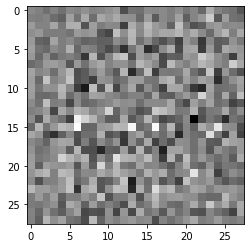

In [20]:
import tensorflow
import matplotlib.pyplot as plt
# noise
tensorflow.random.set_seed(4)

noise = tensorflow.random.normal([1, 100])
 
generator = define_generator(100)

# Generar una imagen a partir del ruido
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

# Our Generator

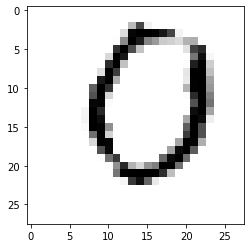

In [25]:
generated_image = g_model(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
plt.show()